# Land Classification from Satellite Images





In this mini project you will attempt to classify regions of the earths surface based on satellite images. You will be classifying these regions into the following classes:
* Urban
* Agricultural
* Rangeland
* Forest
* Water
* Barren

## Dataset description

The training datset consists of 803 satellite images in jpg format each paired with a mask in png format that includes the classification of each individual pixel in to one of the 6 classes above. More information about the dataset can be [found in this paper.](https://arxiv.org/abs/1805.06561)

The two unlabeled datasets consist of satellite images without the paired masks, so you must develop techniques to assess the performance of your classification.



## Machine learning tasks
1. Develop a machine learning algorithm that is capable of classifying whether a particular class of terrain is anywhere in the image (e.g. is there any water in the image) -- this is a binary classification for each class
2. Develop a machine learning algorithm that can determine the fraction of each class that is present in the image (e.g. what fraction of pixels are Urban vs Agricultutal etc.)
3. Develop a machine learning algorithm that is capable of classifying each pixel of a satellite image into one of the above classes


### Optional extension tasks
1. Test how robsut yoour classification is to the presence of inserted noise in the images, the inserted noise could be in the form of blurring or fake cloud coverage or some other reasonable defintion.
2. Construct a dimensionality reduction system to cluster each pixel on to an arbritary 2D plane. Make a plot form the training dataset of that dataset coloured by label.


### Things to think about
* What kind of data processing is appropriate?
* Should you change the mask from an RGB image into a more simple single class number for each pixel?
* Does it make sense to split your images into smaller subimages at the start to speed up the training process?
* Should you split your traiing sample further to give a validation or test sample?
* What is an appropriate cost or loss function?
* Should you consider data augementation?
* You could consider this task as a version of image segmentation which most rely on network structures similar to autoencoders (but these days are often referred to as u-net structures).
* You might take inspiration from the [Tensorflow Image Segmentation Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)



In [ ]:
from google.colab import drive #enabling access to files and folders stored in my google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, concatenate, SpatialDropout2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model


In [81]:
data_path = "/content/drive/MyDrive/Mini_Project /"

In [82]:
print(data_path + 'class_dict.csv')
#Read in the class information
classes=pd.read_csv(data_path+'class_dict.csv')
print(classes)

#Read in the meta information
meta=pd.read_csv(data_path + 'metadata.csv')
print(meta)

meta['sat_image_path'] = data_path + meta['sat_image_path']
meta['mask_path'] = data_path + meta['mask_path']


/content/drive/MyDrive/Mini_Project /class_dict.csv
               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0
      image_id     split           sat_image_path              mask_path
0       100694     train     train/100694_sat.jpg  train/100694_mask.png
1       102122     train     train/102122_sat.jpg  train/102122_mask.png
2        10233     train      train/10233_sat.jpg   train/10233_mask.png
3       103665     train     train/103665_sat.jpg  train/103665_mask.png
4       103730     train     train/103730_sat.jpg  train/103730_mask.png
...        ...       ...                      ...                    ...
1141    979233  nolabelb  nolabelb/979233_sat.jpg                    NaN
1142    983689  nolabelb  nolabelb/983689_sat.jpg                    NaN
1143    988

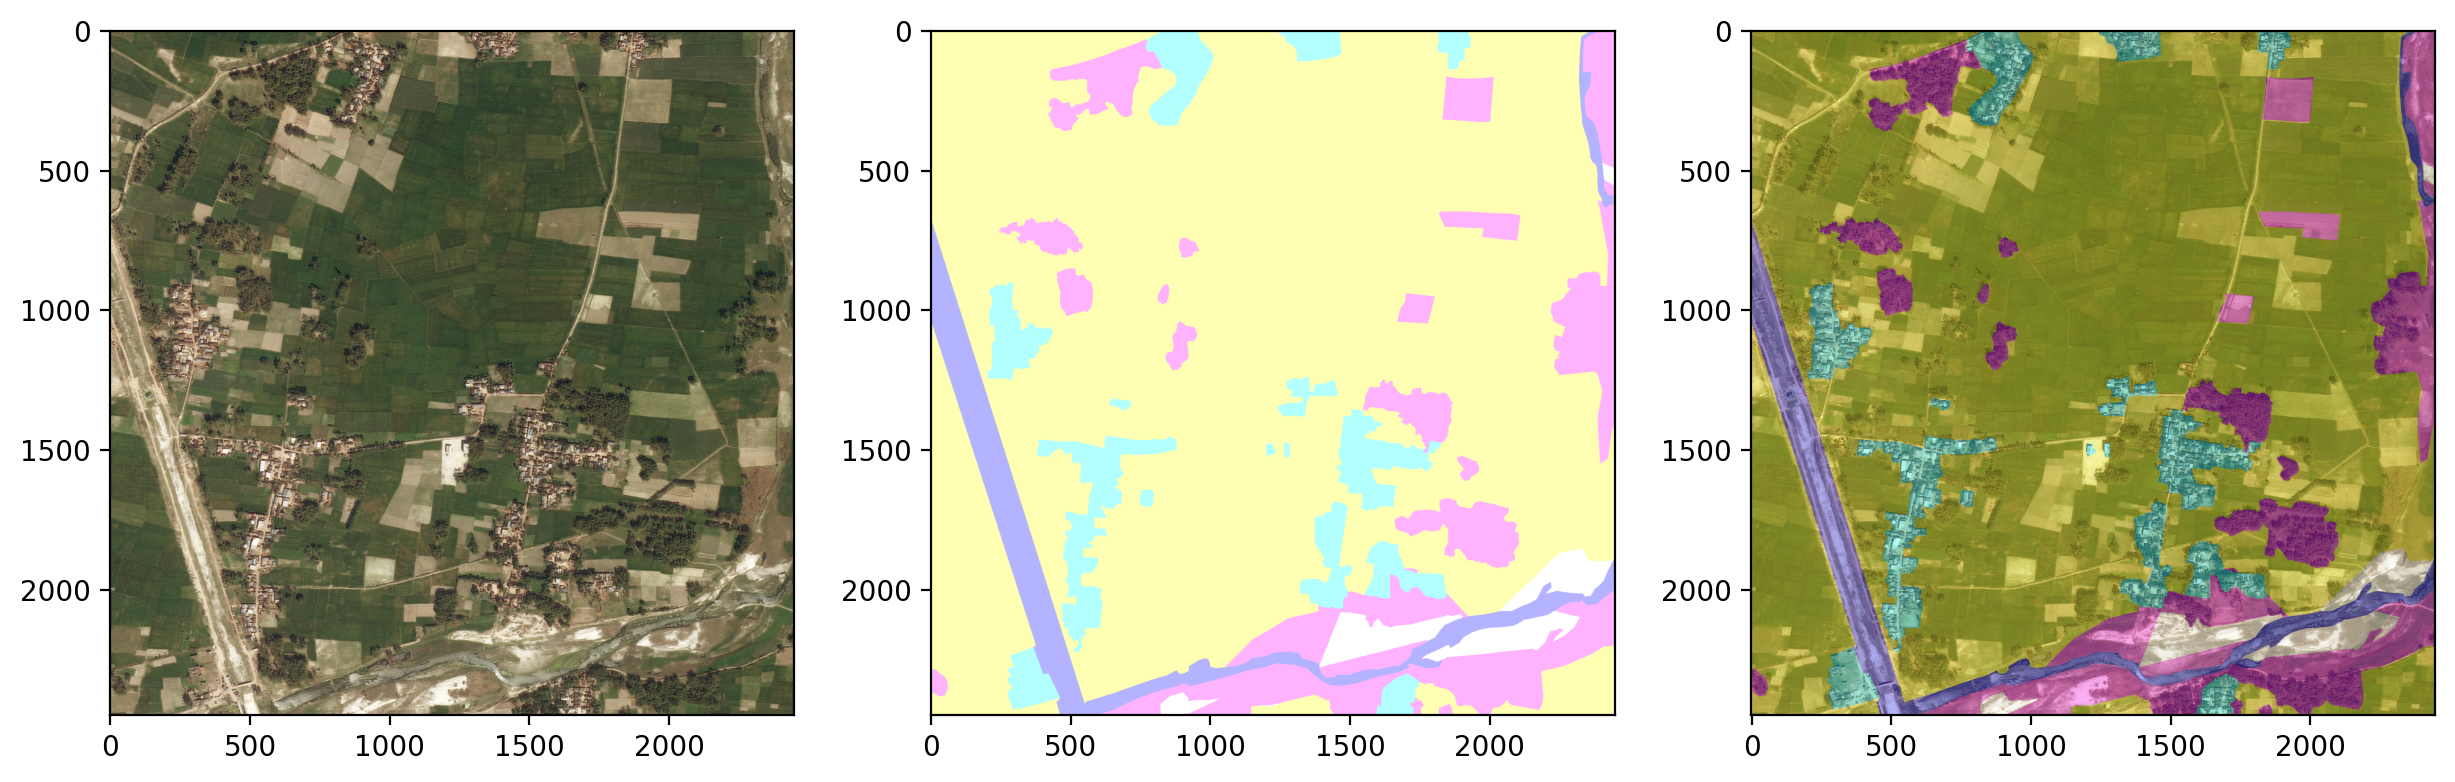

In [ ]:
#In this cell we will plot a single image from the training dataset and its associated mask
whichImg = 772
im=imageio.imread(meta['sat_image_path'][whichImg]) #Read in the sat image
mask=imageio.imread(meta['mask_path'][whichImg]) #Read in the mask
# Three plots: satellite, mask, mask+satellite
fig,ax = plt.subplots(1,3,figsize=(15, 15)) #This fig size was convenient for my screen
ax[0].imshow(im)
ax[1].imshow(mask,alpha=0.3) #alpha=0.3 to make the mask transparent
ax[2].imshow(im)
ax[2].imshow(mask,alpha=0.3) #alpha=0.3 to make the mask transparent

## TASK 1:
Develop a machine learning algorithm that is capable of classifying whether a particular class of terrain is anywhere in the image (e.g. is there any water in the image) -- this is a binary classification for each class

First, binary training labels are created for the model. The images are resized as my computer lacks sufficient RAM to store full-sized images.

In [ ]:


# Initialize empty lists to store training images and labels
training_images = []
training_labels = []

DATAPOINTS = 803

# Create a tqdm progress bar for the loop
for i in tqdm(range(DATAPOINTS), desc='Processing Images'):
    # Construct the file paths for the current iteration
    sat_image_path = meta.loc[i, 'sat_image_path']
    mask_path = meta.loc[i, 'mask_path']

    # Read the satellite image and mask
    sat_image = cv2.imread(sat_image_path)
    mask_image = cv2.imread(mask_path)

    # Resize the images
    target_size = (256, 256)
    sat_image = cv2.resize(sat_image, target_size)
    mask_image = cv2.resize(mask_image, target_size)

    # Extract the label for the current image from metadata
    label = 0

    if np.any((mask_image == [255, 0, 255]).all(axis=-1)):
         label = 1
         print(f'Image {i}: Yes')
    else:
         print(f'Image {i}: No')

    training_images.append(sat_image)
    training_labels.append(label)

# Convert the list of images to a numpy array
training_images = np.array(training_images)
training_labels = np.array(training_labels)


file_path = '/content/drive/MyDrive/training_images512.ipynb.npy'

np.save(file_path, training_images)


Processing Images: 100%|██████████| 803/803 [01:54<00:00,  7.02it/s]


The first 700 training images will be used to train the models. Testing will be conducted on the last 103 training images to compare predictions with the true image labels.

In [70]:
#loaded in 700 training images and training labels for all landtypes

DATAPOINTS = 700

#TRAINING IMAGES
training_image_path = '/content/drive/MyDrive/Mini_Project /training_images.ipynb.npy'
training_images = np.load(training_image_path)[:DATAPOINTS]

#LAND TYPE LABELS
barren_land_path = '/content/drive/MyDrive/LandTypes/barren_land.ipynb.npy'
barren_land_labels = np.load(barren_land_path)[:DATAPOINTS]

water_path = '/content/drive/MyDrive/LandTypes/water.ipynb.npy'
water_labels = np.load(water_path)[:DATAPOINTS]

urban_land_path = '/content/drive/MyDrive/LandTypes/urban_land.ipynb.npy'
urban_land_labels = np.load(urban_land_path)[:DATAPOINTS]

forest_land_path = '/content/drive/MyDrive/LandTypes/forest_land.ipynb.npy'
forest_land_labels = np.load(forest_land_path)[:DATAPOINTS]

rangeland_path = '/content/drive/MyDrive/LandTypes/rangeland.ipynb.npy'
rangeland_labels = np.load(rangeland_path)[:DATAPOINTS]

agriculture_land_path = '/content/drive/MyDrive/LandTypes/agriculture_land.ipynb.npy'
agriculture_land_labels = np.load(agriculture_land_path)[:DATAPOINTS]


##Model 1:

When attempting to utilize a pretrained model like VGG16 and employing early callbacks while examining the accuracy and loss curves, it becomes evident that the model is overfitting the data.

In [ ]:
# Define Early Stopping callback outside the function
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)

def train_model(labels):
    """
    This function trains a VGG16-based model for binary classification on images.

    Arguments:
    - training_images: numpy array of shape (num_samples, height, width, channels) containing the training images
    - labels: numpy array of shape (num_samples,) containing the corresponding labels (0 or 1)

    Returns:
    - vgg16_model: trained VGG16-based model
    """
    # Load pre-trained VGG16 model
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the VGG16 layers
    vgg16.trainable = False

    # Instantiate a Sequential model
    vgg16_model = Sequential()

    # Input Layer
    vgg16_model.add(vgg16)

    # Flatten Layer
    vgg16_model.add(Flatten())

    # Dense Layer
    vgg16_model.add(Dense(32, activation='relu'))
    vgg16_model.add(Dropout(0.2))

    # Output Layer
    vgg16_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(training_images, labels, test_size=0.2, random_state=42)

    # Preprocess input images
    X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
    X_test = tf.keras.applications.vgg16.preprocess_input(X_test)

    # Train the model with Early Stopping callback
    history = vgg16_model.fit(X_train, y_train, epochs=10, batch_size=15, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Plot accuracy vs. epoch
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

    return vgg16_model



58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
6/6 [==============================] - 79s 14s/step - loss: 3.2077 - accuracy: 0.5610 - val_loss: 3.1854 - val_accuracy: 0.6667
Epoch 2/10
6/6 [==============================] - 78s 13s/step - loss: 1.8495 - accuracy: 0.7805 - val_loss: 10.6546 - val_accuracy: 0.6667
Epoch 3/10
6/6 [==============================] - 78s 14s/step - loss: 1.2756 - accuracy: 0.8902 - val_loss: 3.7969 - val_accuracy: 0.7619
Epoch 4/10
6/6 [==============================] - 80s 14s/step - loss: 0.1828 - accuracy: 0.9512 - val_loss: 4.1280 - val_accuracy: 0.6190
Epoch 5/10
6/6 [==============================] - 78s 13s/step - loss: 0.3827 - accuracy: 0.9268 - val_loss: 2.7400 - val_accuracy: 0.6667
Epoch 5: early stopping


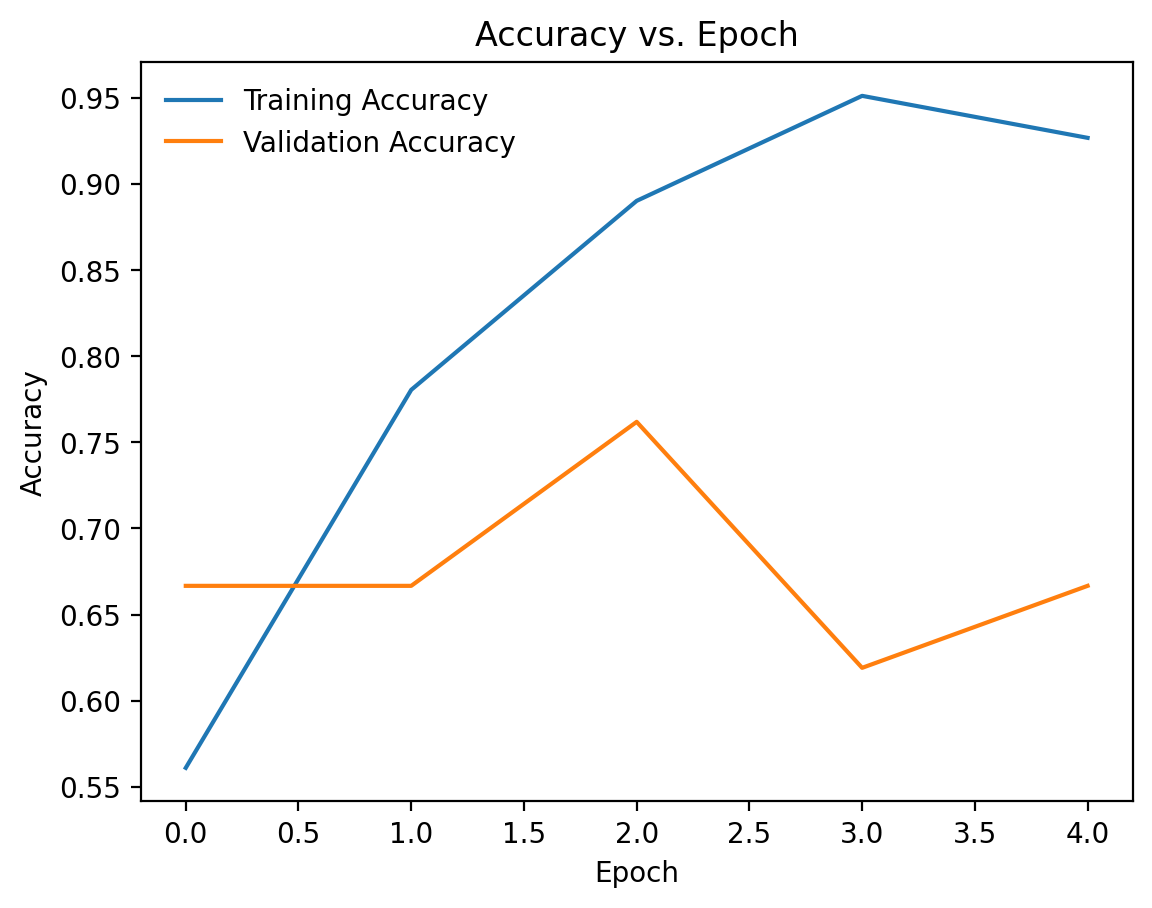

In [ ]:
rangeland_model = train_model(rangeland_labels)

##Model 2:

In an attempt to mitigate overfitting, I opted to develop a custom CNN model featuring convolution and max pooling layers, supplemented with L1 regularization. Despite these efforts, overfitting persisted. The model managed to reach epoch 6, showcasing some improvement over Model 1, albeit with validation accuracy leveling off.

In [ ]:
# Define Early Stopping callback outside the function
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

def train_model3(training_images, labels):
    """
    This function trains a convolutional neural network (CNN) model for
    binary classification.

    Arguments:
    - training_images: numpy array of shape (num_samples, height, width, channels) containing the training images.
    - labels: numpy array of shape (num_samples,) containing the corresponding labels (0 or 1).

    Returns:
    - model: trained CNN model.
    """
    # Instantiate a Sequential model
    model = Sequential()

    # Input Layer- Convolution
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(256, 256, 3),
                     kernel_regularizer=regularizers.l1(0.005)))

    # Layer 1- max pool in 2x2 window
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2- another convolution layer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.005)))

    # Layer 3- another max pool layer
    model.add(MaxPooling2D((2, 2)))

    # Layer 4- connect all nodes with dense layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.005)))

    # Output Layer- sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the sequential CNN model- adam optimizer,
    # binary_crossentropy loss, and set our metric to accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(training_images, labels, test_size=0.2, random_state=42)

    # Train the model with Early Stopping callback
    history = model.fit(X_train, y_train, epochs=10, batch_size=15, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Plot accuracy vs. epoch
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

    return model



Epoch 1/10
38/38 [==============================] - 56s 1s/step - loss: 185.4228 - accuracy: 0.5589 - val_loss: 62.8727 - val_accuracy: 0.6286
Epoch 2/10
38/38 [==============================] - 50s 1s/step - loss: 53.8638 - accuracy: 0.6286 - val_loss: 45.7530 - val_accuracy: 0.6714
Epoch 3/10
38/38 [==============================] - 50s 1s/step - loss: 39.5747 - accuracy: 0.6250 - val_loss: 36.2880 - val_accuracy: 0.6714
Epoch 4/10
38/38 [==============================] - 48s 1s/step - loss: 33.4105 - accuracy: 0.6393 - val_loss: 28.5908 - val_accuracy: 0.6714
Epoch 5/10
38/38 [==============================] - 50s 1s/step - loss: 25.2992 - accuracy: 0.6482 - val_loss: 23.0126 - val_accuracy: 0.6714
Epoch 6/10
38/38 [==============================] - 50s 1s/step - loss: 20.4996 - accuracy: 0.6482 - val_loss: 18.3039 - val_accuracy: 0.6714
Epoch 6: early stopping


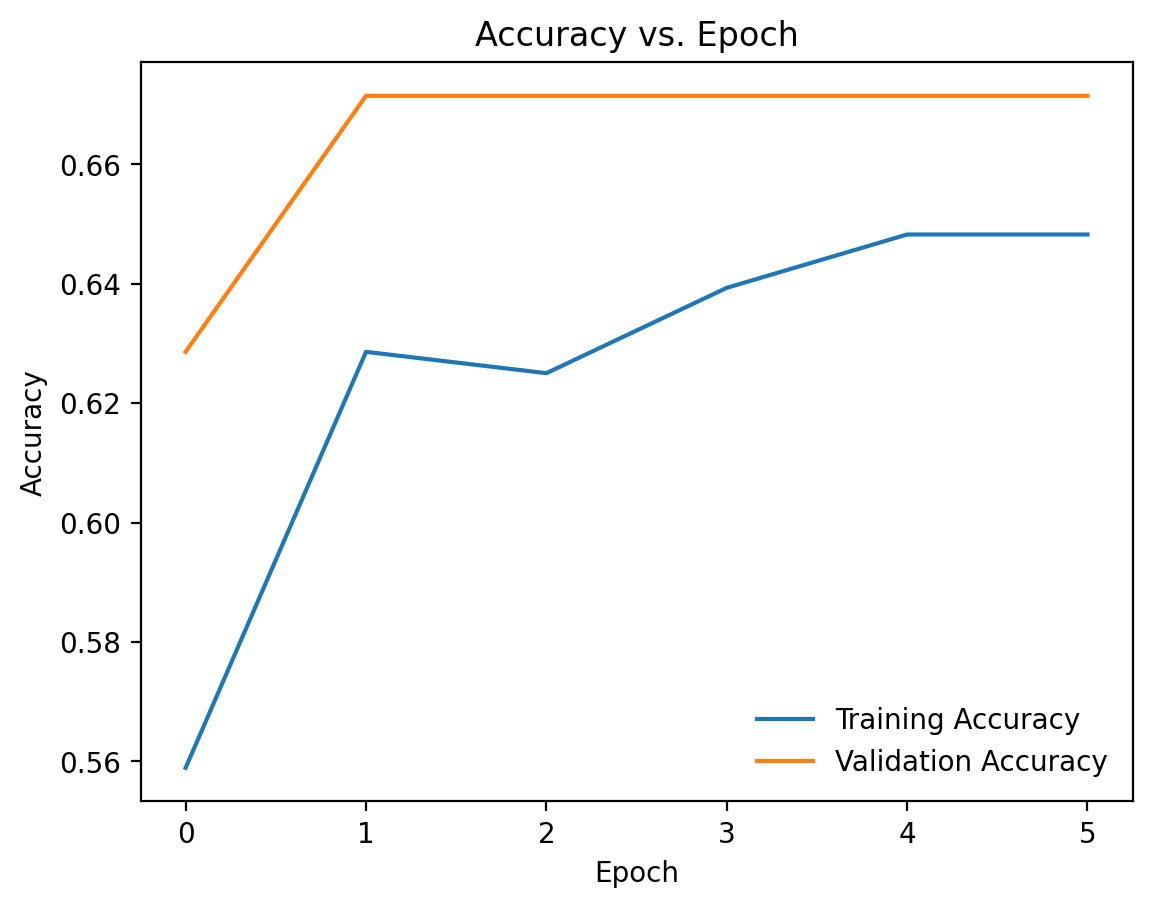

In [ ]:
rangeland_model = train_model3(rangeland_labels)

##Model 3:

In an effort to combat overfitting, I incorporated dropout layers instead of L1 regularization. This adjustment yielded an enhancement from the previous model, as evidenced by the convergence of the training and validation accuracy curves.

In [ ]:
# Define Early Stopping callback outside the function
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

def train_model4(training_images, labels):
    """
    This function trains a convolutional neural network (CNN) model for binary classification.

    Arguments:
    - training_images: numpy array of shape (num_samples, height, width, channels) containing the training images.
    - labels: numpy array of shape (num_samples,) containing the corresponding labels (0 or 1).

    Returns:
    - model: trained CNN model.
    """
    # Instantiate a Sequential model
    model = Sequential()

    # Input Layer- Convolution
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(256, 256, 3)))

    # Layer 1- max pool in 2x2 window
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Layer 2- another convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.3))

    # Layer 3- another max pool layer
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.3))

    # Layer 4- connect all nodes with dense layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer- sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the sequential CNN model- adam optimizer,
    # binary_crossentropy loss, and set our metric to accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(training_images, labels, test_size=0.2, random_state=42)

    # Train the model with Early Stopping callback
    history = model.fit(X_train, y_train, epochs=10, batch_size=15, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Plot accuracy vs. epoch
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

    # Plot loss vs. epoch
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()

    return model



Epoch 1/10
6/6 [==============================] - 22s 3s/step - loss: 1422.5468 - accuracy: 0.6098 - val_loss: 34.3616 - val_accuracy: 0.3333
Epoch 2/10
6/6 [==============================] - 17s 3s/step - loss: 9.9525 - accuracy: 0.4512 - val_loss: 0.6914 - val_accuracy: 0.5714
Epoch 3/10
6/6 [==============================] - 17s 3s/step - loss: 0.7991 - accuracy: 0.6220 - val_loss: 0.6548 - val_accuracy: 0.7143
Epoch 4/10
6/6 [==============================] - 17s 3s/step - loss: 0.8018 - accuracy: 0.6098 - val_loss: 0.6928 - val_accuracy: 0.6667
Epoch 5/10
6/6 [==============================] - 20s 3s/step - loss: 0.6909 - accuracy: 0.5976 - val_loss: 0.6927 - val_accuracy: 0.6667
Epoch 6/10
6/6 [==============================] - 30s 5s/step - loss: 0.6923 - accuracy: 0.5610 - val_loss: 0.6924 - val_accuracy: 0.6667
Epoch 7/10
6/6 [==============================] - 24s 4s/step - loss: 0.6889 - accuracy: 0.5732 - val_loss: 0.6942 - val_accuracy: 0.6667
Epoch 8/10
6/6 [==============

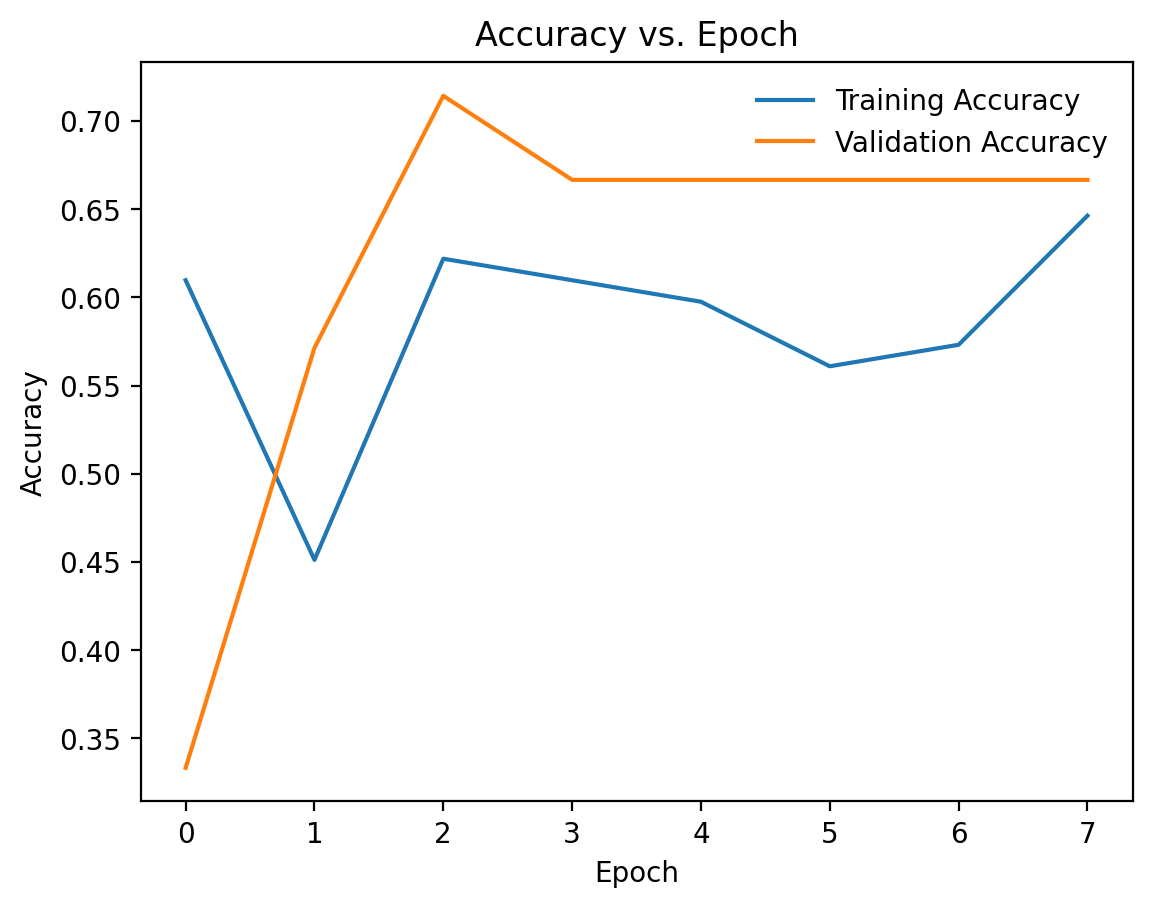

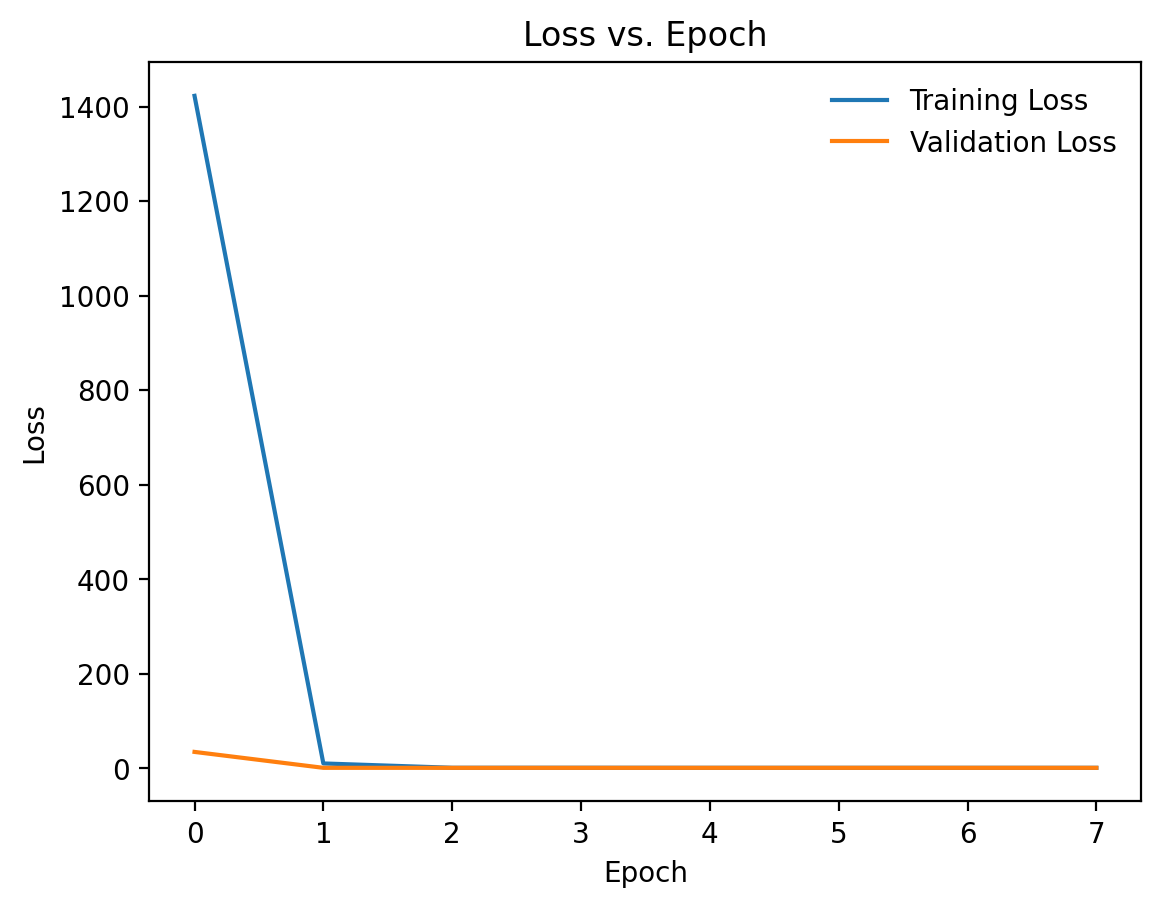

In [ ]:
rangeland_model = train_model4(rangeland_labels)

#Model 4:

To mitigate overfitting and reduce runtime, I reduced the number of filters in the initial convolution layer to 10 and introduced L2 regularization alongside dropout layers. Additionally, I included an extra dense layer in the model architecture. Despite these modifications, overfitting persisted.


In [ ]:

# Define Early Stopping callback outside the function
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)

def train_model5(labels):

    """
    This function trains a convolutional neural network (CNN) model for binary classification.

    Arguments:
    - training_images: numpy array of shape (num_samples, height, width, channels) containing the training images.
    - labels: numpy array of shape (num_samples,) containing the corresponding labels (0 or 1).

    Returns:
    - model: trained CNN model.
    """
    # Instantiate a Sequential model
    model = Sequential()

    # Input Layer- Convolution
    model.add(Conv2D(filters=10,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(256, 256, 3),
                     kernel_regularizer=regularizers.l2(0.001)))

    # Layer 1- max pool in 2x2 window
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2- another convolution layer
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))

    # Layer 3- another max pool layer
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))

    # Layer 4- connect all nodes with dense layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer without the 'layers' module

    #Layer 5
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer without the 'layers' module

    # Output Layer- sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the sequential CNN model- adam optimizer,
    # binary_crossentropy loss, and set our metric to accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(training_images, labels, test_size=0.3, random_state=42)

    # Train the model with Early Stopping callback
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Plot accuracy vs. epoch
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

    # Plot loss vs. epoch
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()

    return model


Epoch 1/10
49/49 [==============================] - 25s 471ms/step - loss: 9.4813 - accuracy: 0.5224 - val_loss: 0.9290 - val_accuracy: 0.6714
Epoch 2/10
49/49 [==============================] - 23s 471ms/step - loss: 0.9276 - accuracy: 0.5918 - val_loss: 0.9048 - val_accuracy: 0.6810
Epoch 3/10
49/49 [==============================] - 26s 542ms/step - loss: 0.8690 - accuracy: 0.6306 - val_loss: 0.8668 - val_accuracy: 0.6810
Epoch 4/10
49/49 [==============================] - 25s 520ms/step - loss: 0.8165 - accuracy: 0.6816 - val_loss: 0.8527 - val_accuracy: 0.6810
Epoch 5/10
49/49 [==============================] - 22s 456ms/step - loss: 0.7613 - accuracy: 0.7224 - val_loss: 0.8540 - val_accuracy: 0.6810
Epoch 6/10
49/49 [==============================] - 23s 482ms/step - loss: 0.7275 - accuracy: 0.7939 - val_loss: 0.8931 - val_accuracy: 0.6619
Epoch 6: early stopping


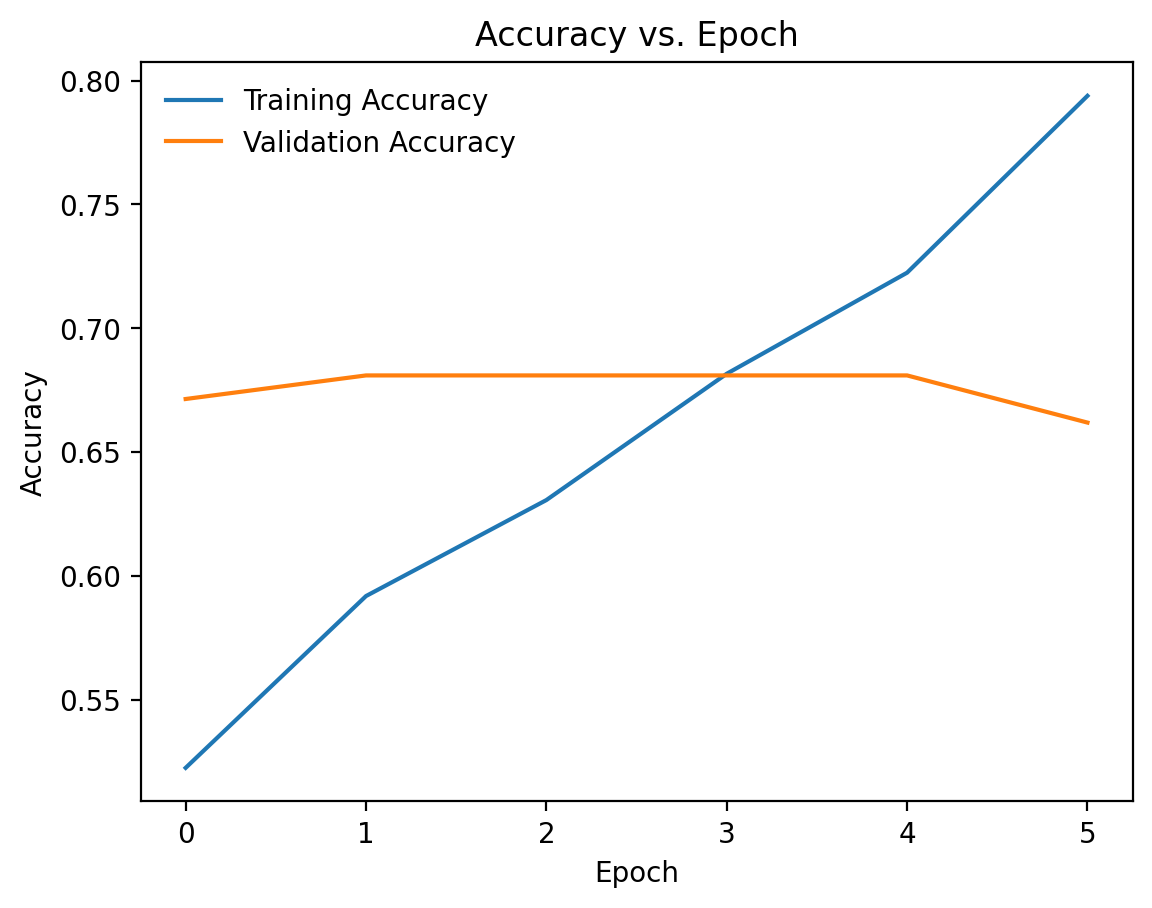

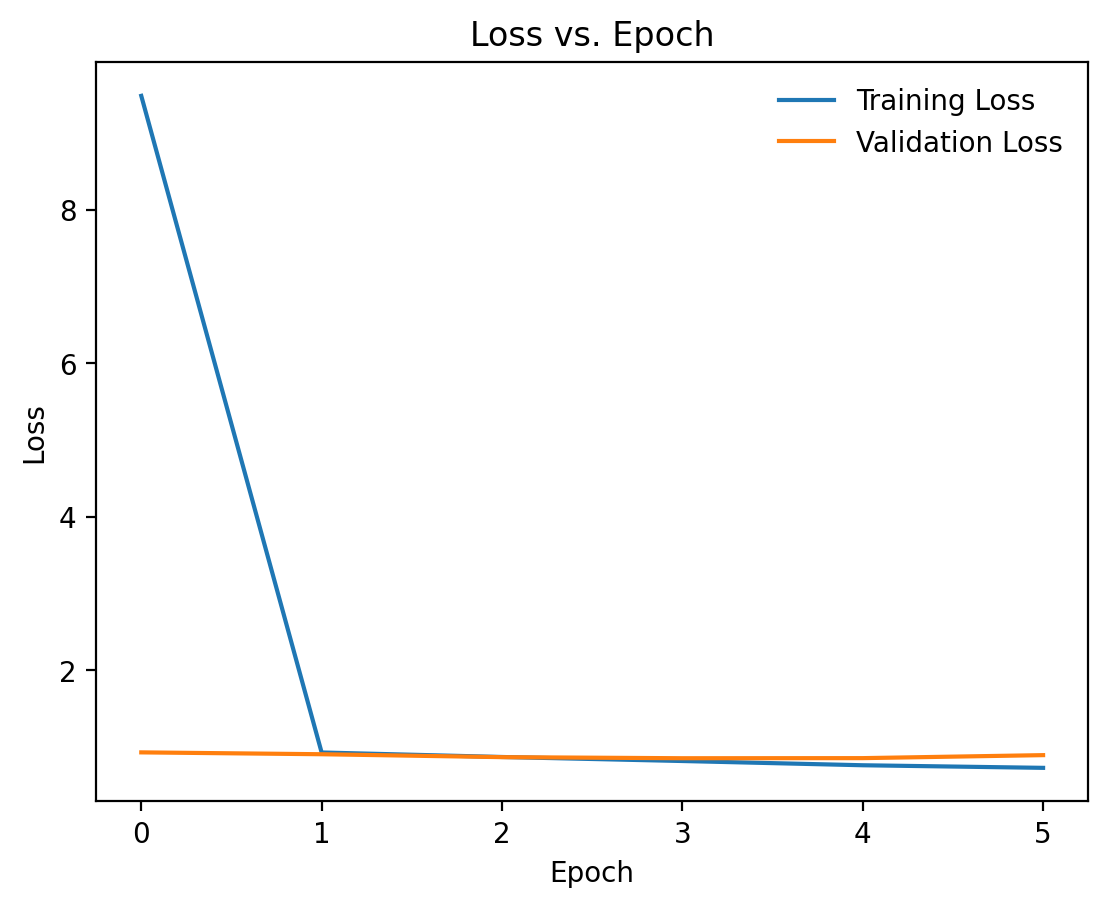

In [ ]:
rangeland_model = train_model5(rangeland_labels)

##Model 6:

I decided to experiment with another pretrained model, ResNet50. This model yielded the most promising results among all the models, achieving approximately 90% training accuracy across all land types. However, despite efforts to mitigate overfitting, such as early stopping, overfitting persisted, leading to early termination of training in some cases, around epoch 10.

In [ ]:
# Define Early Stopping callback outside the function
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

def train_model6(labels):
    """
    This function trains a convolutional neural network (CNN) model for binary classification.

    Arguments:
    - labels: numpy array of shape (num_samples,) containing the corresponding labels (0 or 1).

    Returns:
    - model: trained CNN model.
    """
    # Load the pre-trained ResNet50 model without including the top (classification) layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers in the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model on top of the pre-trained base model
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    # Add custom dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(training_images, labels, test_size=0.2, random_state=42)

    # Train the model with Early Stopping callback
    history = model.fit(X_train, y_train, epochs=10, batch_size=15, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Plot accuracy vs. epoch
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()

    # Plot loss vs. epoch
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()

    return model


94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57142657 (217.98 MB)
Trainable params: 33554945 (128.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_______

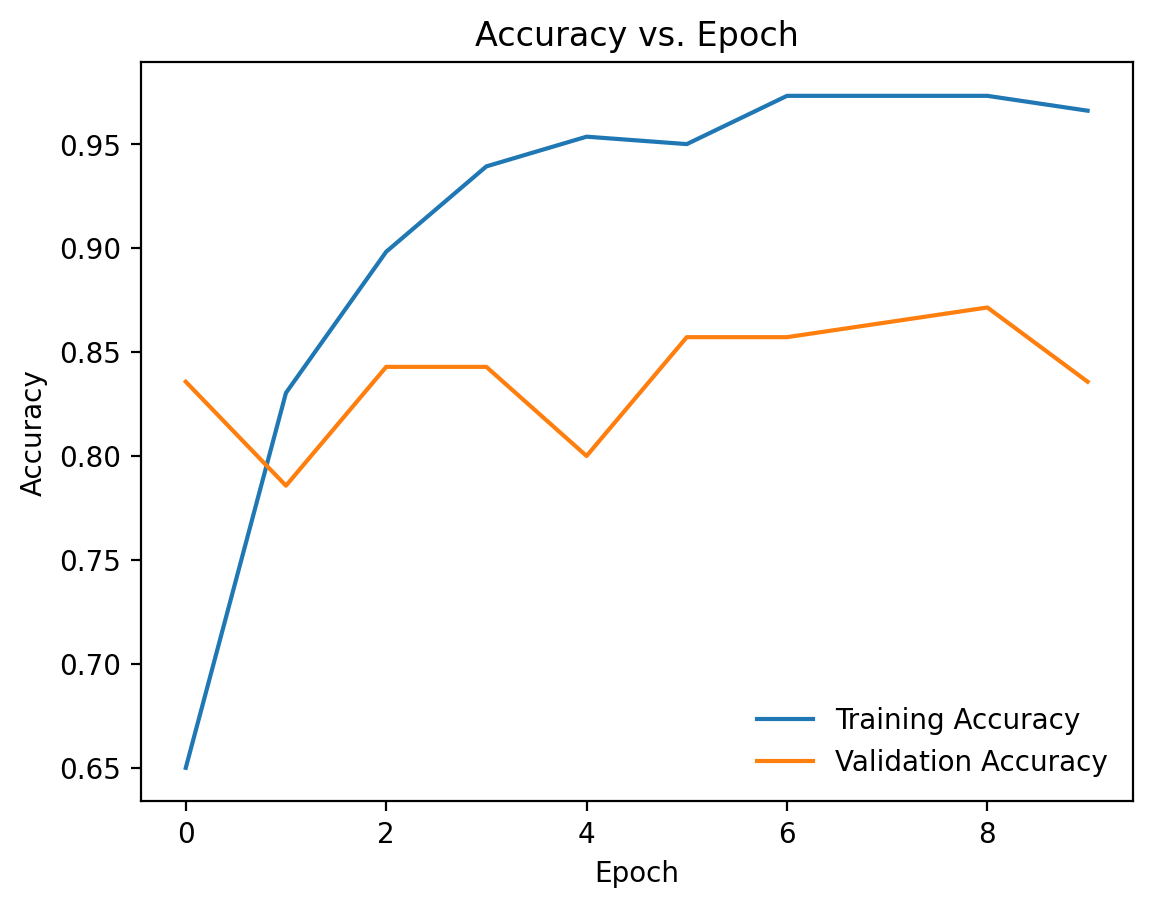

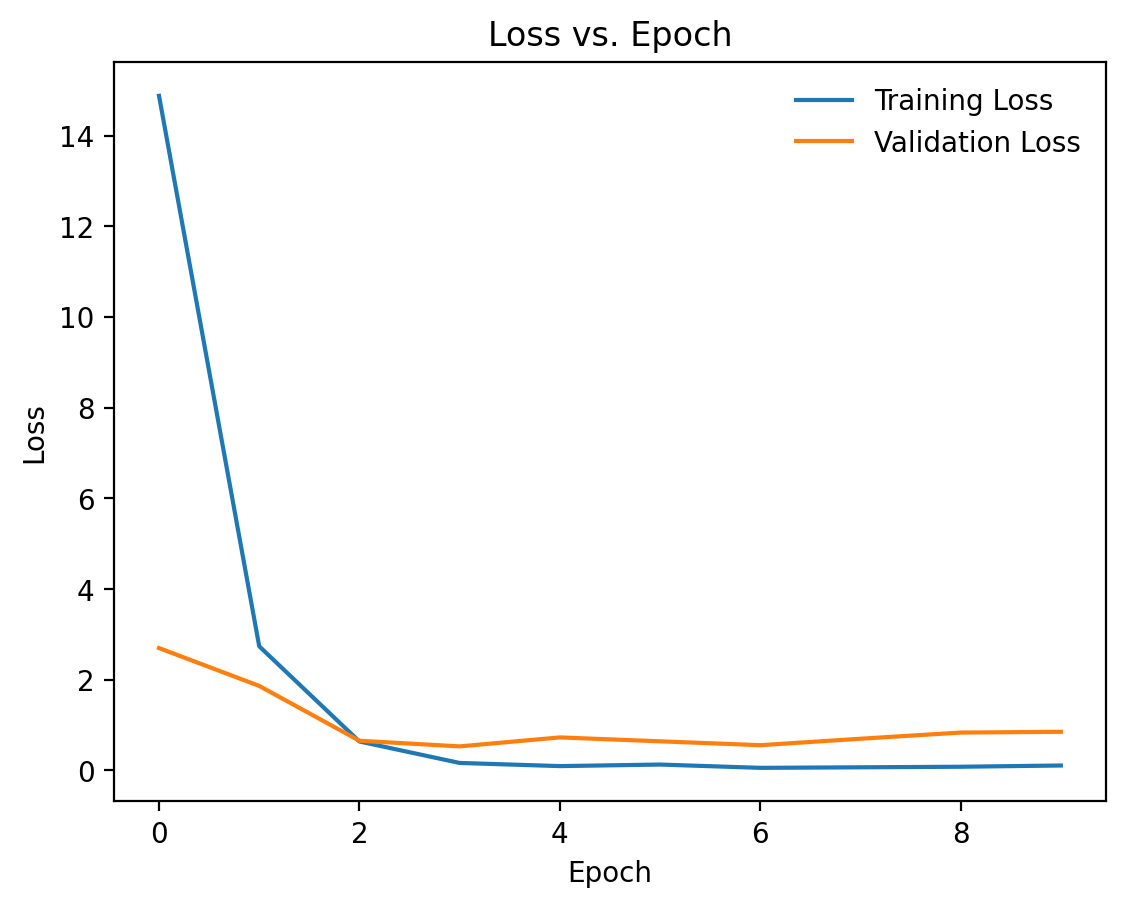

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57142657 (217.98 MB)
Trainable params: 33554945 (128.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoc

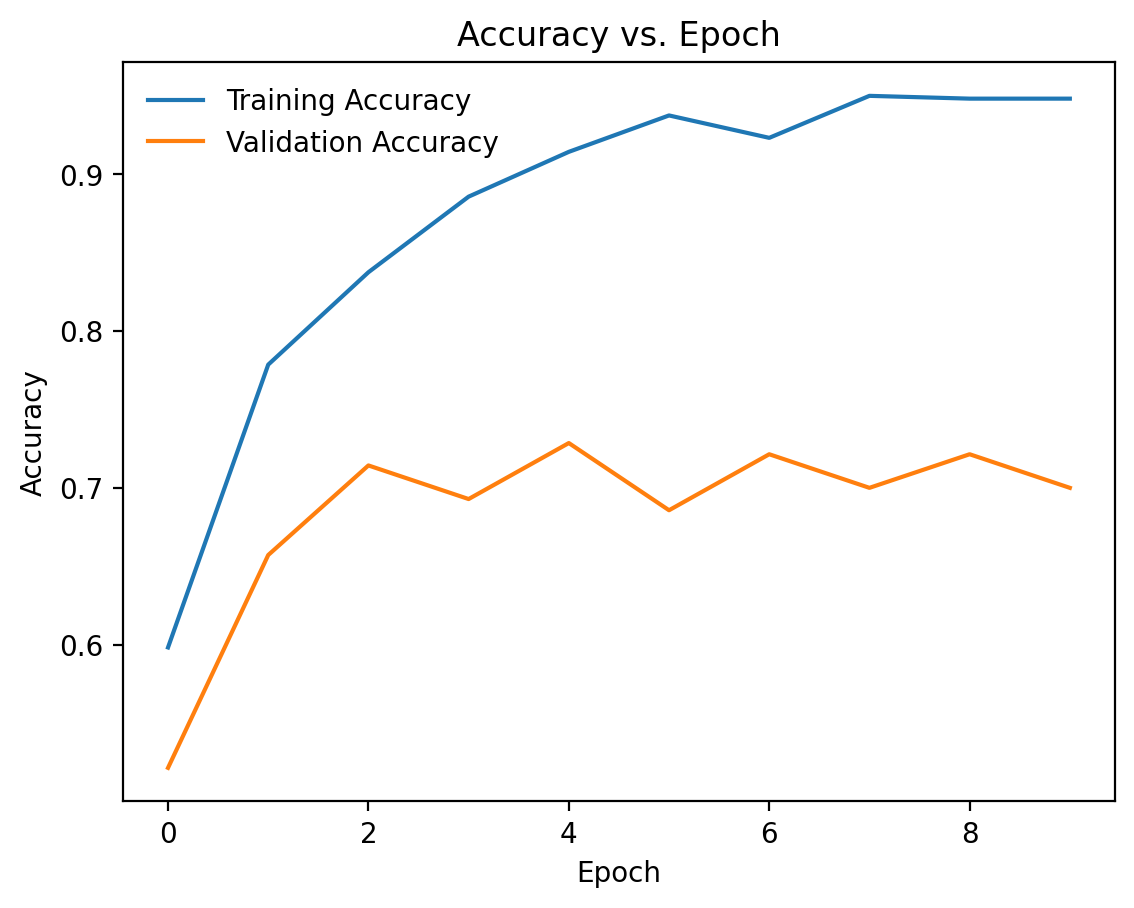

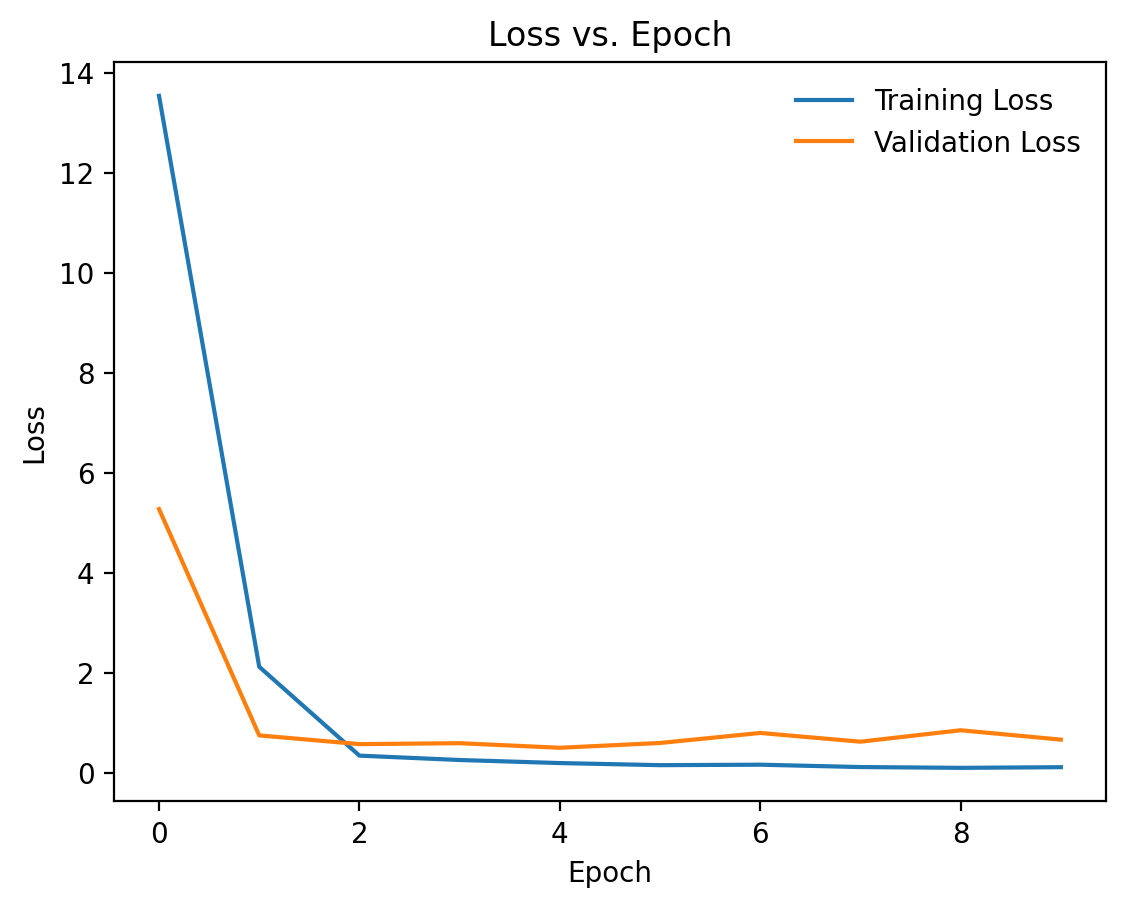

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57142657 (217.98 MB)
Trainable params: 33554945 (128.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoc

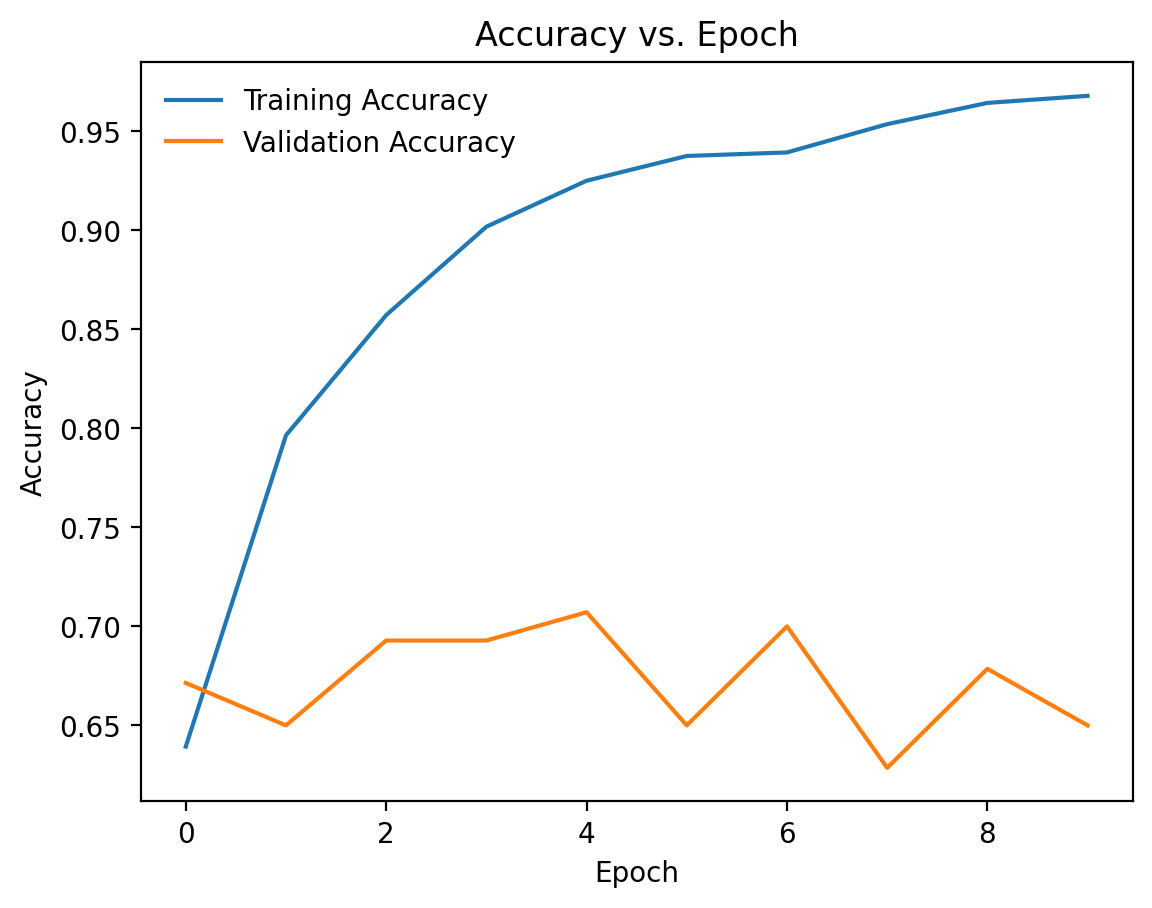

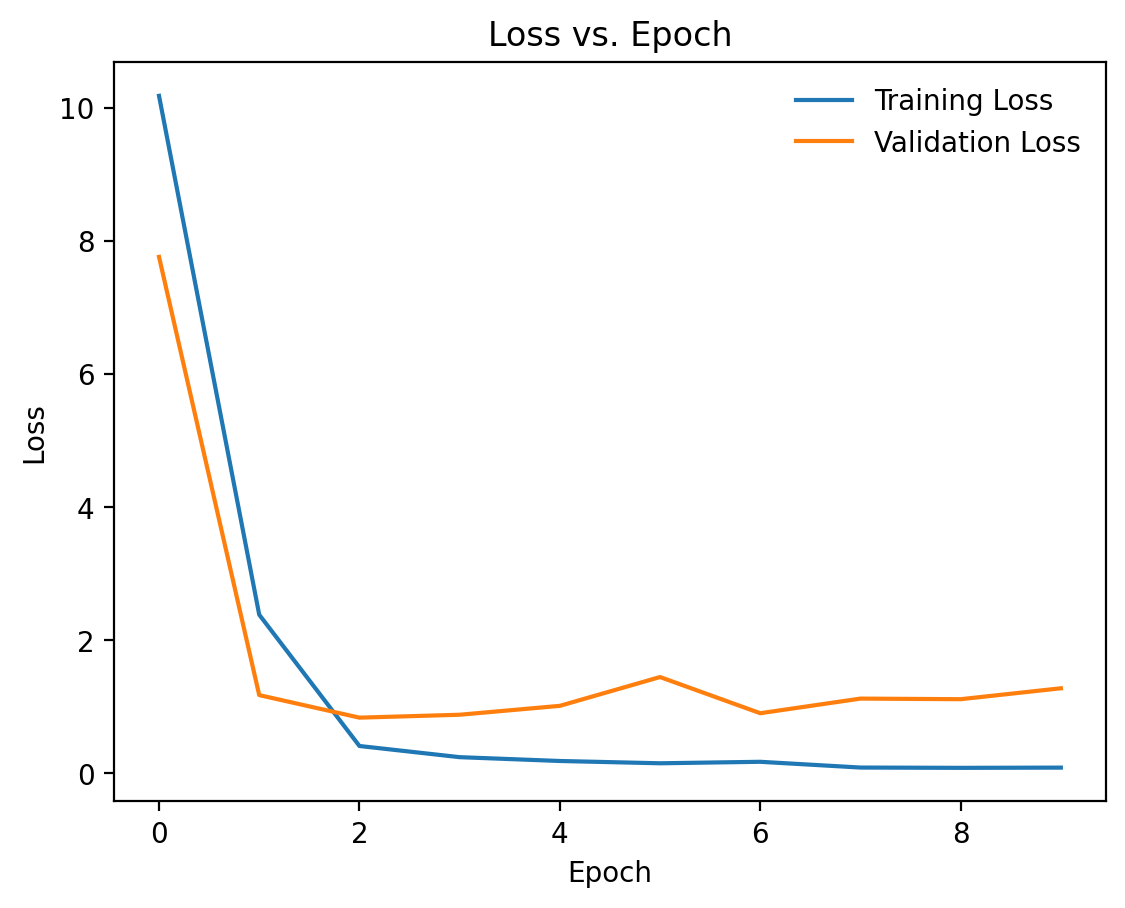

NameError: name 'agricultre_land_labels' is not defined

In [ ]:
rangeland_model = train_model6(rangeland_labels)
rangeland_model.save("/content/drive/MyDrive/saved_modelsNEW/rangelandNEW_model.h5")

water_model = train_model6(water_labels)
water_model.save("/content/drive/MyDrive/saved_modelsNEW/waterNEW_model.h5")

barren_land_model = train_model6(barren_land_labels)
barren_land_model.save("/content/drive/MyDrive/saved_modelsNEW/barrenNEW_model.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57142657 (217.98 MB)
Trainable params: 33554945 (128.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoc

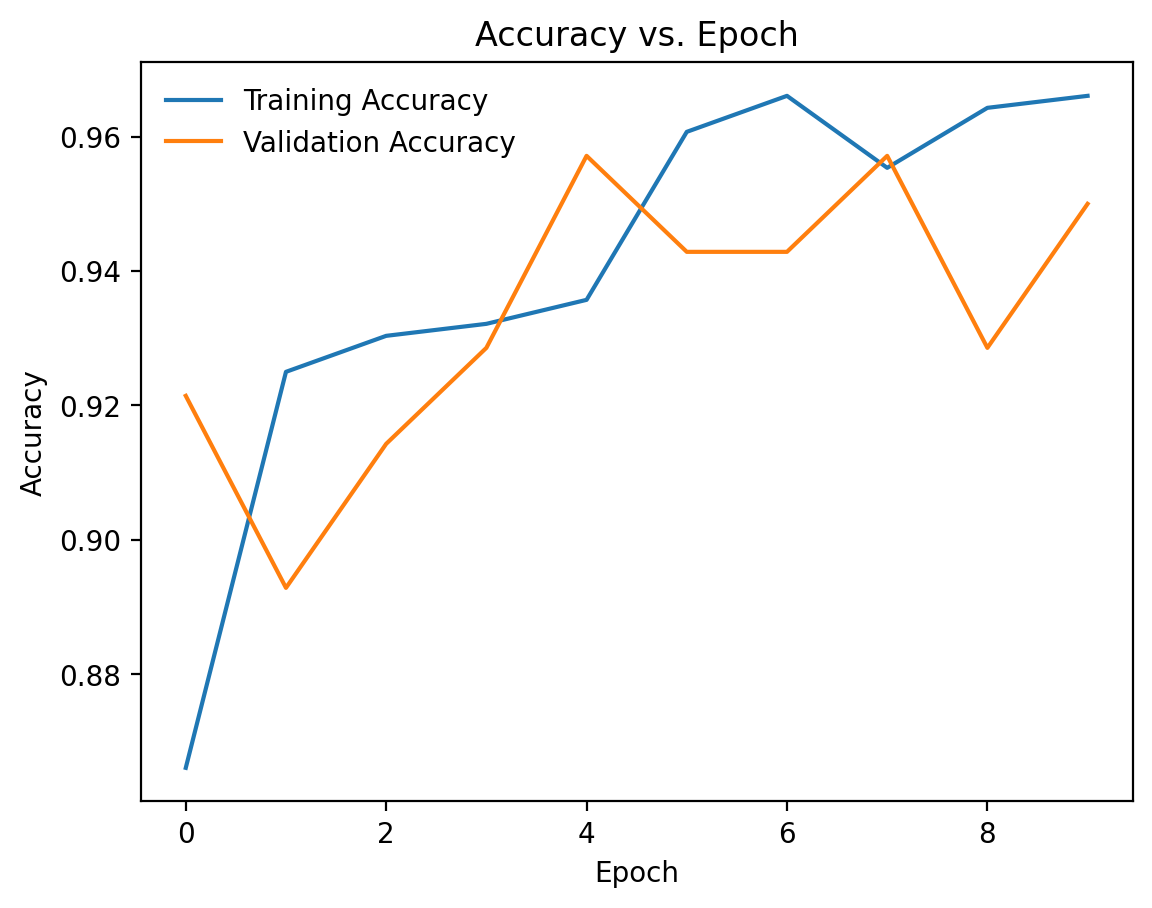

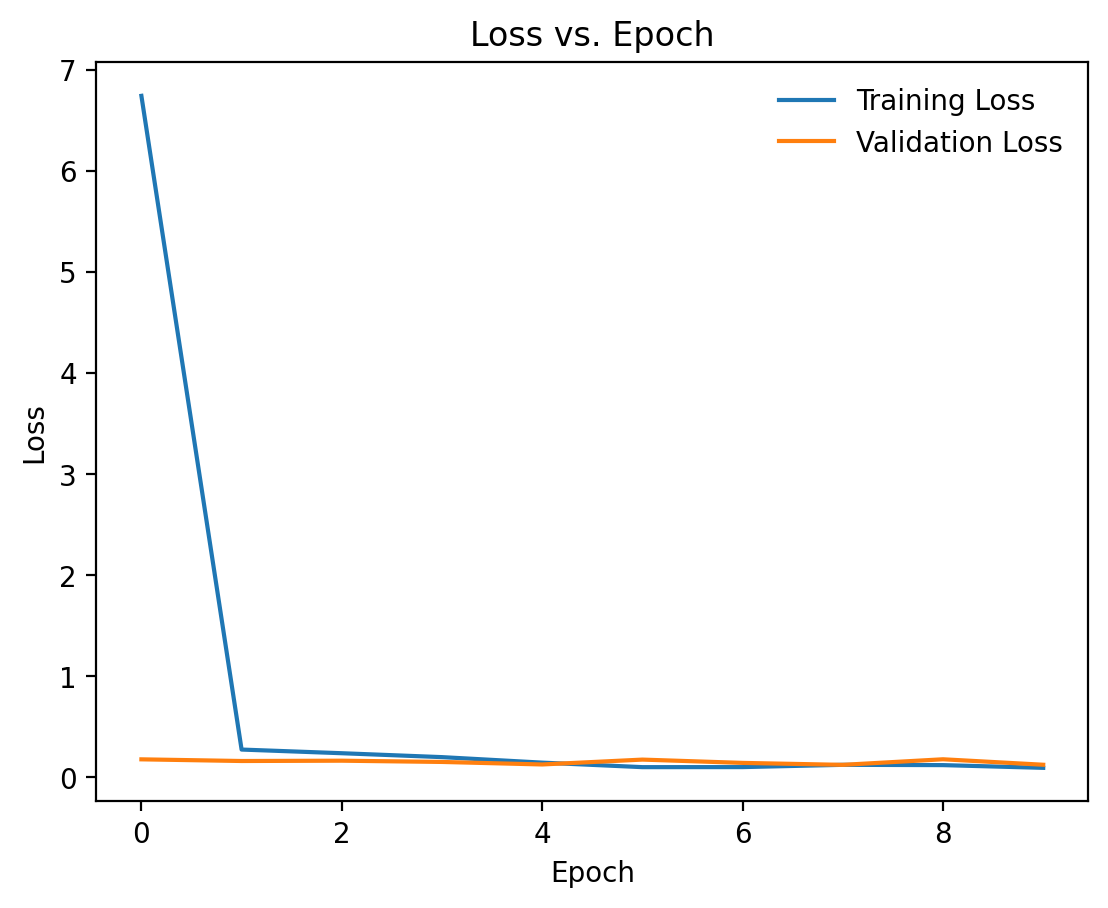

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               33554688  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57142657 (217.98 MB)
Trainable params: 33554945 (128.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoc

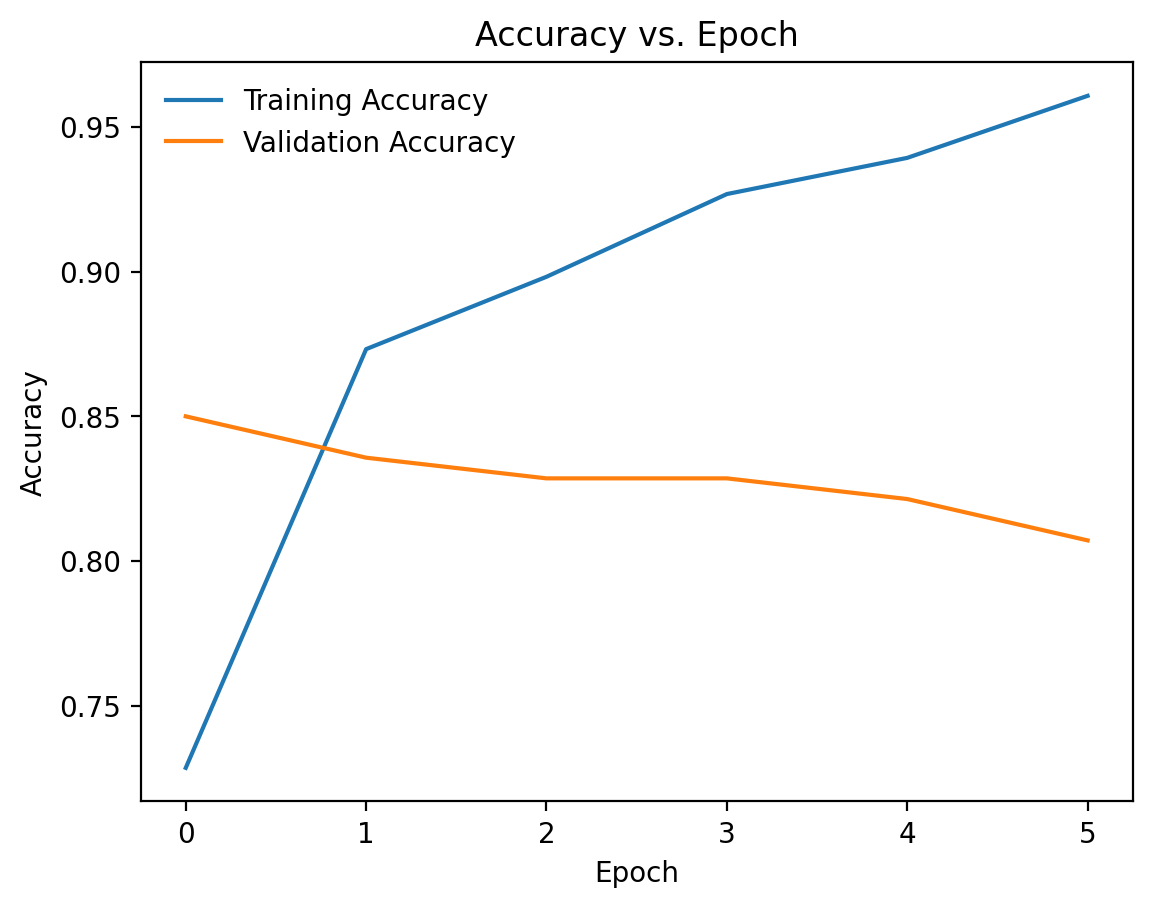

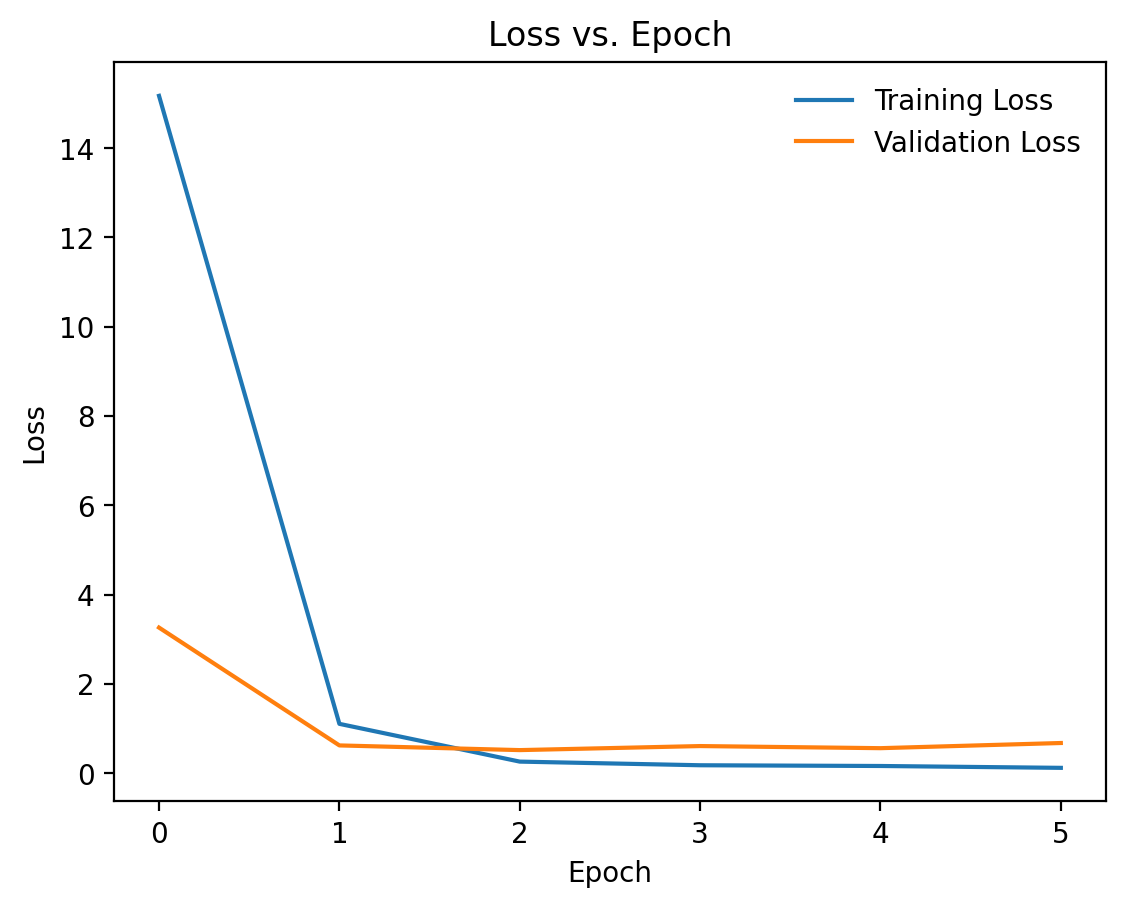

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               33554688  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 57142657 (217.98 MB)
Trainable params: 33554945 (128.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoc

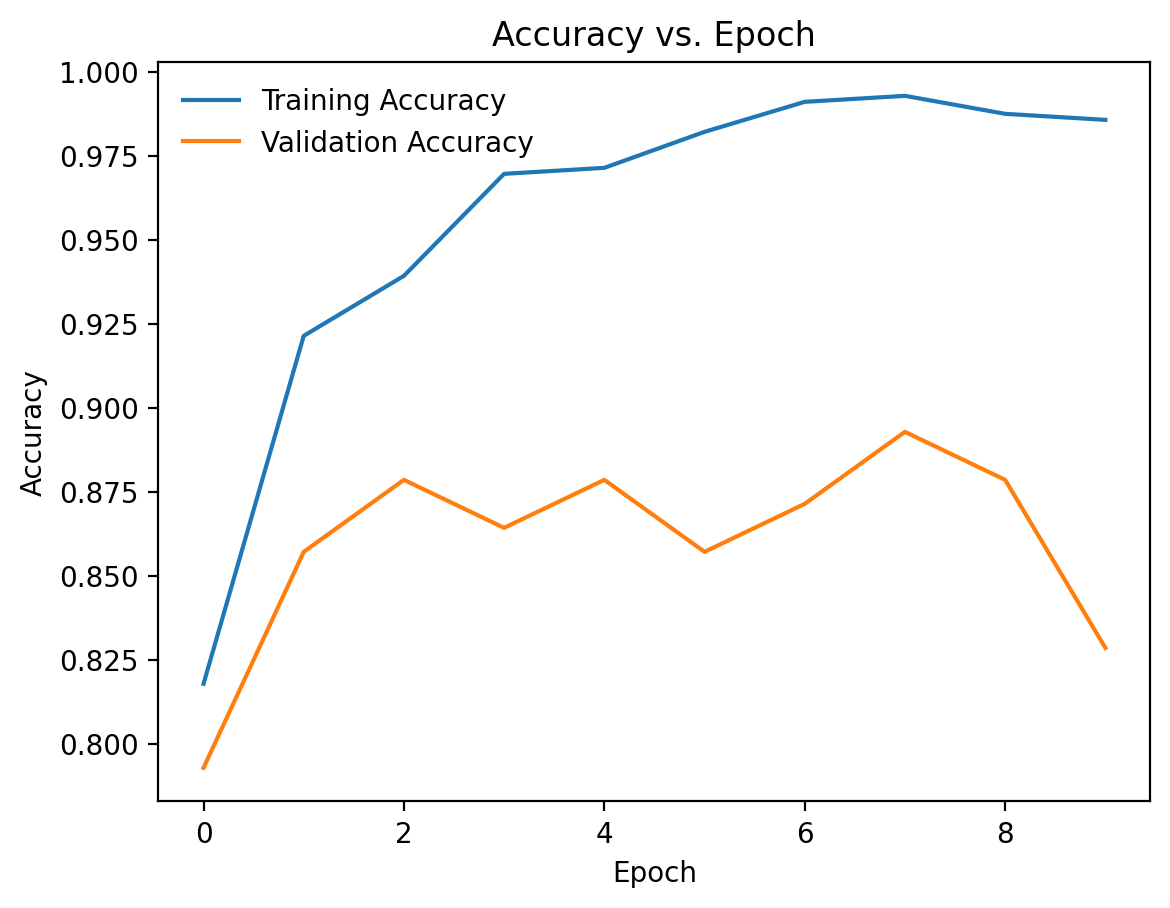

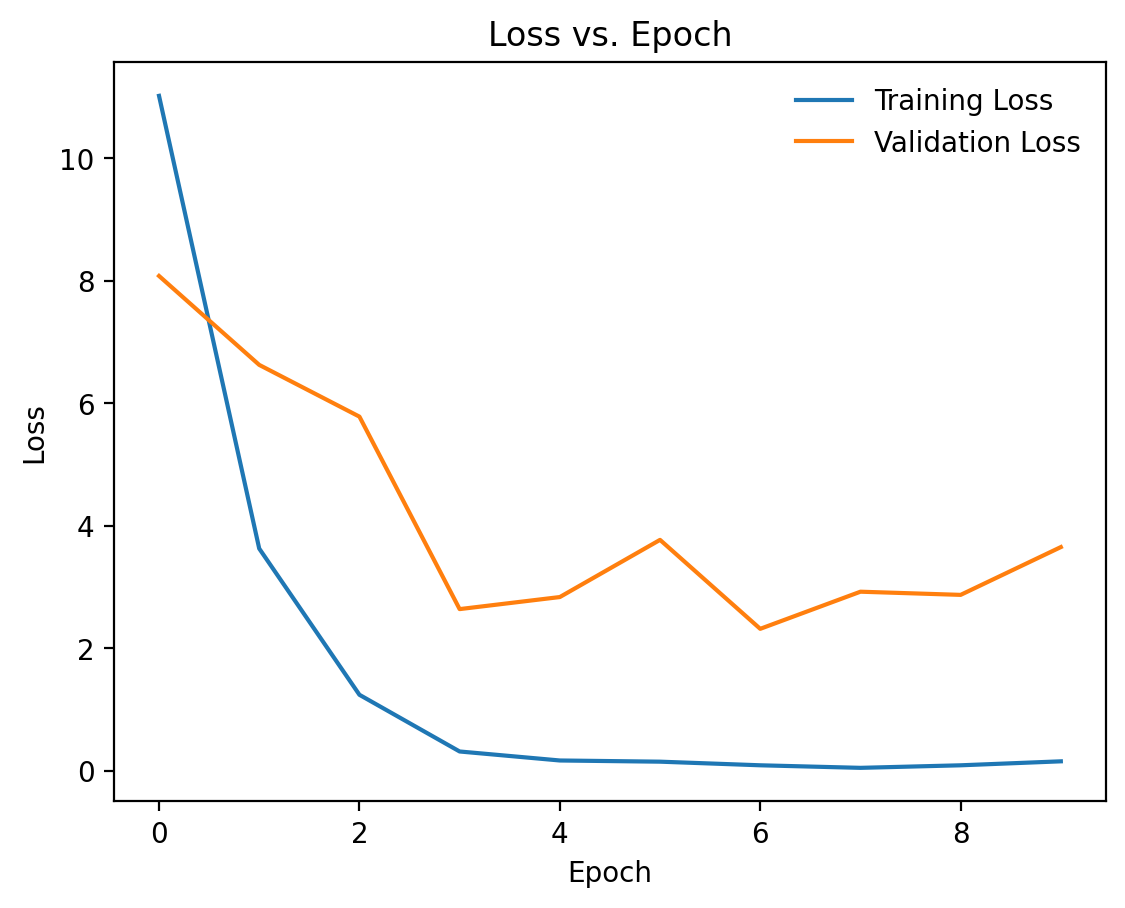

In [ ]:
agriculture_land_model = train_model6(agriculture_land_labels)
agriculture_land_model.save("/content/drive/MyDrive/saved_modelsNEW/agricultreNEW_model.h5")

urban_land_model = train_model6(urban_land_labels)
urban_land_model.save("/content/drive/MyDrive/saved_modelsNEW/urbanNEW_model.h5")

forest_land_model = train_model6(forest_land_labels)
forest_land_model.save("/content/drive/MyDrive/saved_modelsNEW/forestNEW_model.h5")



In [ ]:
def land_prediction(image_index, model):
    """
    Predicts the land type for a given image using the trained model.

    Arguments:
    - image_index: Index of the image to predict the land type for.
    - model: Trained CNN model for binary classification.

    Returns:
    - prediction: Predicted land type (1 for positive class, 0 for negative class).
    """
    # Read the image
    image = imageio.imread(meta['sat_image_path'][image_index])

    # Resize the input image
    resized_image = cv2.resize(image, (256, 256))

    # Expand dimensions to create a batch of size 1
    resized_image_batch = np.expand_dims(resized_image, axis=0)

    # Make predictions using the model
    test_prediction = model.predict(resized_image_batch, verbose=0)

    # Return the predicted land type (1 for positive class, 0 for negative class)
    if test_prediction > 0.5:
        return 1
    else:
        return 0


## Land types: How accurately does the model  identify seen images?





In [71]:
#loading in saved models
import os
from keras.models import load_model
load_dir = '/content/drive/MyDrive/saved_modelsNEW/'
land_types = ["barren", "water", "urban", "forest", "rangeland", "agriculture"]


# Load trained models
loaded_models = {}
for land_type in land_types:
  model_path = os.path.join(load_dir, f"{land_type}NEW_model.h5")
  loaded_models[land_type] = load_model(model_path)

In [ ]:
# Dictionary to hold predictions for each land type
predictions_dict_seen = {}

# Make predictions for each land type using its corresponding model
for land_type, model in loaded_models.items():
    predictions = []
    for i in tqdm(range(100), desc=f"Processing {land_type}"):
        result = land_prediction(i, model)
        predictions.append(result)

    predictions_array = np.array(predictions)
    predictions_dict_seen[land_type] = predictions_array



Processing agriculture: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


In [ ]:
# Initialize a dictionary to store percentage scores for each land type
DATAPOINTS = 100
# Define paths for each land type
land_types = {
    "barren": "/content/drive/MyDrive/LandTypes/barren_land.ipynb.npy",
    "water": "/content/drive/MyDrive/LandTypes/water.ipynb.npy",
    "urban": "/content/drive/MyDrive/LandTypes/urban_land.ipynb.npy",
    "forest": "/content/drive/MyDrive/LandTypes/forest_land.ipynb.npy",
    "rangeland": "/content/drive/MyDrive/LandTypes/rangeland.ipynb.npy",
    "agriculture": "/content/drive/MyDrive/LandTypes/agriculture_land.ipynb.npy",
}

percentage_scores = {}

# Loop through each land type
for land_type, path in land_types.items():
    # Load the land type labels
    land_type_labels = np.load(path)

    # Convert string array to integer array for land type labels
    land_type_labels_int_seen = land_type_labels[:DATAPOINTS].astype(int)

    # Get predictions array for the current land type
    predictions_array = predictions_dict_seen[land_type]

    # Convert predictions array to integer array
    predictions_array_int = predictions_array.astype(int)

    # Calculate the number of matching labels
    matching_labels = np.sum(predictions_array_int == land_type_labels_int_seen)

    # Calculate the percentage score
    percentage_score = (matching_labels / len(land_type_labels_int_seen)) * 100

    # Store the percentage score in the dictionary
    percentage_scores[land_type] = percentage_score

# Print the percentage scores for each land type
for land_type, score in percentage_scores.items():
    print(f"Percentage Score for {land_type}: {score:.2f}%")

Percentage Score for barren: 62.00%
Percentage Score for water: 78.00%
Percentage Score for urban: 79.00%
Percentage Score for forest: 86.00%
Percentage Score for rangeland: 83.00%
Percentage Score for agriculture: 96.00%


## Land types: How accurately does the model  identify unseen images?


In [ ]:
# Dictionary to hold predictions for each land type
predictions_dict_unseen = {}

# Make predictions for each land type using its corresponding model
for land_type, model in loaded_models.items():
    predictions = []
    for i in tqdm(range(700,803), desc=f"Processing {land_type}"):
        result = land_prediction(i, model)
        predictions.append(result)

    predictions_array = np.array(predictions)
    predictions_dict_unseen[land_type] = predictions_array

Processing agriculture: 100%|██████████| 103/103 [00:49<00:00,  2.09it/s]


In [ ]:
# Define paths for each land type
land_types = {
    "barren": "/content/drive/MyDrive/LandTypes/barren_land.ipynb.npy",
    "water": "/content/drive/MyDrive/LandTypes/water.ipynb.npy",
    "urban": "/content/drive/MyDrive/LandTypes/urban_land.ipynb.npy",
    "forest": "/content/drive/MyDrive/LandTypes/forest_land.ipynb.npy",
    "rangeland": "/content/drive/MyDrive/LandTypes/rangeland.ipynb.npy",
    "agriculture": "/content/drive/MyDrive/LandTypes/agriculture_land.ipynb.npy",
}

percentage_scores = {}

# Loop through each land type
for land_type, path in land_types.items():
    # Load the land type labels
    land_type_labels = np.load(path)

    # Convert string array to integer array for land type labels
    land_type_labels_int_unseen = land_type_labels[700:803].astype(int)

    # Get predictions array for the current land type
    predictions_array = predictions_dict_unseen[land_type]

    # Convert predictions array to integer array
    predictions_array_int = predictions_array.astype(int)

    # Calculate the number of matching labels
    matching_labels = np.sum(predictions_array_int == land_type_labels_int_unseen)

    # Calculate the percentage score
    percentage_score = (matching_labels / len(land_type_labels_int_unseen)) * 100

    # Store the percentage score in the dictionary
    percentage_scores[land_type] = percentage_score

# Print the percentage scores for each land type
for land_type, score in percentage_scores.items():
    print(f"Percentage Score for {land_type}: {score:.2f}%")

Percentage Score for barren: 54.37%
Percentage Score for water: 64.08%
Percentage Score for urban: 82.52%
Percentage Score for forest: 86.41%
Percentage Score for rangeland: 62.14%
Percentage Score for agriculture: 90.29%


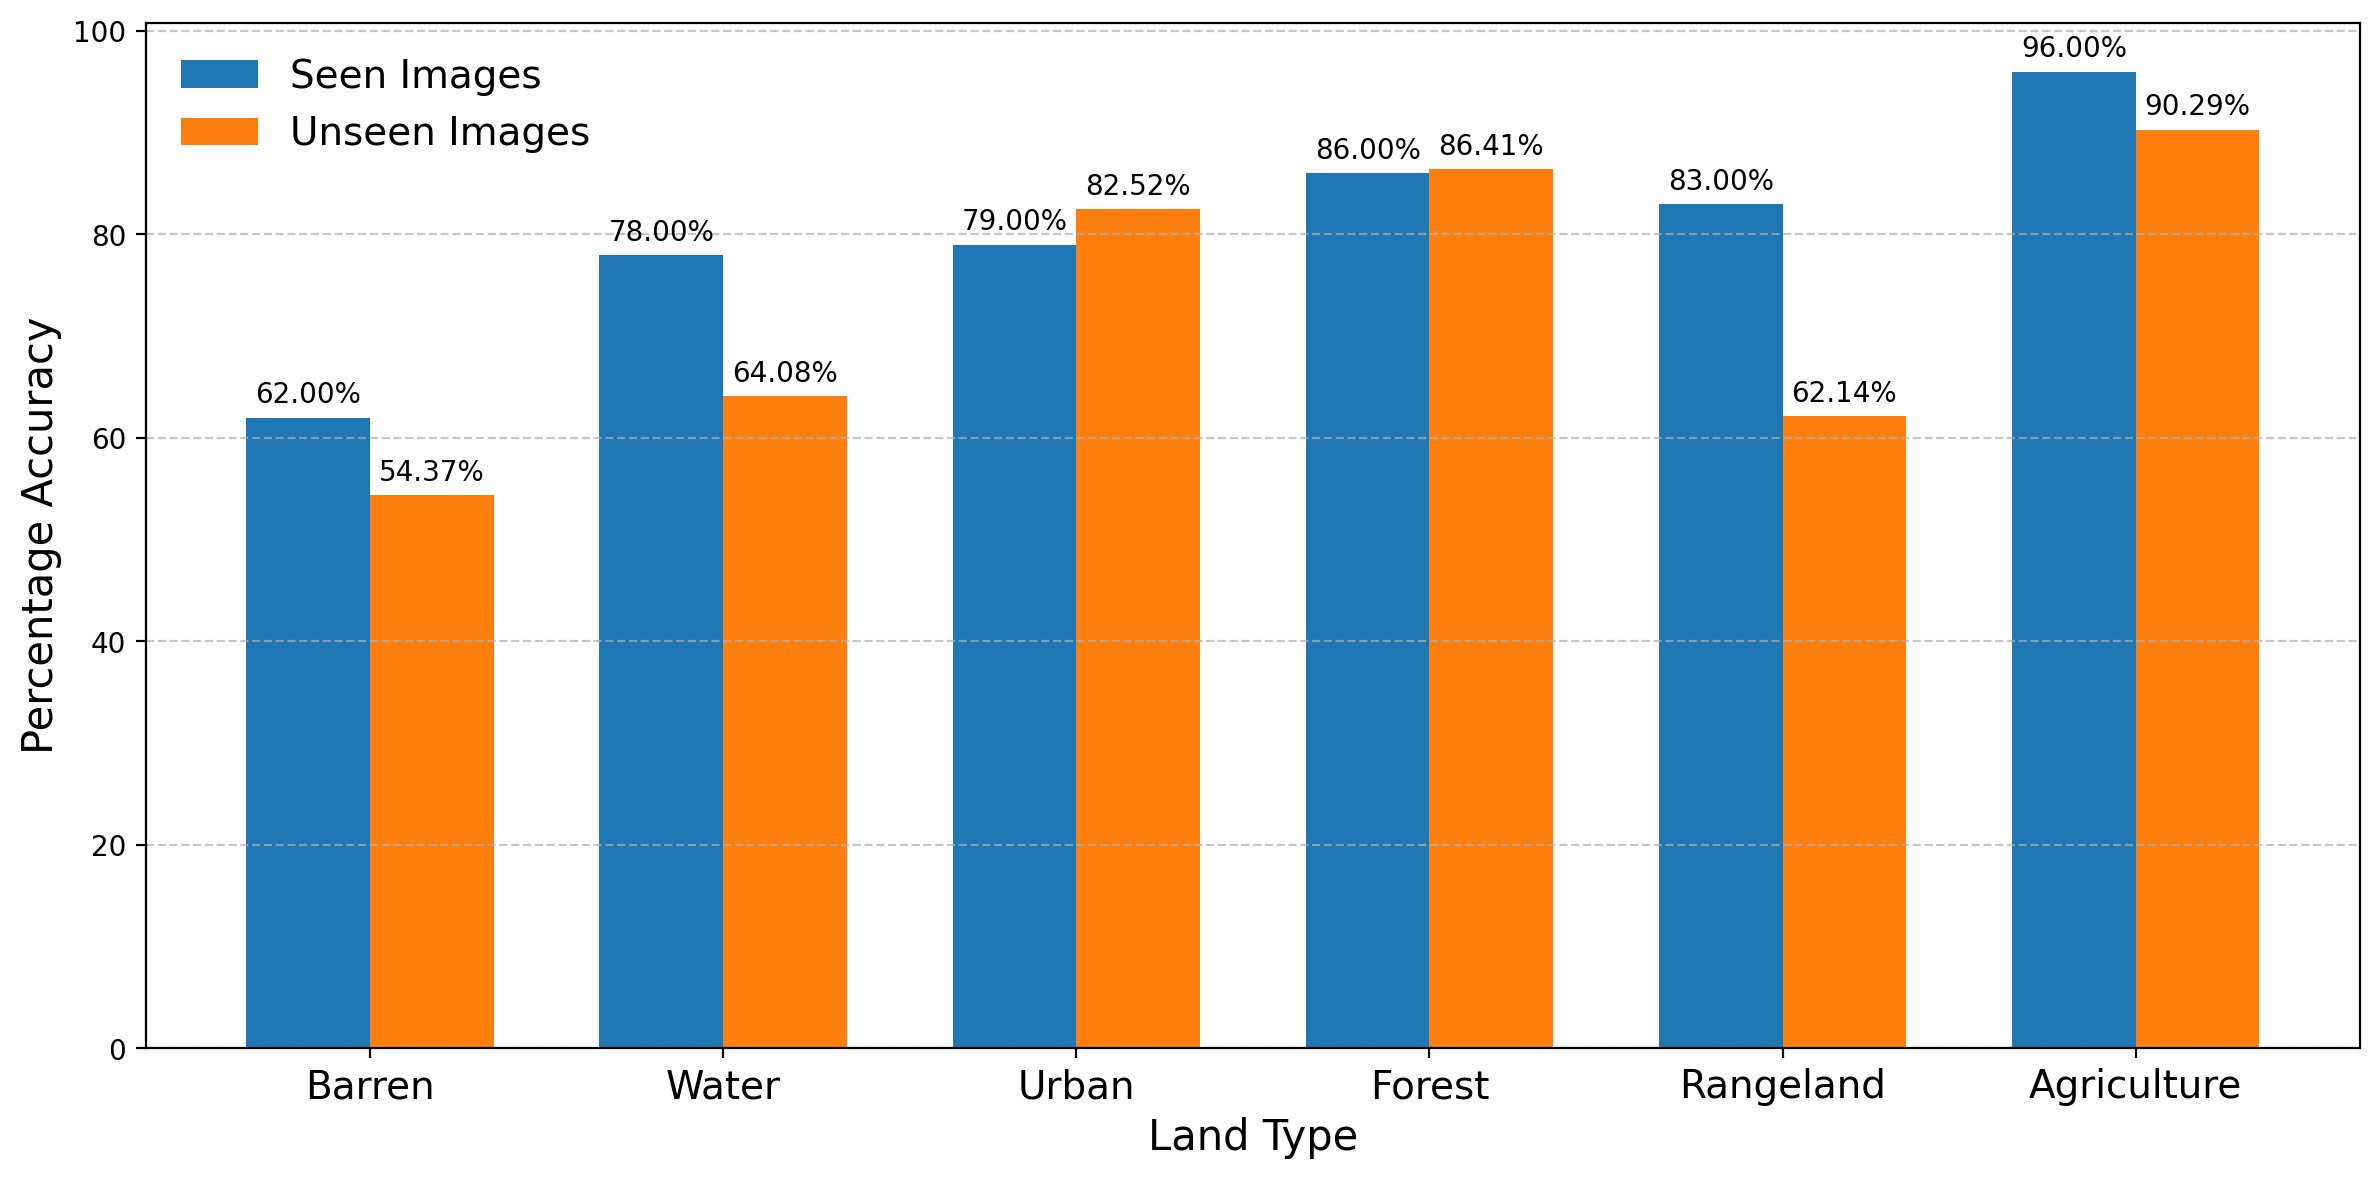

In [ ]:
import matplotlib.pyplot as plt

# Percentage scores for seen images
seen_scores = {
    "Barren": 62.00,
    "Water": 78.00,
    "Urban": 79.00,
    "Forest": 86.00,
    "Rangeland": 83.00,
    "Agriculture": 96.00,
}

# Percentage scores for unseen images
unseen_scores = {
    "Barren": 54.37,
    "Water": 64.08,
    "Urban": 82.52,
    "Forest": 86.41,
    "Rangeland": 62.14,
    "Agriculture": 90.29,
}

# Land types
land_types = list(seen_scores.keys())

# Seen and unseen scores
seen_percentages = [seen_scores[land_type] for land_type in land_types]
unseen_percentages = [unseen_scores[land_type] for land_type in land_types]

# Plot the bar graph
bar_width = 0.35
index = range(len(land_types))

plt.figure(figsize=(12, 6))
bars1 = plt.bar(index, seen_percentages, bar_width, label='Seen Images')
bars2 = plt.bar([i + bar_width for i in index], unseen_percentages, bar_width, label='Unseen Images')

plt.xlabel('Land Type', fontsize=15)
plt.ylabel('Percentage Accuracy', fontsize=15)
plt.xticks([i + bar_width / 2 for i in index], land_types, fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(bars):
    """
    Annotates the bars of a bar plot with their respective percentages.

    Arguments:
    - bars: List of bar objects representing the bars in the bar plot.
    """
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom', fontsize=10)

# Annotating bars with percentages
autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()




## Percentage scores for true positives:

In [ ]:
percentage_scores = {}

# Loop through each land type
for land_type, path in land_types.items():
    # Load the land type labels
    land_type_labels = np.load(path)

    # Convert string array to integer array for land type labels
    land_type_labels_int_unseen = land_type_labels[700:803].astype(int)

    # Get predictions array for the current land type
    predictions_array = predictions_dict_unseen[land_type]

    # Convert predictions array to integer array
    predictions_array_int = predictions_array.astype(int)

    # Count the number of true positives (predicted 1's that match true 1 labels)
    true_positives = np.sum((predictions_array_int == 1) & (land_type_labels_int_unseen == 1))

    # Count the total number of true labels (true 1's)
    total_true_labels = np.sum(land_type_labels_int_unseen == 1)

    # Calculate the percentage of true positives among true labels
    percentage_score = (true_positives / total_true_labels) * 100

    # Store the percentage score in the dictionary
    percentage_scores[land_type] = percentage_score

# Print the percentage scores for each land type
for land_type, score in percentage_scores.items():
    print(f"Percentage Score for {land_type}: {score:.2f}%")

Percentage Score for barren: 20.37%
Percentage Score for water: 84.38%
Percentage Score for urban: 100.00%
Percentage Score for forest: 41.67%
Percentage Score for rangeland: 95.31%
Percentage Score for agriculture: 98.90%


## Percentage scores for true negatives:

In [ ]:
percentage_scores = {}

# Loop through each land type
for land_type, path in land_types.items():
    # Load the land type labels
    land_type_labels = np.load(path)

    # Convert string array to integer array for land type labels
    land_type_labels_int_unseen = land_type_labels[700:803].astype(int)

    # Get predictions array for the current land type
    predictions_array = predictions_dict_unseen[land_type]

    # Convert predictions array to integer array
    predictions_array_int = predictions_array.astype(int)

    # Count the number of true negatives (predicted 0's that match true 0 labels)
    true_negatives = np.sum((predictions_array_int == 0) & (land_type_labels_int_unseen == 0))

    # Count the total number of true labels (true 0's)
    total_true_labels = np.sum(land_type_labels_int_unseen == 0)

    # Calculate the percentage of true negatives among true labels
    percentage_score = (true_negatives / total_true_labels) * 100

    # Store the percentage score in the dictionary
    percentage_scores[land_type] = percentage_score

# Print the percentage scores for each land type
for land_type, score in percentage_scores.items():
    print(f"Percentage Score for {land_type}: {score:.2f}%")


Percentage Score for barren: 91.84%
Percentage Score for water: 30.77%
Percentage Score for urban: 10.00%
Percentage Score for forest: 100.00%
Percentage Score for rangeland: 7.69%
Percentage Score for agriculture: 25.00%


## Investigating how imbalanced datasets effects image classification results:

The plot suggests a positive relationship between the percentage accuracy of true positives and the frequency of the corresponding land types. Conversely, the percentage accuracy of true negatives exhibits a decreasing trend with increasing land type frequency.

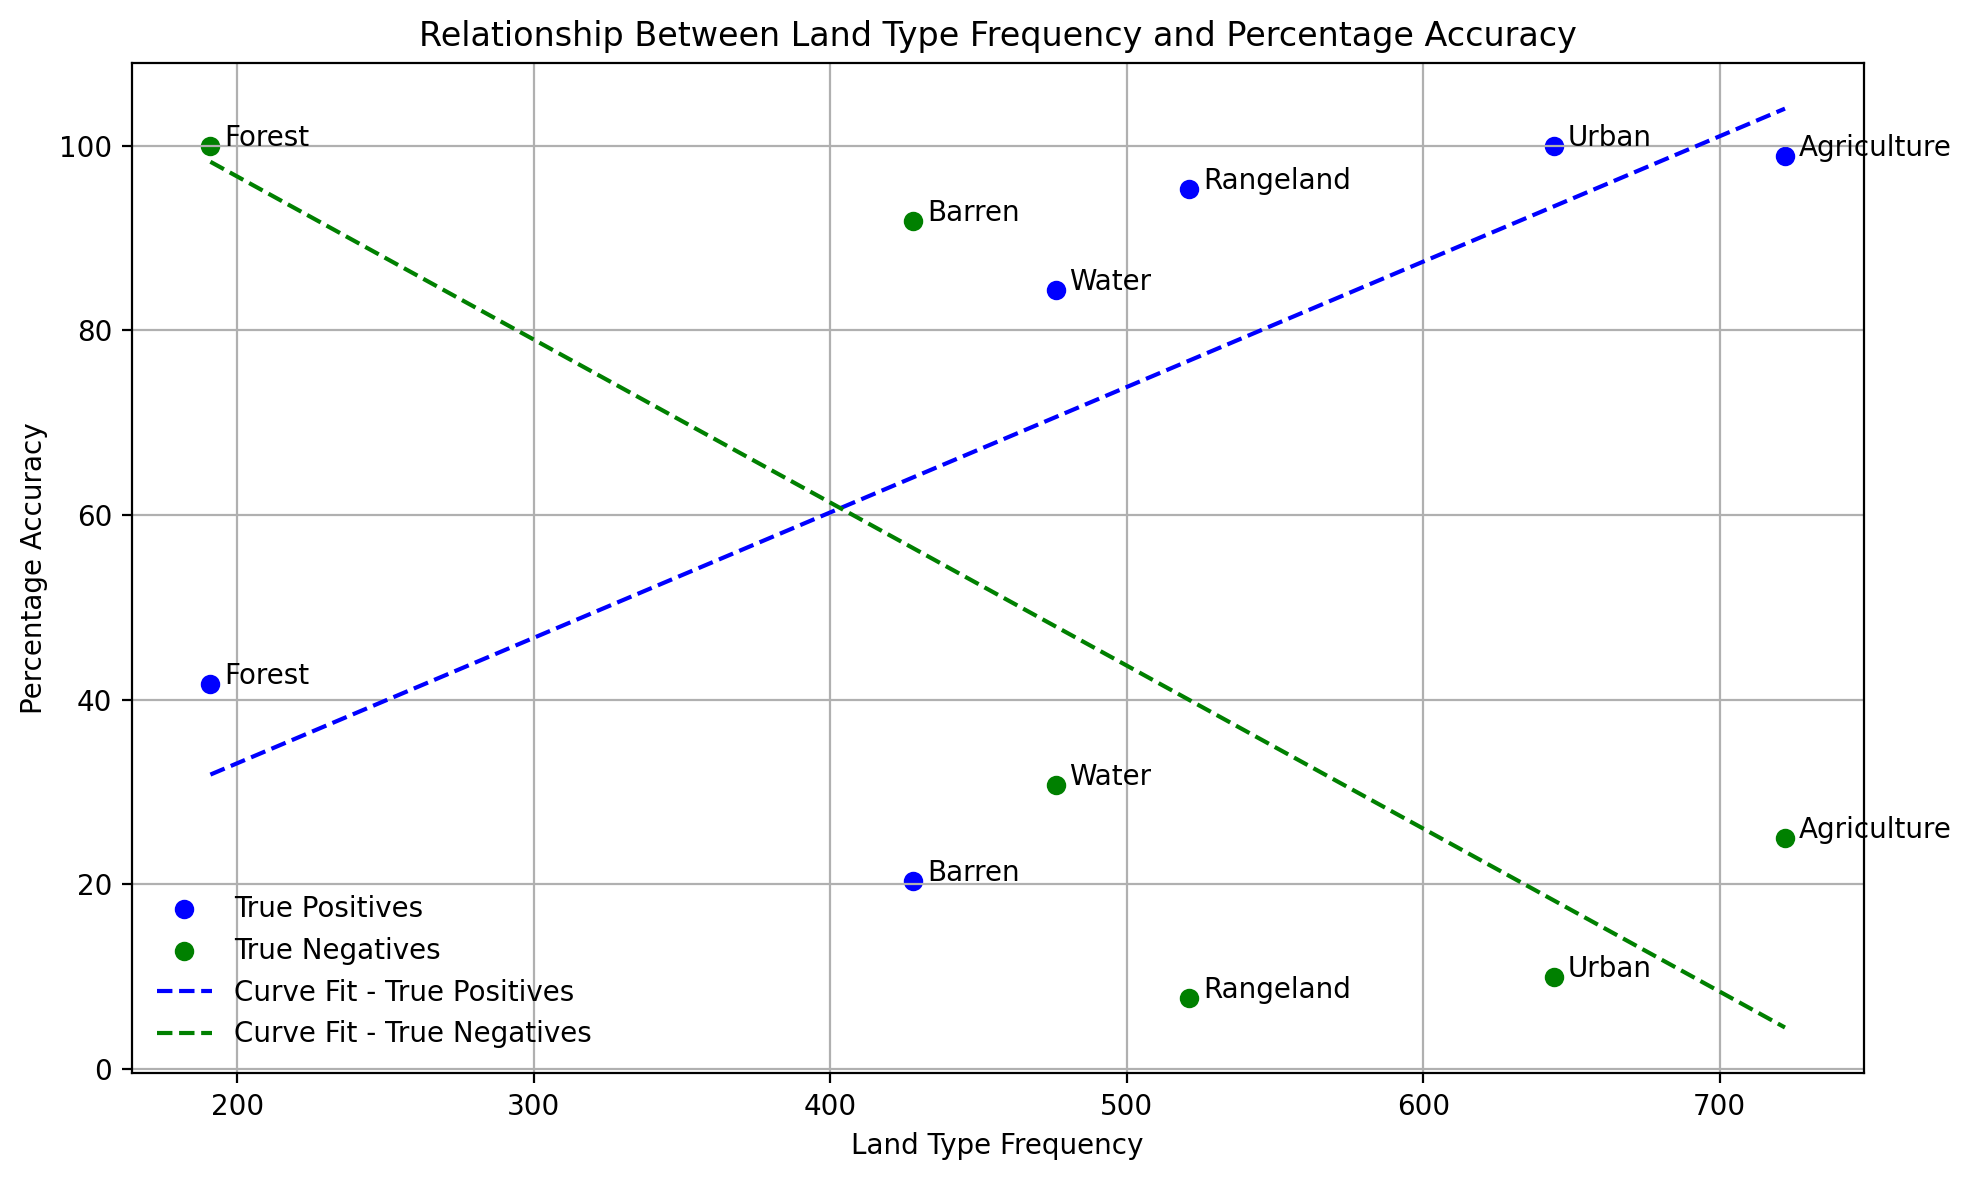

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Count occurrences of each land type in training images
land_types = ['Barren', 'Water', 'Urban', 'Forest', 'Rangeland', 'Agriculture']

# Provided percentage scores for true positives
percentage_scores_true_positives = {
    'Barren': 20.37,
    'Water': 84.38,
    'Urban': 100.00,
    'Forest': 41.67,
    'Rangeland': 95.31,
    'Agriculture': 98.90
}

# Provided percentage scores for true negatives
percentage_scores_true_negatives = {
    'Barren': 91.84,
    'Water': 30.77,
    'Urban': 10.00,
    'Forest': 100.00,
    'Rangeland': 7.69,
    'Agriculture': 25.00
}

# Gather percentage scores for true positives and true negatives
true_positives = [percentage_scores_true_positives[land_type] for land_type in land_types]
true_negatives = [percentage_scores_true_negatives[land_type] for land_type in land_types]

# Count occurrences of each land type
land_type_counts = [np.sum(labels) for labels in land_type_labels]

# Fit 2nd degree polynomial for true positives
poly_true_positives = Polynomial.fit(land_type_counts, true_positives, 1)

# Fit 2nd degree polynomial for true negatives
poly_true_negatives = Polynomial.fit(land_type_counts, true_negatives, 1)

# Generate points along the curves
x_values = np.linspace(min(land_type_counts), max(land_type_counts), 100)
y_values_true_positives = poly_true_positives(x_values)
y_values_true_negatives = poly_true_negatives(x_values)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(land_type_counts, true_positives, color='blue', label='True Positives')
plt.scatter(land_type_counts, true_negatives, color='green', label='True Negatives')

plt.plot(x_values, y_values_true_positives, color='blue', linestyle='--', label='Curve Fit - True Positives')
plt.plot(x_values, y_values_true_negatives, color='green', linestyle='--', label='Curve Fit - True Negatives')

plt.title('Relationship Between Land Type Frequency and Percentage Accuracy')
plt.xlabel('Land Type Frequency')
plt.ylabel('Percentage Accuracy')

# Adding annotations for each point
for i, land_type in enumerate(land_types):
    plt.annotate(land_type, (land_type_counts[i], true_positives[i]), textcoords="offset points", xytext=(5,0), ha='left')
    plt.annotate(land_type, (land_type_counts[i], true_negatives[i]), textcoords="offset points", xytext=(5,0), ha='left')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Convert land_type_counts to NumPy array
land_type_counts_np = np.array(land_type_counts)

# Calculate R-squared for true positives and true negatives fits
r2_true_positives = r2_score(true_positives, poly_true_positives(land_type_counts_np))
r2_true_negatives = r2_score(true_negatives, poly_true_negatives(land_type_counts_np))

print(f"R-squared for True Positives Fit: {r2_true_positives:.4f}")
print(f"R-squared for True Negatives Fit: {r2_true_negatives:.4f}")


R-squared for True Positives Fit: 0.5480
R-squared for True Negatives Fit: 0.6343


The R-squared score measures how well the independent variables explain the variability of the dependent variable in a regression model. A higher R-squared value indicates a better fit, showing that the independent variables can explain more of the variance in the dependent variable:

## TASK 2:
Develop a machine learning algorithm that can determine the fraction of each class that is present in the image (e.g. what fraction of pixels are Urban vs Agricultutal etc.)

In [ ]:

# Define the colors corresponding to each land type
land_type_colors = {
    'urban_land': [255, 255, 0],
    'agriculture_land': [0, 255, 255],
    'rangeland': [255, 0, 255],
    'forest_land': [0, 255, 0],
    'water': [255, 0, 0],
    'barren_land': [255, 255, 255],
}

# Initialize empty lists to store land type fractions
land_type_fractions = []

DATAPOINTS = 803

# Create a tqdm progress bar for the loop
for i in tqdm(range(DATAPOINTS), desc='Processing Images'):
    # Construct the file paths for the current iteration
    mask_path = meta.loc[i, 'mask_path']

    target_size = (256, 256)  # Set your desired size

    # Read the mask image
    mask_image = cv2.imread(mask_path)  # Assuming the masks are grayscale
    mask_image = cv2.resize(mask_image, target_size)

    # Calculate the total number of pixels in the mask image
    total_pixels = mask_image.shape[0] * mask_image.shape[1]

    # Calculate the fraction of each land type in the image
    land_type_fraction = []
    for land_type in land_type_colors:
        pixels_of_type = np.sum(np.all(mask_image == land_type_colors[land_type], axis=-1))
        fraction = pixels_of_type / total_pixels
        land_type_fraction.append(fraction)

    # Append the list containing land type fractions to the list
    land_type_fractions.append(land_type_fraction)

# Convert the list of lists to a numpy array
land_type_fractions = np.array(land_type_fractions)

file_path = '/content/drive/MyDrive/LandTypeFractionsNEW.npy'

np.save(file_path, land_type_fractions)

Processing Images: 100%|██████████| 803/803 [01:16<00:00, 10.54it/s]


In [ ]:
DATAPOINTS = 700

#TRAINING IMAGES
training_image_path = '/content/drive/MyDrive/Mini_Project /training_images.ipynb.npy'
training_images = np.load(training_image_path)[:DATAPOINTS]

#TRAINING LABELS
land_type_fraction_path = '/content/drive/MyDrive/LandTypeFractionsNEW.npy'
land_type_fraction_label = np.load(land_type_fraction_path)[:DATAPOINTS]

## Model 1 :

This model overfits the data, but produced a high accuracy of 90%

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 254, 254, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)         0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 125, 125, 64)         18496     ['max_pooling2d_3[0][0]'

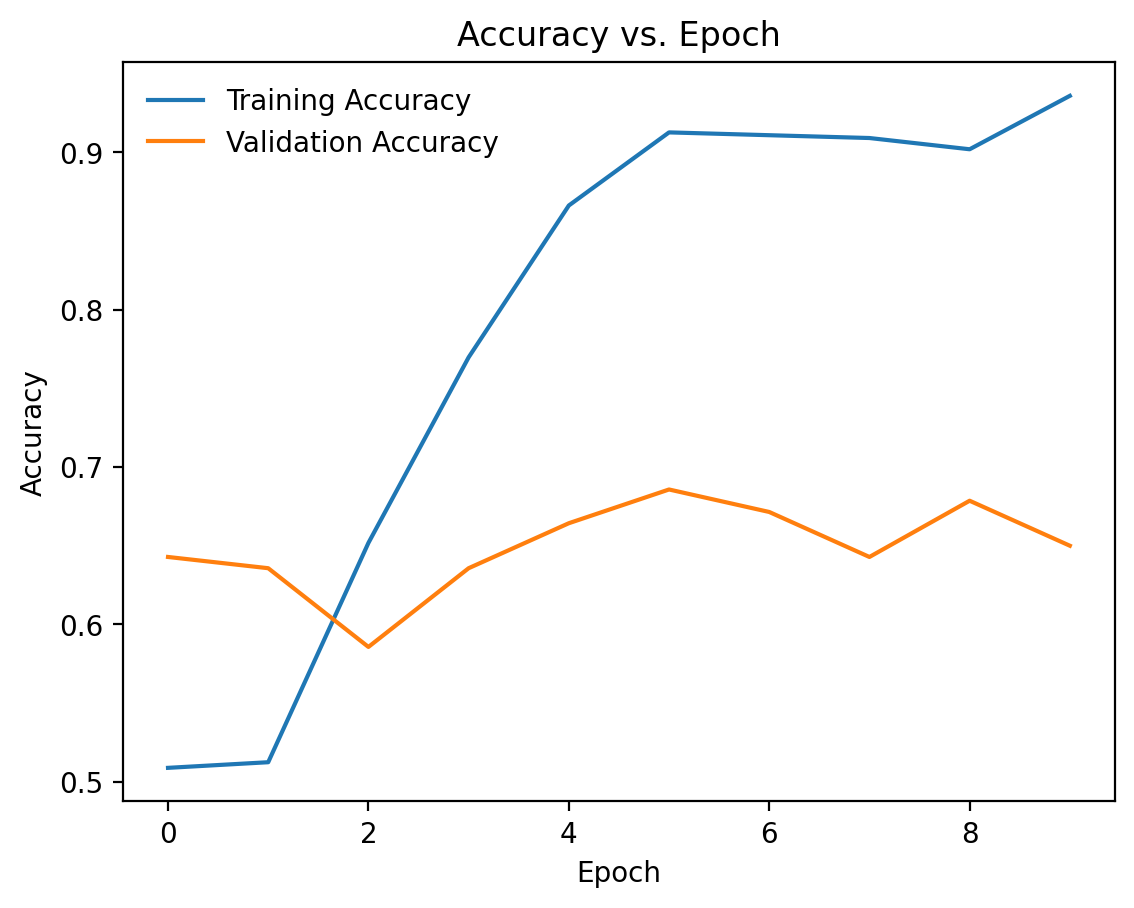

In [ ]:

# Define Inception module
def inception_module(layer_in, k1, k3, k5, kp):
    # 1x1 conv
    conv1 = Conv2D(k1, (1,1), padding='same', activation='relu')(layer_in)

    # 3x3 conv
    conv3 = Conv2D(k3, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(k3, (3,3), padding='same', activation='relu')(conv3)

    # 5x5 conv
    conv5 = Conv2D(k5, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(k5, (5,5), padding='same', activation='relu')(conv5)

    # Pooling
    convp = MaxPooling2D((2,2), strides = 1, padding='same')(layer_in)
    convp = Conv2D(kp, (1,1), padding='same', activation='relu')(convp)

    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, convp], axis=-1)

    return layer_out

# Sample data loading and splitting
# Replace this with your actual data loading code
X_train, X_test, y_train, y_test = train_test_split(training_images, land_type_fraction_label, test_size=0.2, random_state=42)

# Input branch
inputs = Input(shape=(256, 256, 3))  # Update input shape

# First Convolutional layer
conv1 = Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3))(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)

# Second Convolutional layer
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)

# Inception layer
incp1 = inception_module(pool2, 64, 96, 16, 32)

# Flatten layer
flatn = Flatten()(incp1)

# Fully connected Neural Network
dens1 = Dense(128, activation='relu')(flatn)
dens2 = Dense(64, activation='relu')(dens1)

# Output layer
output_layer = Dense(6, activation='sigmoid')(dens2)

# Create model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Plot accuracy vs. epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()


## Model 2:

I revised the model architecture, incorporating batch normalization and dropout layers to address overfitting.

Furthermore, I switched to 'softmax' activation and 'categorical_crossentropy' loss to better suit the multi-class nature of the data.

Results: The model demonstrates improvement, with reduced overfitting evident in the closely matching validation and accuracy curves.

However, regardless of this, the model failed to produce acccurate label predictions for seen and unseen data.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 127, 127, 16)      64        
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)       

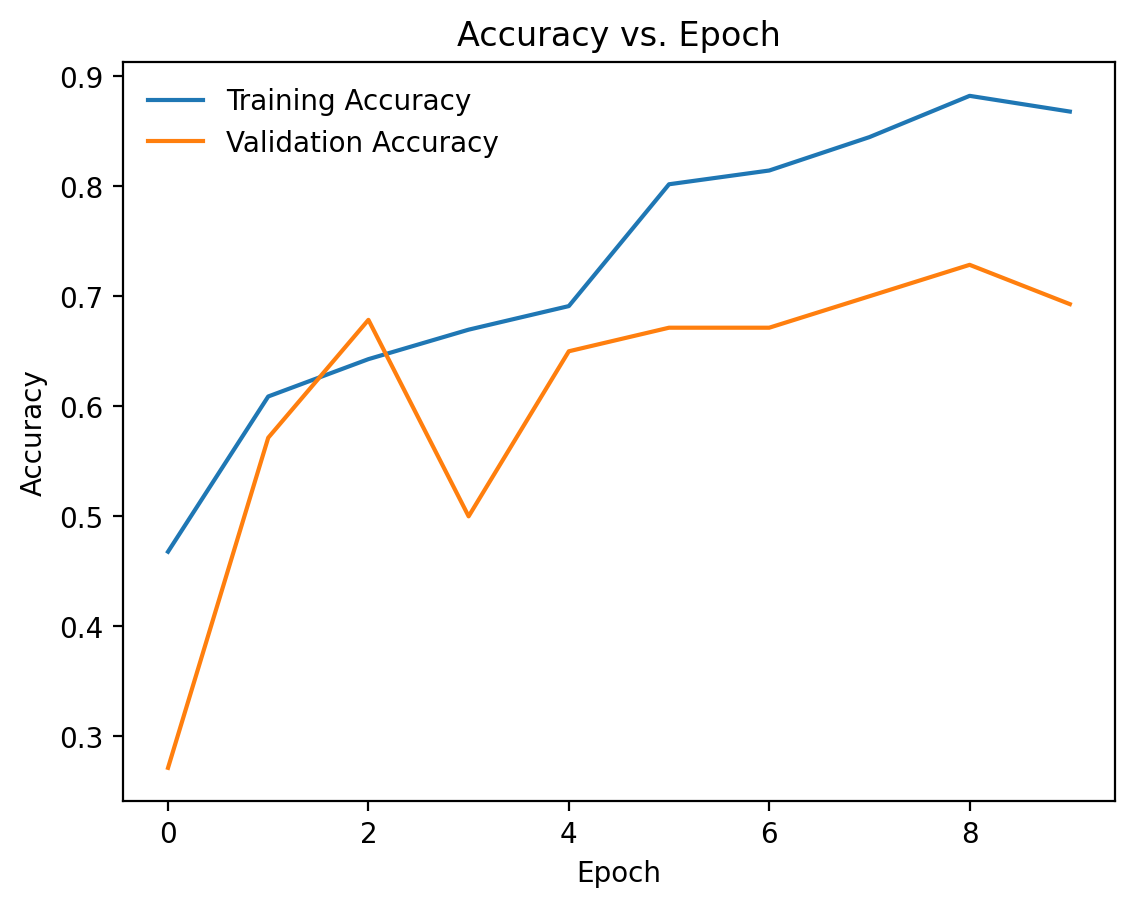

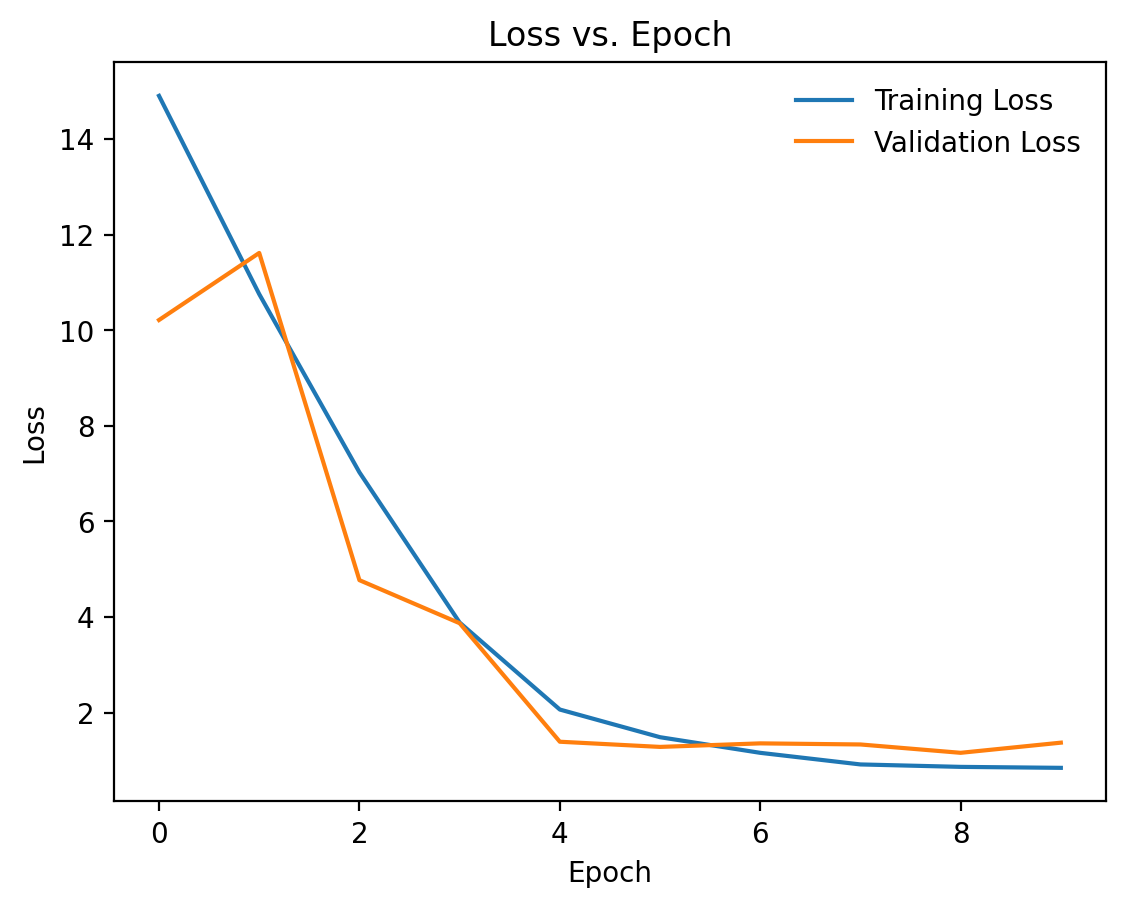

In [ ]:

# Define the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(X_train, y_train, batch_size=10,
                    epochs=10,
                    validation_data=(X_test, y_test))

# Plot accuracy vs. epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Plot loss vs. epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()


## Model 3:

I opted for a pretrained model, ResNet50, due to the observed improvement in data performance with larger CNN models.

This model yielded the best label predictions, boasting a high accuracy of 90% and a loss of 0.74.

Epoch 1/12
23/23 [==============================] - 216s 9s/step - loss: 1.2706 - accuracy: 0.6768 - val_loss: 1.0086 - val_accuracy: 0.7786
Epoch 2/12
23/23 [==============================] - 199s 9s/step - loss: 0.9527 - accuracy: 0.8071 - val_loss: 0.9095 - val_accuracy: 0.8500
Epoch 3/12
23/23 [==============================] - 165s 7s/step - loss: 0.8825 - accuracy: 0.8339 - val_loss: 0.8662 - val_accuracy: 0.8857
Epoch 4/12
23/23 [==============================] - 164s 7s/step - loss: 0.8373 - accuracy: 0.8589 - val_loss: 0.8561 - val_accuracy: 0.8857
Epoch 5/12
23/23 [==============================] - 153s 7s/step - loss: 0.8252 - accuracy: 0.8714 - val_loss: 0.8420 - val_accuracy: 0.9000
Epoch 6/12
23/23 [==============================] - 161s 7s/step - loss: 0.8105 - accuracy: 0.8821 - val_loss: 0.8167 - val_accuracy: 0.8714
Epoch 7/12
23/23 [==============================] - 152s 7s/step - loss: 0.7903 - accuracy: 0.8911 - val_loss: 0.8061 - val_accuracy: 0.8929
Epoch 8/12
23

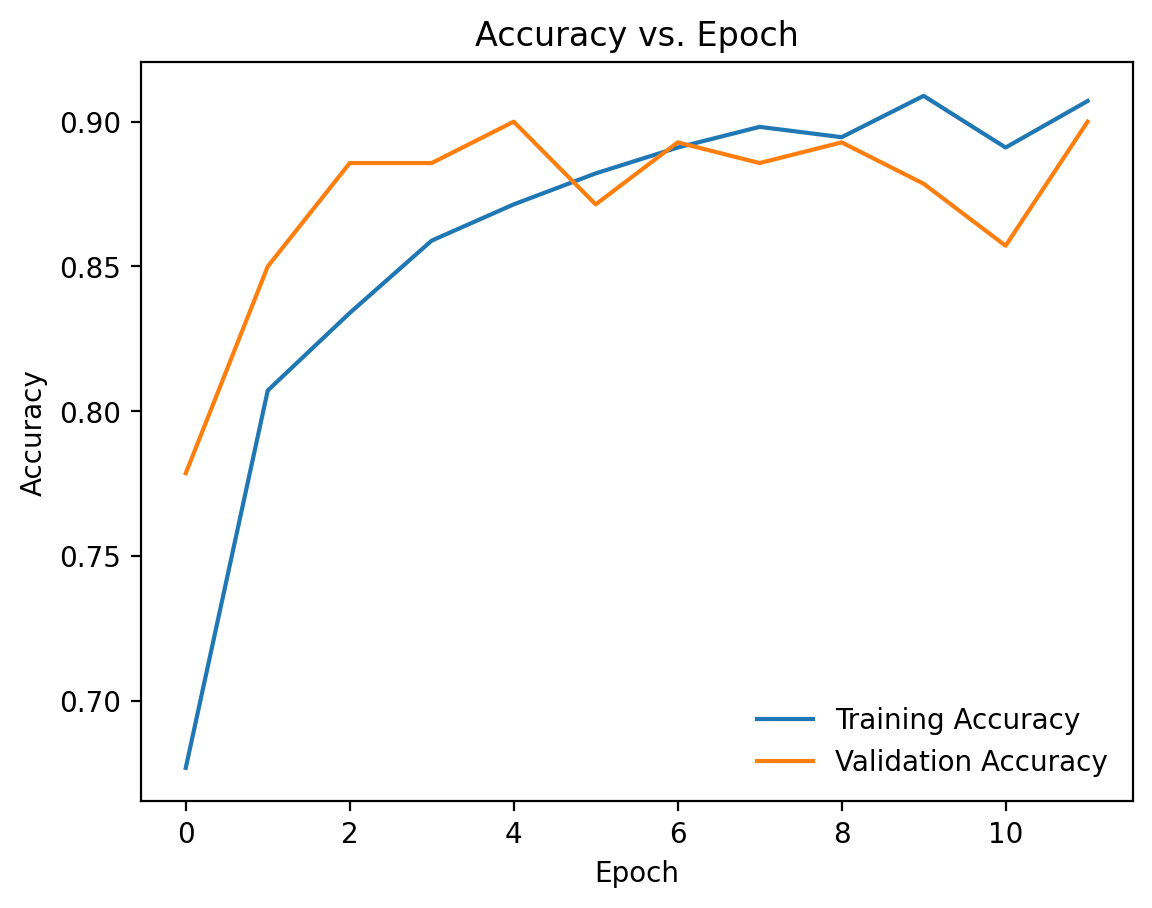

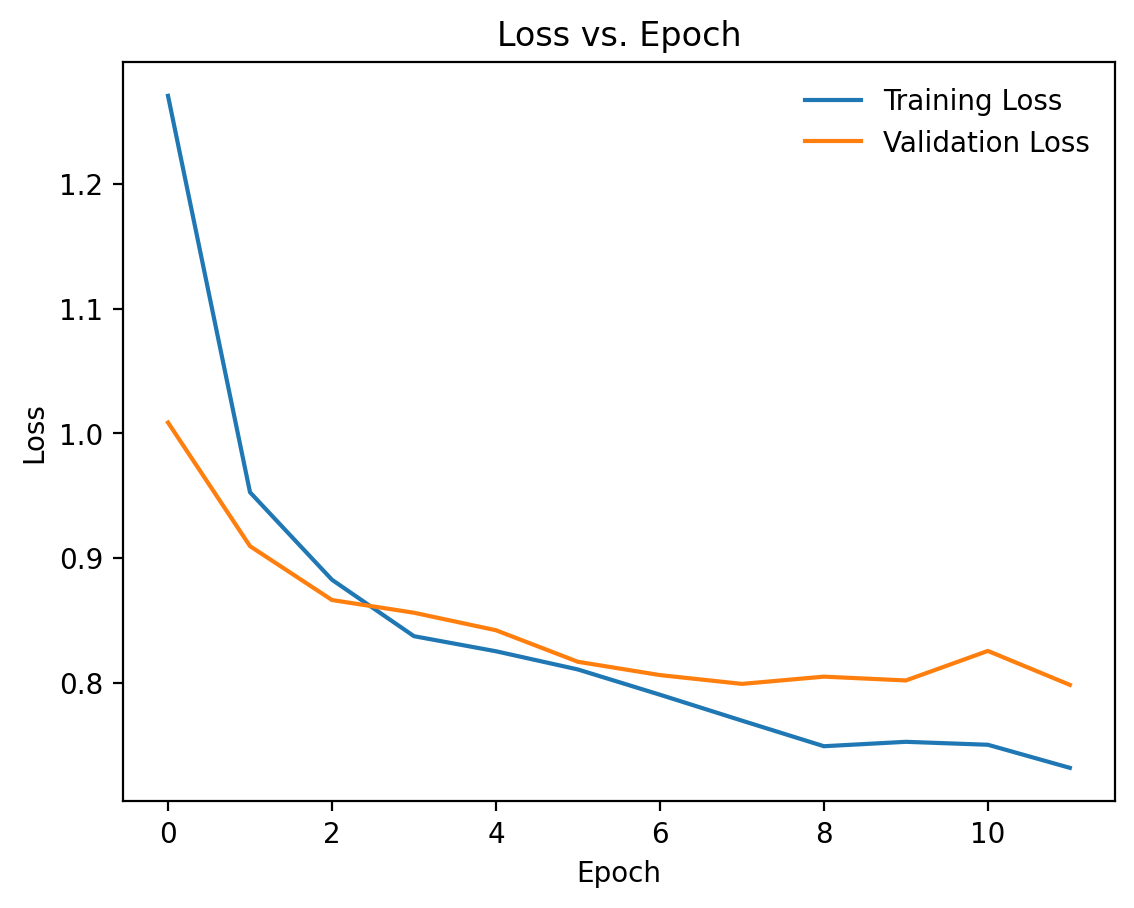

In [ ]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_images, land_type_fraction_label, test_size=0.2, random_state=42)

# Load ResNet50 model without including the top layer (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Define top layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Freeze the layers of the ResNet50 base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with class weights
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(X_train, y_train, batch_size=25, epochs=12, validation_data=(X_test, y_test))

# Plot accuracy vs. epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

# Plot loss vs. epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/land_type_fraction_model3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predictions on seen images

In [ ]:
DATAPOINTS = 100
#TRAINING IMAGES
training_image_path = '/content/drive/MyDrive/Mini_Project /training_images.ipynb.npy'
training_images_seen = np.load(training_image_path)[:DATAPOINTS]

# Define the land type labels
land_type_fraction_label_seen = np.load('/content/drive/MyDrive/LandTypeFractionsNEW.npy')[:DATAPOINTS]

In [ ]:
from keras.models import load_model
# Load the saved model and name it as LandtypeFraction model
LandtypeFraction_model_seen = load_model("/content/drive/MyDrive/land fraction models/land_type_fraction_model3.h5")

# Now, you can use the LandtypeFraction_model for predictions or any other tasks

# Initialize an array to store predicted land type fractions for all 100 images
all_predictions_seen = []

# Predict land type fractions for all 100 images
for input_image in tqdm(training_images_seen, desc='Processing Images'):
    # Reshape the single image to match the expected input shape of the model
    input_image = np.expand_dims(input_image, axis=0)  # Add a batch dimension

    # Predict using the reshaped input image
    predictions_seen = LandtypeFraction_model_seen.predict(input_image, verbose=0)

    # Append the predictions to the array after converting to decimal format
    all_predictions_seen.append(predictions_seen.astype(float))

np.set_printoptions(precision=6, suppress=True)

# Convert the list of predictions to a numpy array
all_predictions_seen = np.array(all_predictions_seen)


Processing Images: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


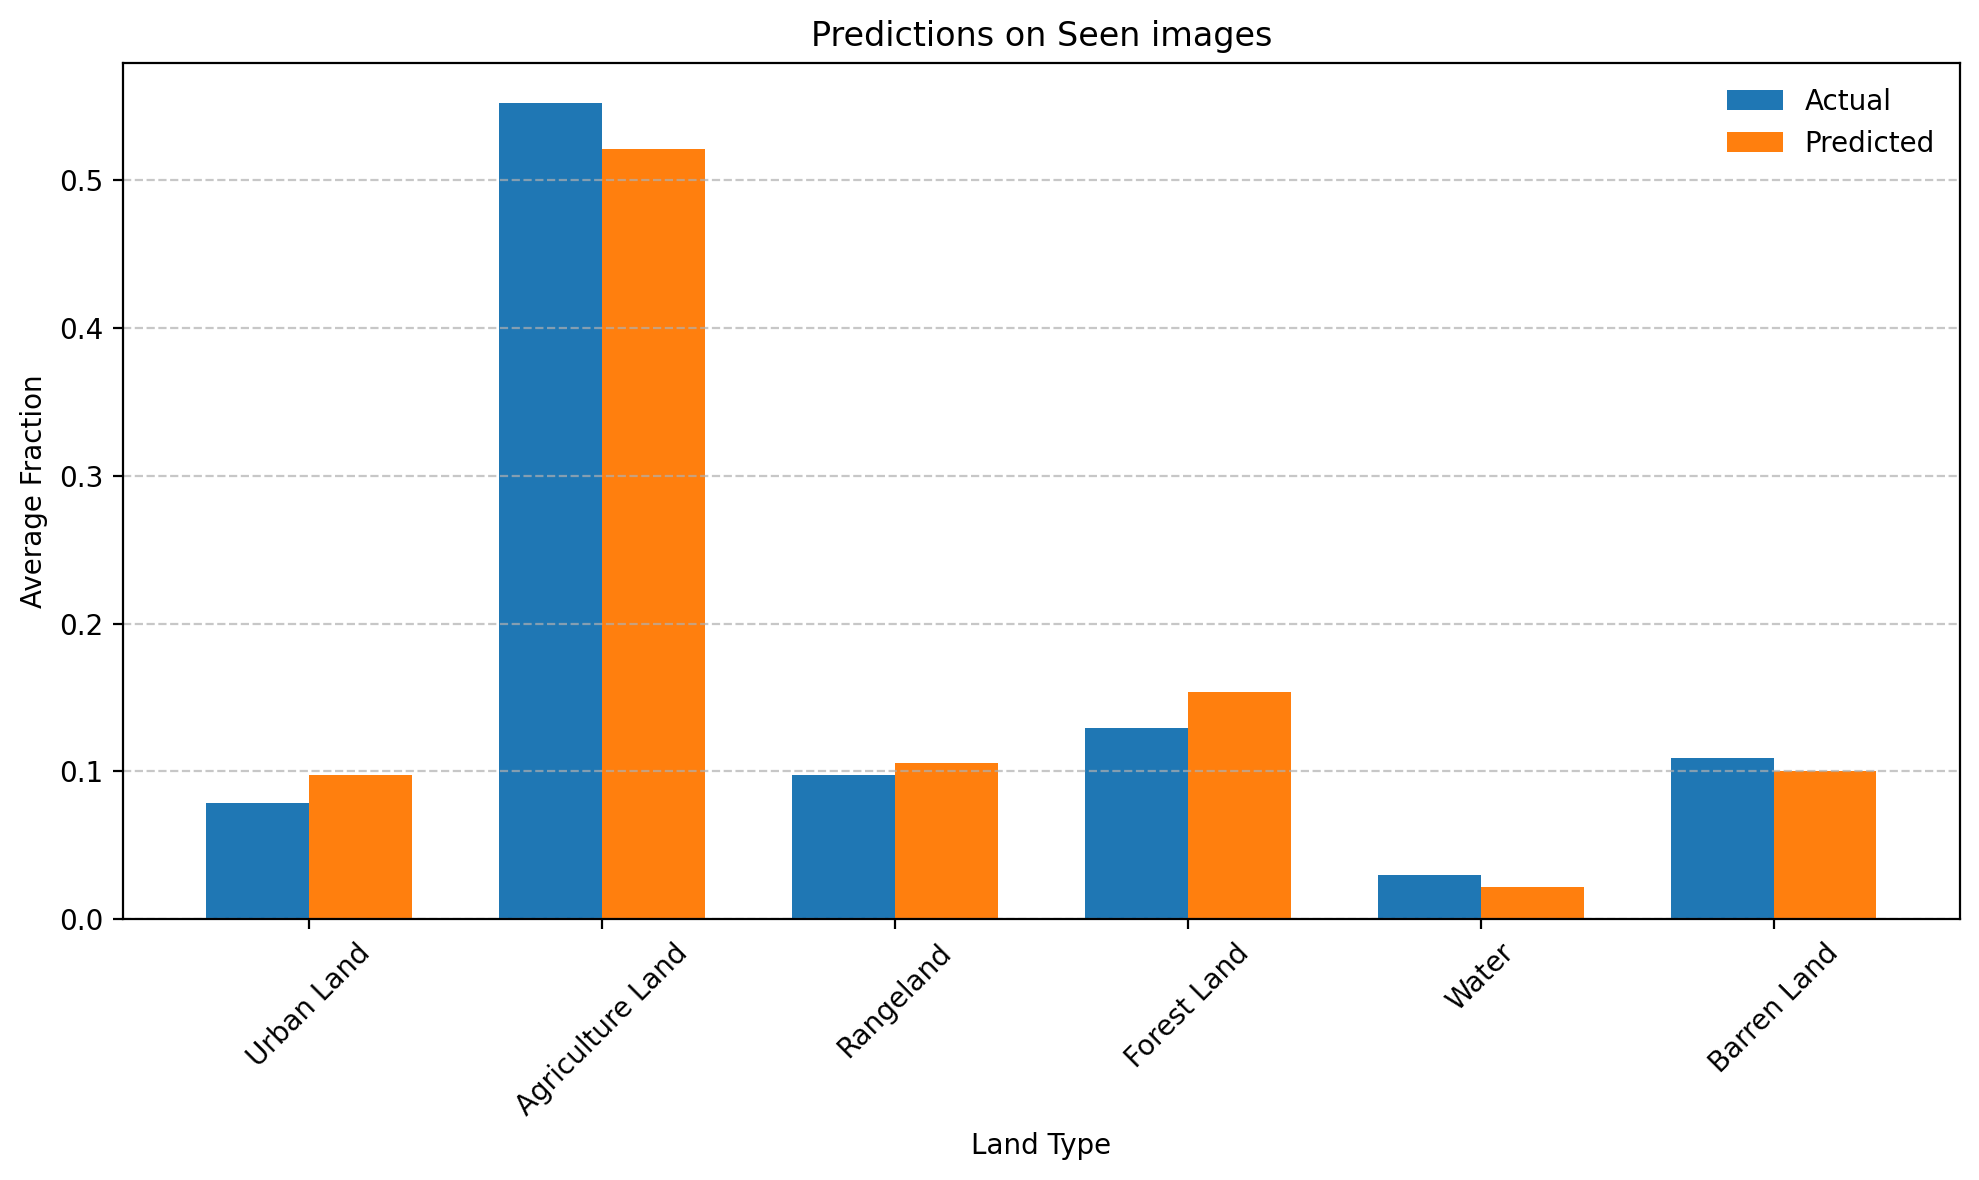

In [ ]:
# Calculate the average value for each land type
average_values_seen = np.mean(land_type_fraction_label_seen, axis=0)
average_values2_seen = np.mean(all_predictions_seen, axis=0)

# Land type labels
land_type_labels = ['Urban Land', 'Agriculture Land', 'Rangeland', 'Forest Land', 'Water', 'Barren Land']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(land_type_labels))

plt.bar(index, average_values_seen, bar_width, label='Actual')
plt.bar(index + bar_width, average_values2_seen[0], bar_width, label='Predicted')

plt.title('Predictions on Seen images')
plt.xlabel('Land Type')
plt.ylabel('Average Fraction')
plt.xticks(index + bar_width / 2, land_type_labels, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the percentage accuracy
percentage_accuracy_seen = (1-np.abs((average_values2_seen - average_values_seen) / average_values_seen)) * 100

print(percentage_accuracy_seen)

[[76.293739 94.361623 91.791555 81.148516 73.817556 92.135845]]


## Predictions on unseen images:

In [ ]:
#TRAINING IMAGES
training_image_path = '/content/drive/MyDrive/Mini_Project /training_images.ipynb.npy'
training_images_unseen = np.load(training_image_path)[700:803]

#TRAINING LABELS
land_type_fraction_path = '/content/drive/MyDrive/LandTypeFractionsNEW.npy'
land_type_fraction_label_unseen = np.load(land_type_fraction_path, allow_pickle=True)[700:803]

In [ ]:
# Load the saved model and name it as LandtypeFraction model
LandtypeFraction_model_unseen = load_model("/content/drive/MyDrive/land fraction models/land_type_fraction_model3.h5")

# Now, you can use the LandtypeFraction_model for predictions or any other tasks

# Initialize an array to store predicted land type fractions for all 100 images
all_predictions_unseen = []

# Predict land type fractions for all 100 images
for input_image in tqdm(training_images_unseen, desc='Processing Images'):
    # Reshape the single image to match the expected input shape of the model
    input_image = np.expand_dims(input_image, axis=0)  # Add a batch dimension

    # Predict using the reshaped input image
    predictions_unseen = LandtypeFraction_model_unseen.predict(input_image, verbose=0)

    # Append the predictions to the array after converting to decimal format
    all_predictions_unseen.append(predictions_unseen)

np.set_printoptions(precision=6, suppress=True)

# Convert the list of predictions to a numpy array
all_predictions_unseen = np.array(all_predictions_unseen)


Processing Images: 100%|██████████| 103/103 [00:46<00:00,  2.20it/s]


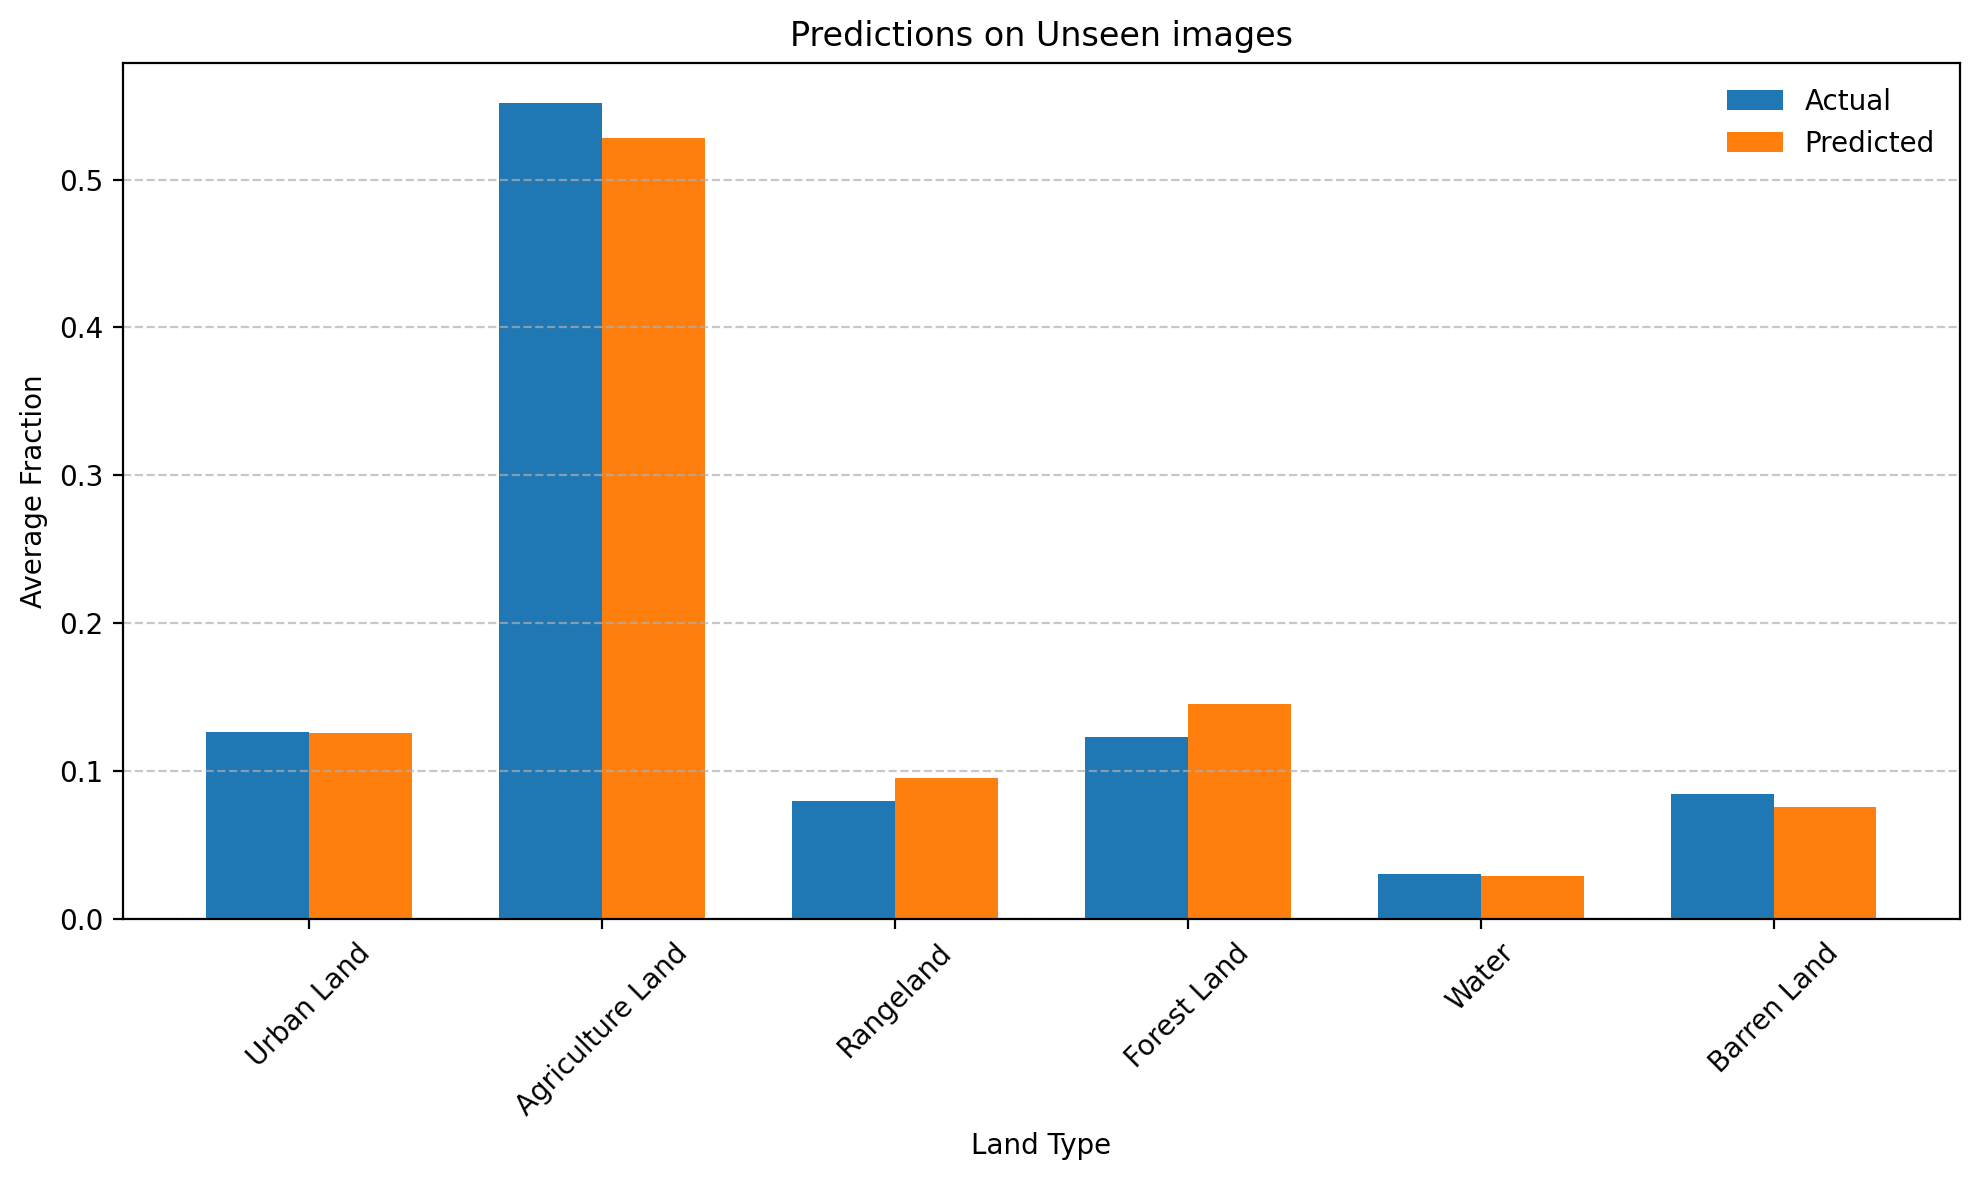

In [ ]:
# Calculate the average value for each land type
average_values_unseen = np.mean(land_type_fraction_label_unseen, axis=0)
average_values2_unseen = np.mean(all_predictions_unseen, axis=0)

land_type_labels = ['Urban Land', 'Agriculture Land', 'Rangeland', 'Forest Land', 'Water', 'Barren Land']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(land_type_labels))

plt.bar(index, average_values_unseen, bar_width, label='Actual')

# Plot the first row of average_values2 for predicted values
plt.bar(index + bar_width, average_values2_unseen[0], bar_width, label='Predicted')

plt.title('Predictions on Unseen images')
plt.xlabel('Land Type')
plt.ylabel('Average Fraction')
plt.xticks(index + bar_width / 2, land_type_labels, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
percentage_accuracy_unseen = (1-np.abs((average_values2_unseen - average_values_unseen) / average_values_unseen)) * 100
print(percentage_accuracy_unseen)

[[99.267461 95.735502 80.649262 81.956405 96.541339 89.223646]]


## Comparing percentage accuracy of seen vs unseen predictions:

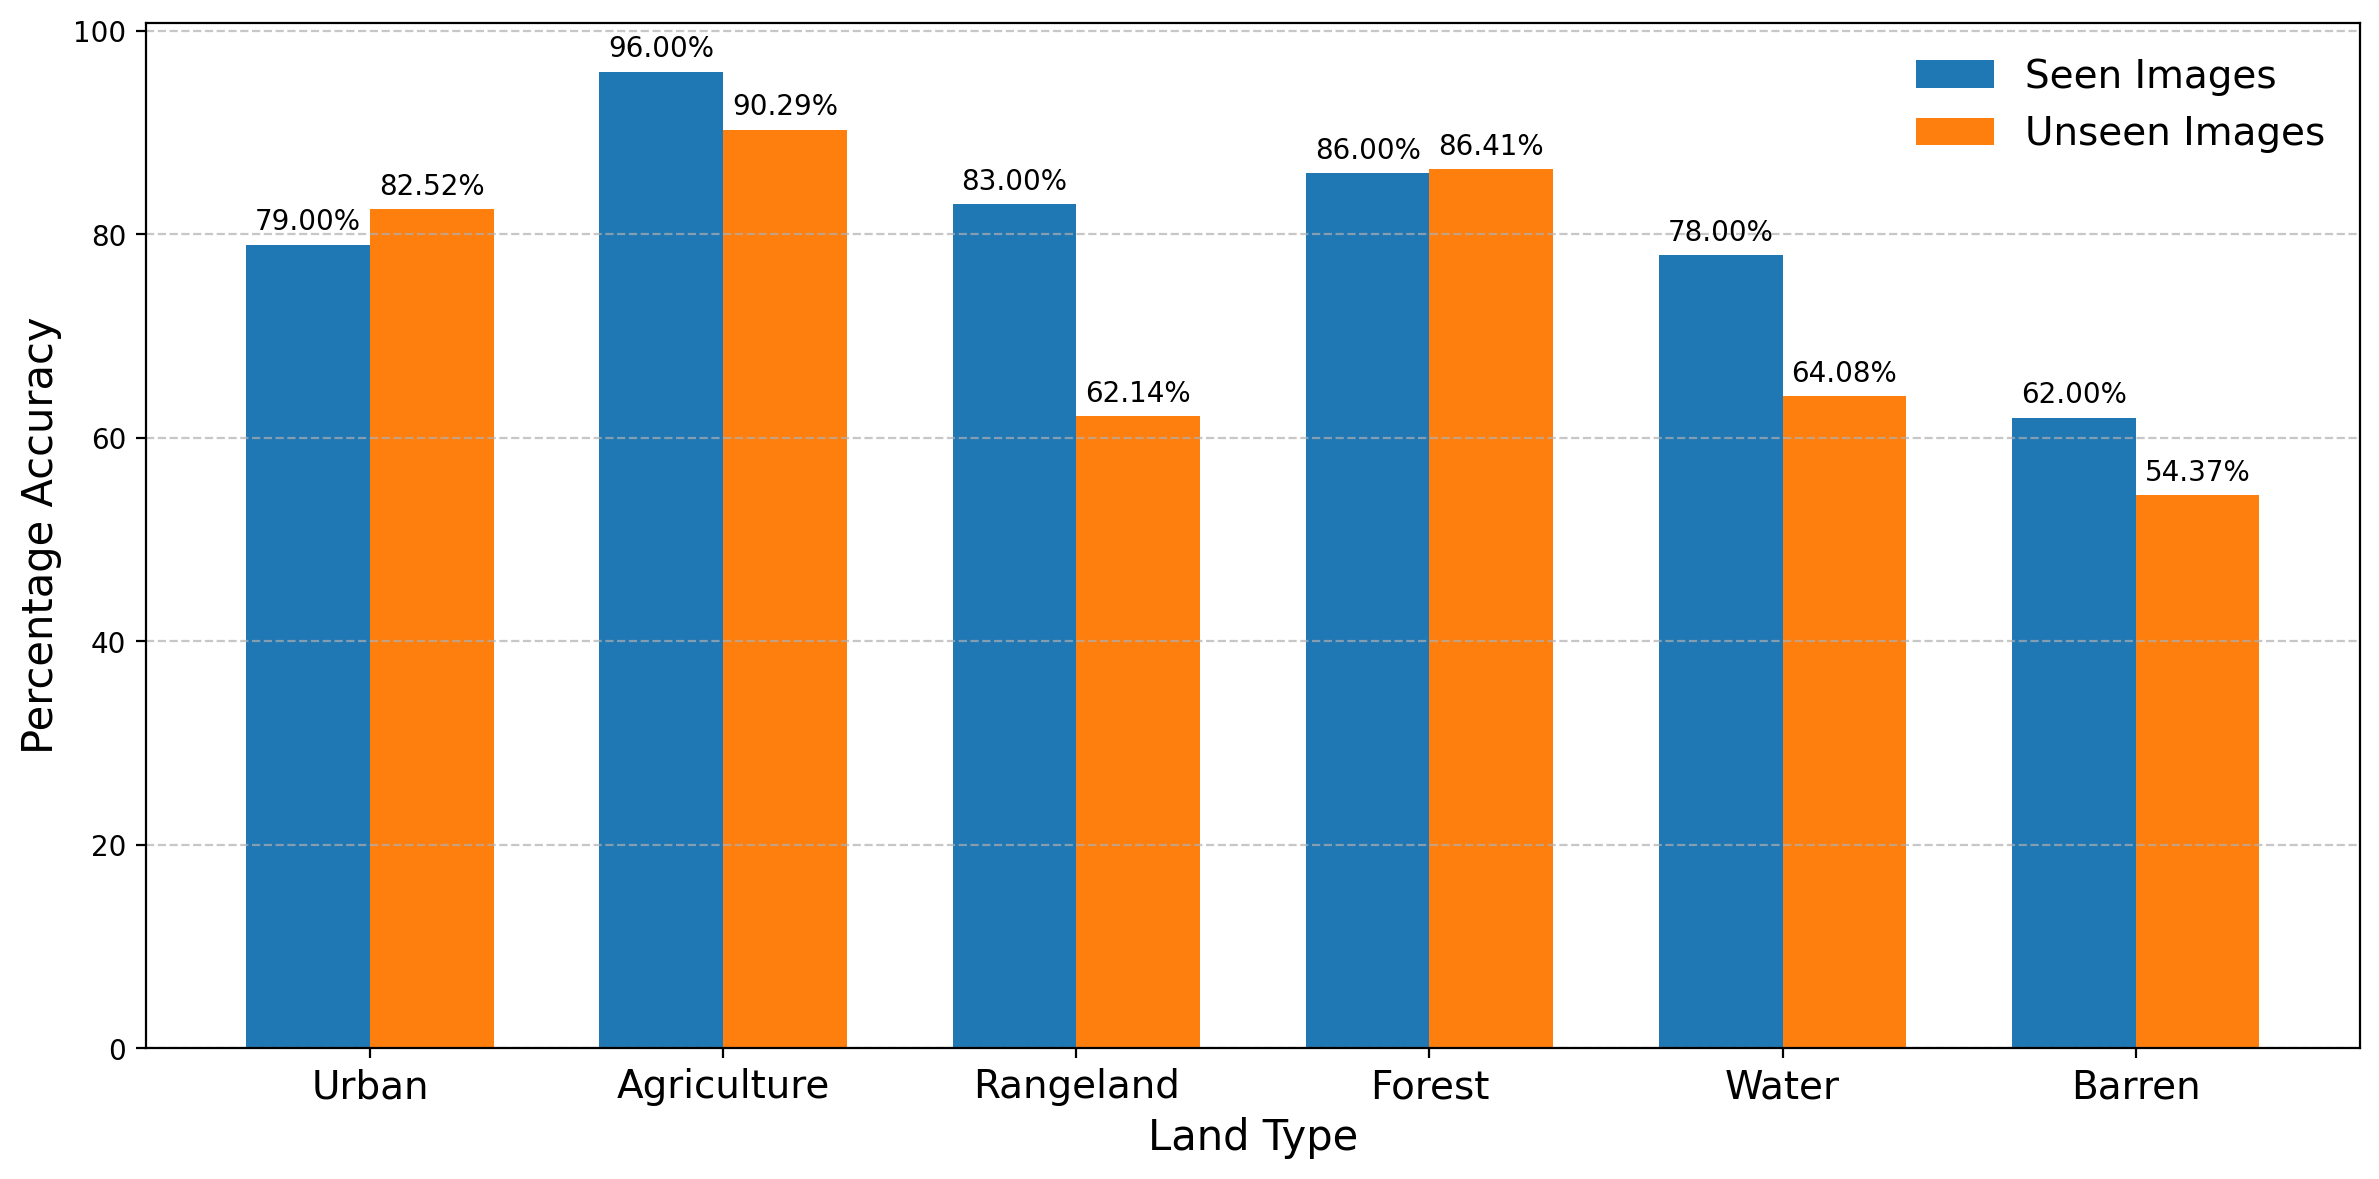

In [ ]:
seen_scores = {
    "Urban": 79.00,
    "Agriculture": 96.00,
    "Rangeland": 83.00,
    "Forest": 86.00,
    "Water": 78.00,
    "Barren": 62.00,
}

unseen_scores = {
    "Urban": 82.52,
    "Agriculture": 90.29,
    "Rangeland": 62.14,
    "Forest": 86.41,
    "Water": 64.08,
    "Barren": 54.37,
}

land_types = ['Urban', 'Agriculture', 'Rangeland', 'Forest', 'Water', 'Barren']

# Seen and unseen scores
seen_percentages = [seen_scores[land_type] for land_type in land_types]
unseen_percentages = [unseen_scores[land_type] for land_type in land_types]

# Plot the bar graph
bar_width = 0.35
index = range(len(land_types))

plt.figure(figsize=(12, 6))
bars1 = plt.bar(index, seen_percentages, bar_width, label='Seen Images')
bars2 = plt.bar([i + bar_width for i in index], unseen_percentages, bar_width, label='Unseen Images')

plt.xlabel('Land Type', fontsize=15)
plt.ylabel('Percentage Accuracy', fontsize=15)
plt.xticks([i + bar_width / 2 for i in index], land_types, fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()




## Task 3: Develop a machine learning algorithm that is capable of classifying each pixel of a satellite image into one of the above classes


I utilised resized training images of (128, 128) due to computational constraints, as training models on (256, 256) images proved to be excessively time-consuming.

In [ ]:
training_labels = []

DATAPOINTS = 803

for i in tqdm(range(DATAPOINTS), desc='Processing Images'):
    mask_path = meta.loc[i, 'mask_path']

    # Read the mask image with correct channel order (BGR)
    mask_image = cv2.imread(mask_path)

    # Swap red and blue channels to correct the order
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

    # Resize the mask image
    target_size = (128, 128)  # Set your desired size
    mask_image = cv2.resize(mask_image, target_size)

    # Initialize an empty array to store labels for each pixel
    labels = np.zeros((target_size[0], target_size[1]), dtype=np.uint8)

    # Prepare the class dictionary for vectorized comparison
    class_rgb_values = classes[['r', 'g', 'b']].values

    # Expand mask image dimensions to enable broadcasting
    expanded_mask = np.expand_dims(mask_image, axis=0)

    # Perform element-wise comparison with class RGB values
    matches = np.all(expanded_mask == class_rgb_values[:, np.newaxis, np.newaxis], axis=3)

    # Find the index of the first match for each pixel
    label_indices = np.argmax(matches, axis=0)

    # Assign labels based on the matched indices
    labels = np.where(np.any(matches, axis=0), label_indices, len(classes) - 1)

    # Append the labels for the current image to the list
    training_labels.append(labels)

# Convert the list of labels to a numpy array
training_labels = np.array(training_labels)

# Save the labels array
file_path = '/content/drive/MyDrive/pixel_labels.npy'
np.save(file_path, training_labels)



Processing Images: 100%|██████████| 803/803 [08:26<00:00,  1.58it/s]


In [ ]:
DATAPOINTS = 700

#TRAINING IMAGES resized to (128,128)
training_image_path = '/content/drive/MyDrive/training_images128.ipynb.npy'
training_images = np.load(training_image_path)[:DATAPOINTS]

#LAND TYPE LABELS
pixel_path = '/content/drive/MyDrive/pixel_labels.npy'
pixel_labels = np.load(pixel_path)[:DATAPOINTS]



## Model 1:

Choose to use a U-net model as suggested my teacher.

Model shows overfitting

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.4612 

18/18 [==============================] - 528s 29s/step - loss: 0.2006 - accuracy: 0.4612 - val_loss: 0.0664 - val_accuracy: 0.5416
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.5896 

18/18 [==============================] - 504s 28s/step - loss: 0.0593 - accuracy: 0.5896 - val_loss: 0.0617 - val_accuracy: 0.5475
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.5890 

18/18 [==============================] - 508s 28s/step - loss: 0.0573 - accuracy: 0.5890 - val_loss: 0.0594 - val_accuracy: 0.5517
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.6034 

18/18 [==============================] - 509s 28s/step - loss: 0.0543 - accuracy: 0.6034 - val_loss: 0.0567 - val_accuracy: 0.5568
Epoch 5/10
18/18 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.6091 

18/18 [==============================] - 509s 28s/step - loss: 0.0530 - accuracy: 0.6091 - val_loss: 0.0541 - val_accuracy: 0.5688
Epoch 6/10
18/18 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.6204 

18/18 [==============================] - 508s 28s/step - loss: 0.0514 - accuracy: 0.6204 - val_loss: 0.0536 - val_accuracy: 0.5736
Epoch 7/10
18/18 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.6209 

18/18 [==============================] - 507s 28s/step - loss: 0.0512 - accuracy: 0.6209 - val_loss: 0.0523 - val_accuracy: 0.5812
Epoch 8/10
18/18 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.6126 

18/18 [==============================] - 509s 28s/step - loss: 0.0520 - accuracy: 0.6126 - val_loss: 0.0524 - val_accuracy: 0.5783
Epoch 9/10
18/18 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.6269 

18/18 [==============================] - 507s 28s/step - loss: 0.0494 - accuracy: 0.6269 - val_loss: 0.0528 - val_accuracy: 0.5786
Epoch 10/10
18/18 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.6218 

18/18 [==============================] - 507s 28s/step - loss: 0.0499 - accuracy: 0.6218 - val_loss: 0.0553 - val_accuracy: 0.5549


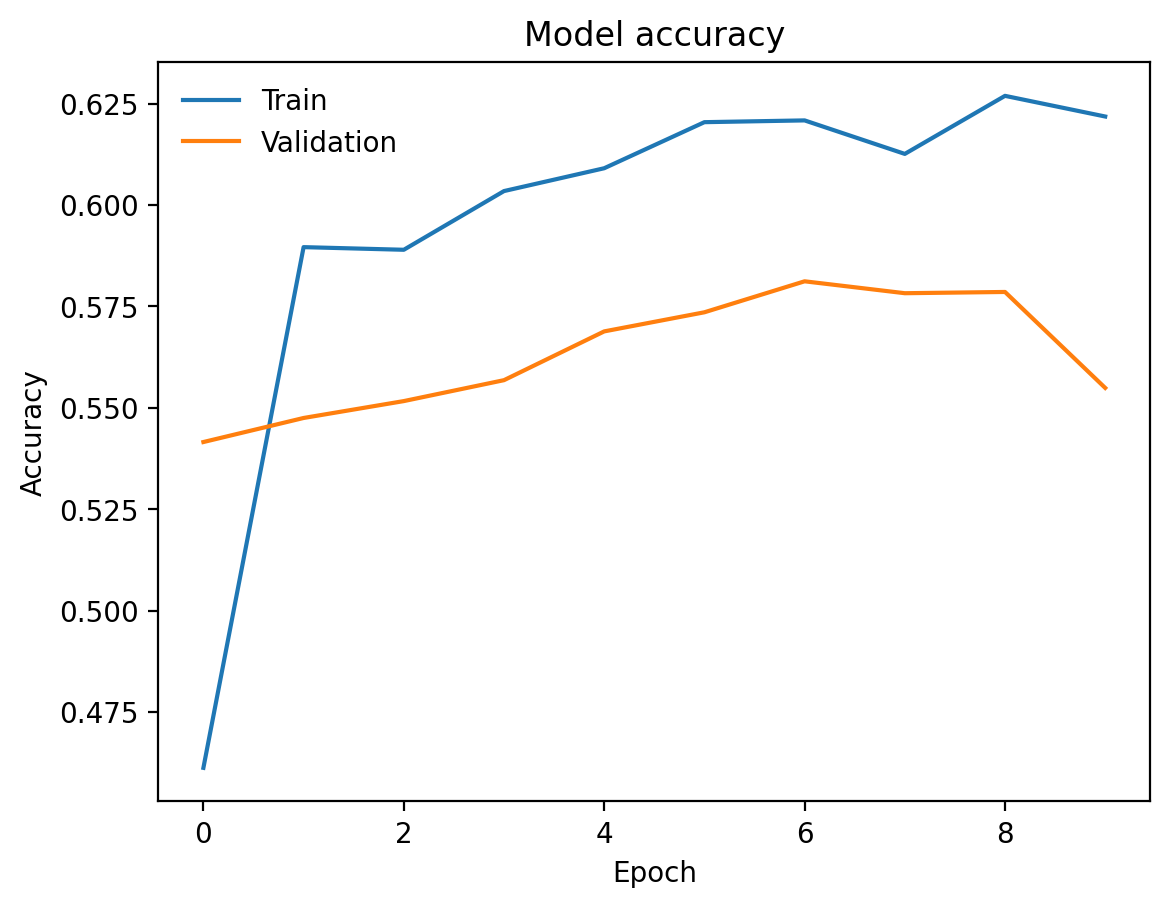

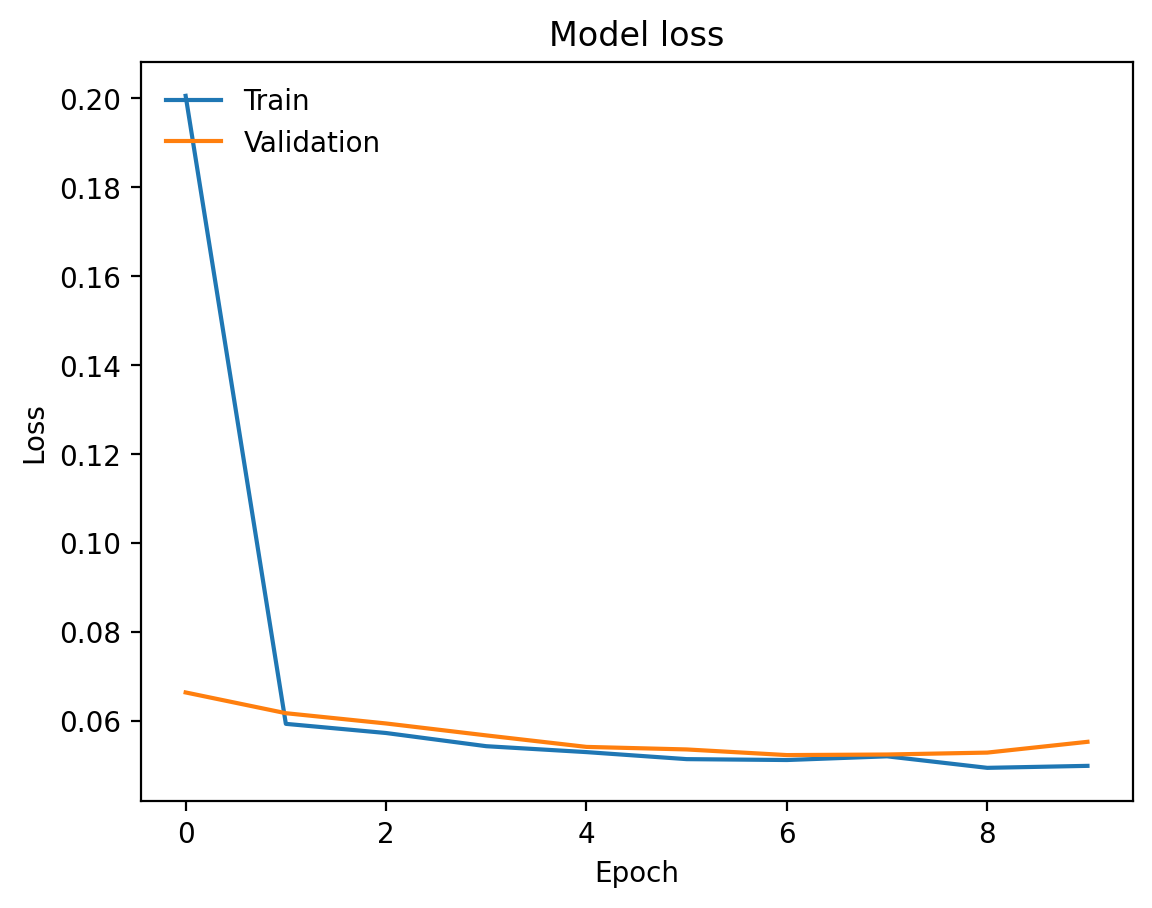

In [ ]:
from keras import layers
from keras import models


# Load the training images and labels
train_images = np.load(training_image_path)[:DATAPOINTS]
train_labels = np.load(pixel_path)[:DATAPOINTS]

# Define U-Net model architecture
def unet_model(input_shape=(128, 128, 3), num_classes=7):
    """
    Defines the U-Net model architecture for semantic segmentation.

    Arguments:
    - input_shape: tuple specifying the shape of the input images (height, width, channels).
    - num_classes: integer specifying the number of classes for segmentation.

    Returns:
    - model: a Keras Model object representing the U-Net model.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder (contracting path)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Mid-level
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder (expansive path)
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = layers.concatenate([up4, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model and store the training history
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Model 2:

I tried introducing class weights to this model, as agriculutre is overly represented in the training images compared to other classes. Therefore, i reduced its weight compared to other classes to try and imporve model predictions.


This model showed an improvement, with less overfitting.


Epoch 1/10
18/18 [==============================] - 572s 32s/step - loss: 2.3250 - accuracy: 0.5298 - val_loss: 1.4688 - val_accuracy: 0.5432
Epoch 2/10
18/18 [==============================] - 568s 32s/step - loss: 1.2745 - accuracy: 0.6037 - val_loss: 1.3522 - val_accuracy: 0.5620
Epoch 3/10
18/18 [==============================] - 566s 32s/step - loss: 1.2158 - accuracy: 0.6157 - val_loss: 1.4020 - val_accuracy: 0.5569
Epoch 4/10
18/18 [==============================] - 562s 31s/step - loss: 1.2172 - accuracy: 0.6135 - val_loss: 1.2316 - val_accuracy: 0.5727
Epoch 5/10
18/18 [==============================] - 571s 32s/step - loss: 1.1741 - accuracy: 0.6258 - val_loss: 1.2486 - val_accuracy: 0.5780
Epoch 6/10
18/18 [==============================] - 568s 32s/step - loss: 1.1506 - accuracy: 0.6266 - val_loss: 1.1610 - val_accuracy: 0.6052
Epoch 7/10
18/18 [==============================] - 563s 31s/step - loss: 1.1020 - accuracy: 0.6386 - val_loss: 1.1556 - val_accuracy: 0.5916
Epoch 

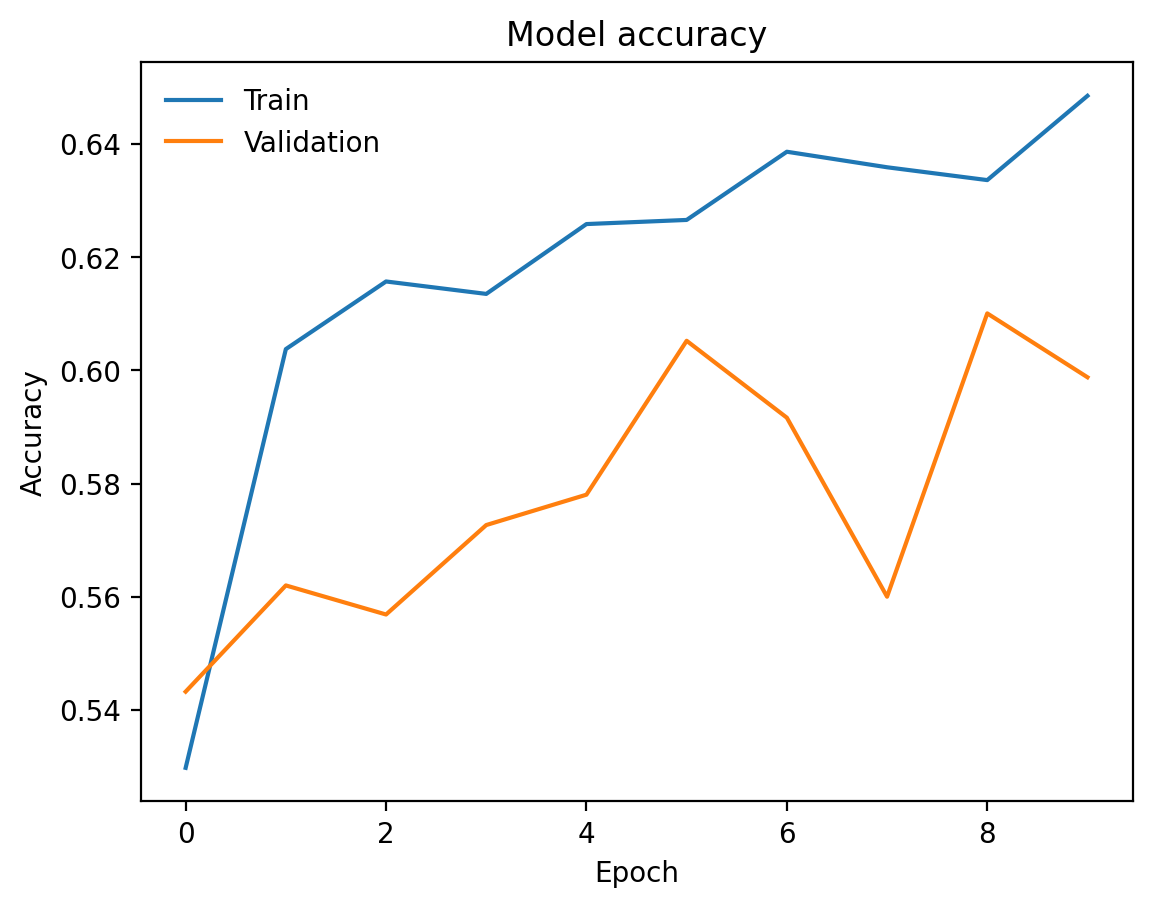

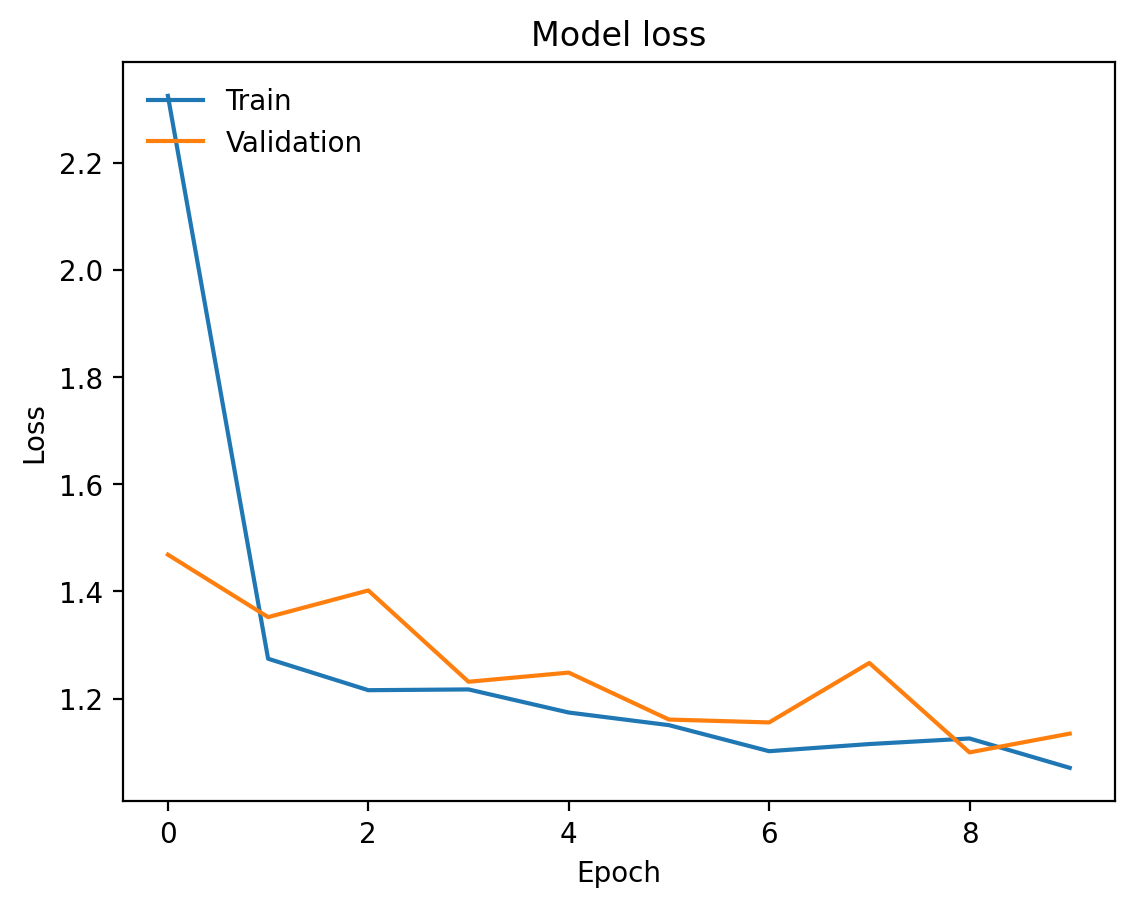

In [ ]:

# Load the training images and labels
train_images = np.load(training_image_path)[:DATAPOINTS]
train_labels = np.load(pixel_path)[:DATAPOINTS]

# Define U-Net model architecture
def unet_model(input_shape=(128, 128, 3), num_classes=7):
    """
    Defines the U-Net model architecture for semantic segmentation.

    Arguments:
    - input_shape: tuple specifying the shape of the input images (height, width, channels).
    - num_classes: integer specifying the number of classes for segmentation.

    Returns:
    - model: a Keras Model object representing the U-Net model.
    """

    inputs = layers.Input(shape=input_shape)

    # Encoder (contracting path)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Mid-level
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder (expansive path)
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = layers.concatenate([up4, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def add_sample_weights(image, label):
    """
    Adds sample weights based on class percentages.

    Arguments:
    - image: input image data.
    - label: corresponding label data.

    Returns:
    - image: input image data.
    - label: corresponding label data.
    - sample_weights: sample weights based on class percentages.
    """
    # Calculate class weights
    class_weights = np.array([0.15, 0.01, 0.15, 0.15, 0.15, 0.15, 0.15])
    # Normalize class weights
    class_weights /= np.sum(class_weights)
    # Create sample weights
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Generate sample weights for training data
train_sample_weights = []
for img, lbl in zip(train_images, train_labels):
    _, _, sample_weights = add_sample_weights(img, lbl)
    train_sample_weights.append(sample_weights)
train_sample_weights = np.array(train_sample_weights)

# Train the model and store the training history
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2, sample_weight=train_sample_weights)

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Model 3:

Increasing the number of filters in the Encoder and Mid-level convoloution layers resulted in a much better model fit witht the data, and a higher model accuracy.

Epoch 1/15
21/21 [==============================] - 283s 13s/step - loss: 1.8713 - accuracy: 0.5197 - val_loss: 1.3577 - val_accuracy: 0.5638
Epoch 2/15
21/21 [==============================] - 280s 13s/step - loss: 1.2634 - accuracy: 0.6044 - val_loss: 1.3637 - val_accuracy: 0.5750
Epoch 3/15
21/21 [==============================] - 280s 13s/step - loss: 1.2437 - accuracy: 0.6098 - val_loss: 1.1298 - val_accuracy: 0.6174
Epoch 4/15
21/21 [==============================] - 280s 13s/step - loss: 1.1915 - accuracy: 0.6162 - val_loss: 1.1363 - val_accuracy: 0.6217
Epoch 5/15
21/21 [==============================] - 280s 13s/step - loss: 1.1686 - accuracy: 0.6206 - val_loss: 1.1749 - val_accuracy: 0.6169
Epoch 6/15
21/21 [==============================] - 280s 13s/step - loss: 1.2207 - accuracy: 0.6112 - val_loss: 1.1644 - val_accuracy: 0.6027
Epoch 7/15
21/21 [==============================] - 279s 13s/step - loss: 1.1633 - accuracy: 0.6236 - val_loss: 1.2264 - val_accuracy: 0.5975
Epoch 

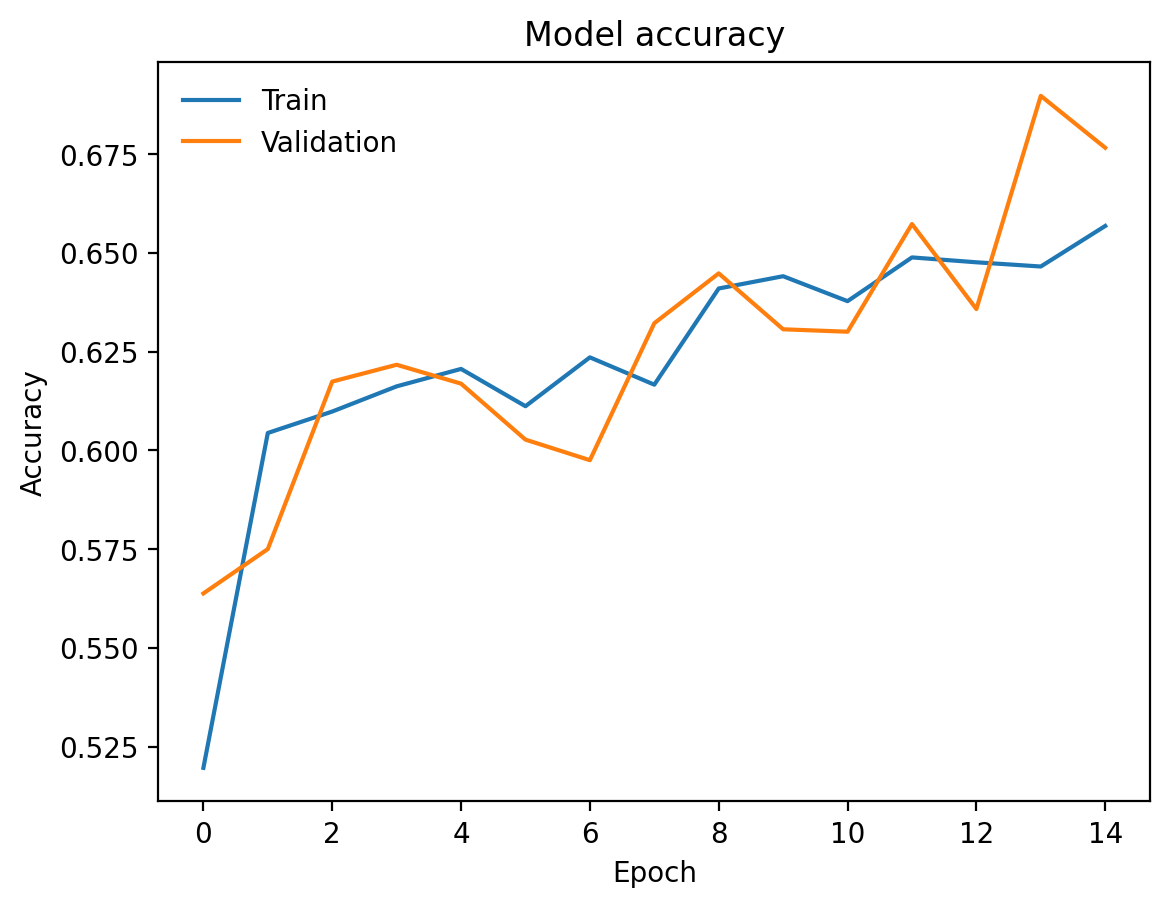

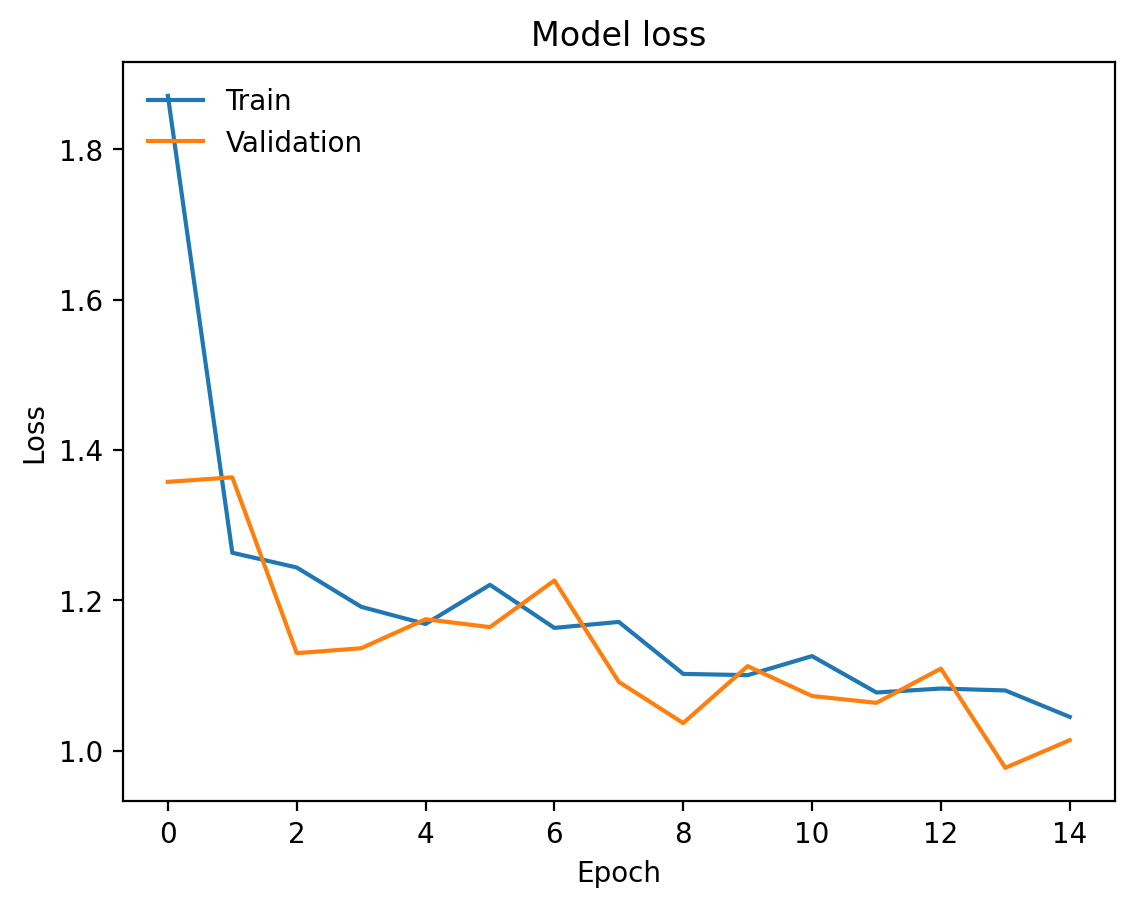

In [ ]:
# Load the training images and labels
train_images = np.load(training_image_path)[:DATAPOINTS]
train_labels = np.load(pixel_path)[:DATAPOINTS]

# Define U-Net model architecture
def unet_model(input_shape=(128, 128, 3), num_classes=7):
    """
    Defines the U-Net model architecture for semantic segmentation.

    Arguments:
    - input_shape: tuple specifying the shape of the input images (height, width, channels).
    - num_classes: integer specifying the number of classes for segmentation.

    Returns:
    - model: a Keras Model object representing the U-Net model.
    """

    inputs = layers.Input(shape=input_shape)

    # Encoder (contracting path)
    conv1 = layers.Conv2D(70, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(70, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(140, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(140, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Mid-level
    conv3 = layers.Conv2D(280, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(280, 3, activation='relu', padding='same')(conv3)

    # Decoder (expansive path)
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = layers.concatenate([up4, conv2], axis=3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv1], axis=3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(train_images, train_labels, epochs=15, batch_size=32, validation_split=0.2)

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/saved_models/pixel5_model.h5")

##Testing Predictions on unseen images to determine best Model to use:

In [85]:
DATAPOINTS = 803
START = 700
#TRAINING IMAGES
training_image_path = '/content/drive/MyDrive/training_images128.ipynb.npy'
training_images = np.load(training_image_path)[START:DATAPOINTS]

#LAND TYPE LABELS
pixel_path = '/content/drive/MyDrive/pixel_labels.npy'
pixel_labels = np.load(pixel_path)[START:DATAPOINTS]


In [86]:

# Define the paths to the models
model_paths = ["/content/drive/MyDrive/saved_models/pixel2_model.h5",
               "/content/drive/MyDrive/saved_models/pixel4_model.h5",
               "/content/drive/MyDrive/saved_models/pixel5_model.h5"]

# List to store predictions for each model
all_pixel_predictions = []

# Iterate over each model
for model_path in model_paths:
    # Load the model
    pixel_model = load_model(model_path)

    # List to store predictions for the current model
    pixel_predictions = []

    # Predict land type fractions for all images
    for input_image in tqdm(training_images, desc=f'Processing Images for {model_path}'):
        # Reshape the single image to match the expected input shape of the model
        input_image = np.expand_dims(input_image, axis=0)  # Add a batch dimension

        # Predict using the reshaped input image
        predictions = pixel_model.predict(input_image, verbose=0)

        pixel_predictions.append(predictions)

    # Convert the list of predictions to a numpy array and append to the list
    all_pixel_predictions.append(np.array(pixel_predictions))

# Convert the list of predictions for all models to a numpy array
all_pixel_predictions = np.array(all_pixel_predictions)


Processing Images for /content/drive/MyDrive/saved_models/pixel2_model.h5: 100%|██████████| 103/103 [00:47<00:00,  2.19it/s]
Processing Images for /content/drive/MyDrive/saved_models/pixel4_model.h5: 100%|██████████| 103/103 [01:04<00:00,  1.60it/s]
Processing Images for /content/drive/MyDrive/saved_models/pixel5_model.h5: 100%|██████████| 103/103 [00:44<00:00,  2.33it/s]


In [87]:
# List to store pixel percentage scores for each model
all_pixel_percentage_scores = []

# Iterate over predictions for each model
for pixel_predictions in all_pixel_predictions:
    # List to store pixel percentage scores for the current model
    pixel_percentage_scores = []

    # Iterate over predictions and calculate percentage score for each image
    for pixel_prediction, pixel_label in tqdm(zip(pixel_predictions, pixel_labels), desc='Processing Predictions'):
        # Calculate the number of matching labels between predictions and pixel labels for this image
        matching_labels = np.sum(np.argmax(pixel_prediction, axis=-1) == pixel_label)

        # Calculate the percentage score for this image
        percentage_score = (matching_labels / (pixel_label.shape[0] * pixel_label.shape[1])) * 100

        # Append the percentage score to the list
        pixel_percentage_scores.append(percentage_score)

    # Calculate the average percentage score across all images for this model
    average_percentage_score = np.mean(pixel_percentage_scores)

    # Append the average percentage score for this model to the list
    all_pixel_percentage_scores.append(average_percentage_score)

# Print the average percentage scores for all models
for i, score in enumerate(all_pixel_percentage_scores):
    print(f"Average Percentage Score for Pixel Predictions (Model {i+1}): {score:.2f}%")



Processing Predictions: 103it [00:00, 704.94it/s]
Processing Predictions: 103it [00:00, 456.98it/s]
Processing Predictions: 103it [00:00, 757.24it/s]

Average Percentage Score for Pixel Predictions (Model 1): 65.53%
Average Percentage Score for Pixel Predictions (Model 2): 67.96%
Average Percentage Score for Pixel Predictions (Model 3): 69.49%


We can see that Model 3 has the best accuracy in label predictions for unseen images. This is to be expected since this model fit the data best as shown by the close val accuacy and accuracy curves, and val loss and loss curves.

##Plotting Confusion Matrix for models:

Interested in how well the models perform at postively classify different land types.

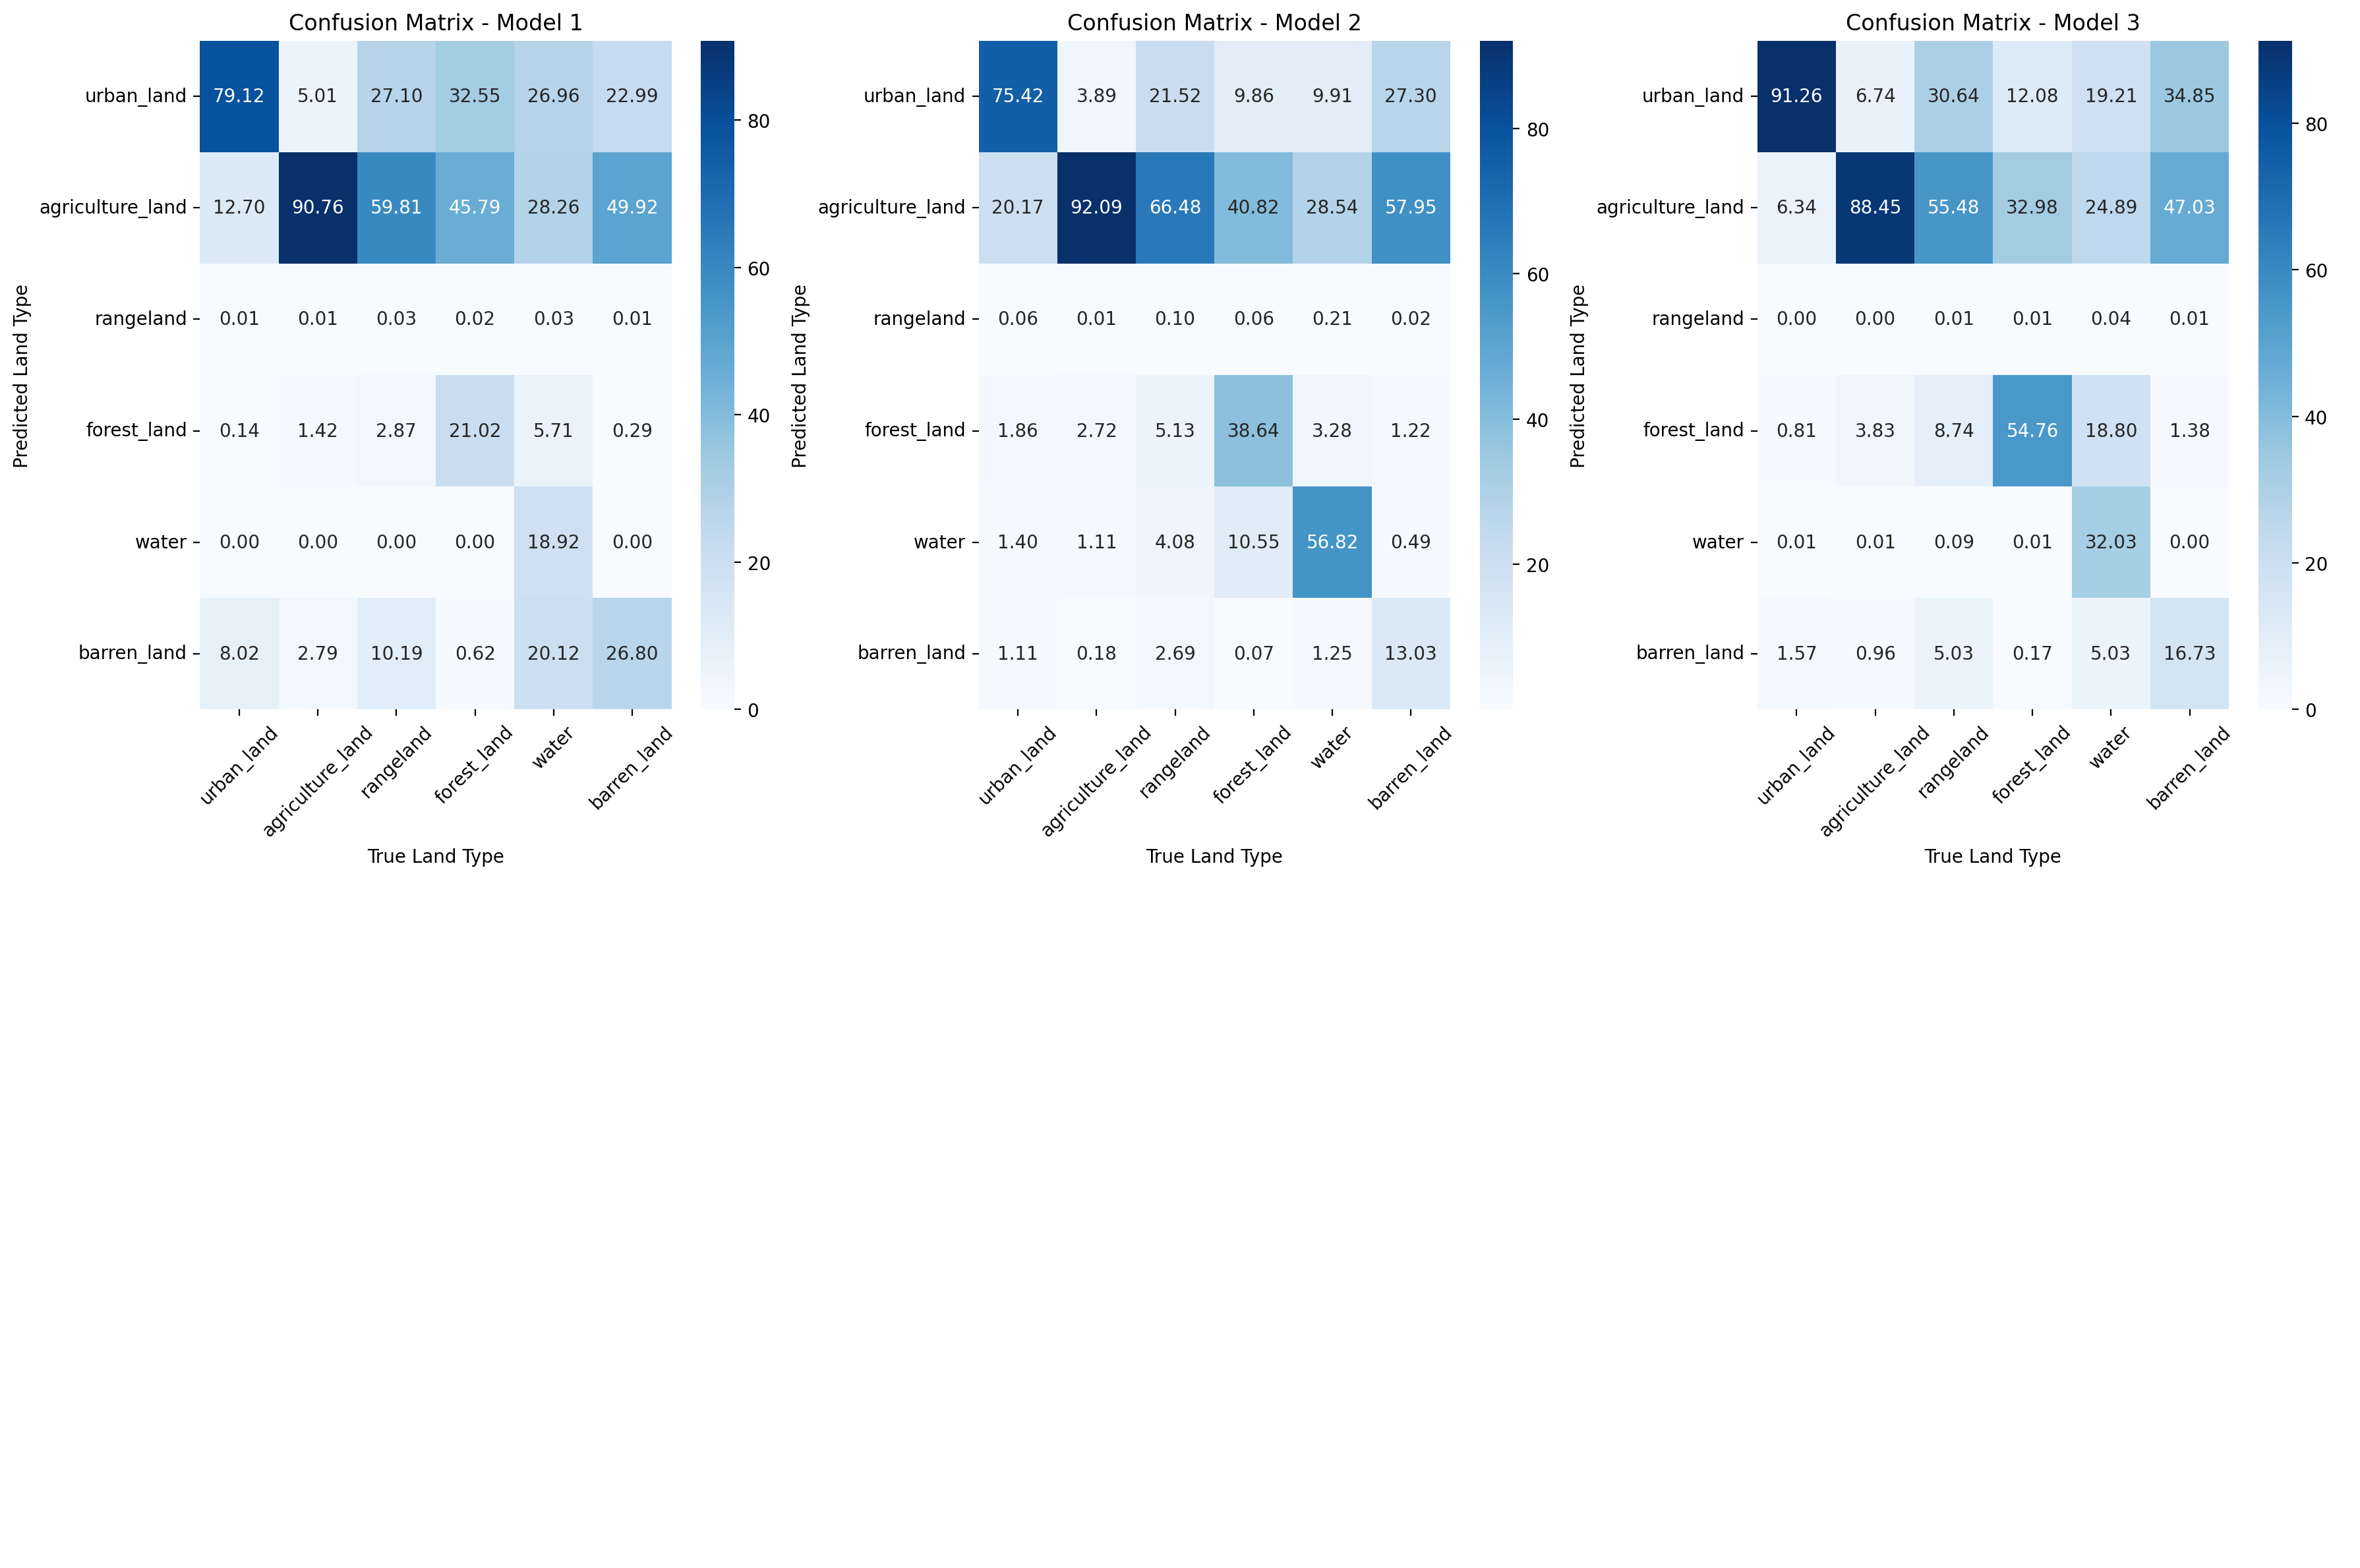

In [89]:
# Define land type names
land_types = {
    0: 'urban_land',
    1: 'agriculture_land',
    2: 'rangeland',
    3: 'forest_land',
    4: 'water',
    5: 'barren_land',
}

# List to store confusion matrices for models 1 to 5
all_conf_matrices = []

# Iterate over predictions for each model (models 1 to 5)
for model_idx in range(1, 4):
    # Reshape the pixel_labels and pixel_predictions to flat arrays
    pixel_labels_flat = pixel_labels.flatten()
    pixel_predictions_flat = np.argmax(all_pixel_predictions[model_idx - 1], axis=-1).flatten()

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(pixel_labels_flat, pixel_predictions_flat)

    # Normalize the confusion matrix to percentages
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Remove the 7th class from the confusion matrix
    conf_matrix_norm = np.delete(conf_matrix_norm, 6, axis=0)
    conf_matrix_norm = np.delete(conf_matrix_norm, 6, axis=1)

    # Transpose the confusion matrix for plotting with true land type labels on x-axis
    conf_matrix_norm_transpose = np.transpose(conf_matrix_norm)

    # Append the confusion matrix for this model to the list
    all_conf_matrices.append(conf_matrix_norm_transpose)

# Plotting all confusion matrices in a grid layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, ax in enumerate(axes.flat):
    if i < len(all_conf_matrices):  # Ensure that there are enough models to fill all subplots
        sns.heatmap(all_conf_matrices[i], annot=True, fmt='.2f', cmap='Blues', ax=ax,
                    xticklabels=[land_types[i] for i in range(6)], yticklabels=[land_types[i] for i in range(6)])
        ax.set_title(f'Confusion Matrix - Model {i+1}')
        ax.set_xlabel('True Land Type')
        ax.set_ylabel('Predicted Land Type')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    else:
        ax.axis('off')  # Hide empty subplots if there are fewer models than subplots

plt.tight_layout()
plt.show()



In [90]:
# Calculate overall accuracy for each model
overall_accuracies = [np.trace(conf_matrix) / np.sum(conf_matrix) for conf_matrix in all_conf_matrices]

# Print overall accuracies
for i, accuracy in enumerate(overall_accuracies):
    print(f"Model {i+1} Overall Accuracy: {accuracy:.2f}")

Model 1 Overall Accuracy: 0.39
Model 2 Overall Accuracy: 0.46
Model 3 Overall Accuracy: 0.47


Model 3 also has the best overall accuracy for its confusion matrix. Therefore I will use this model as my final model

##Plotting model 3 confusion matrix:

I want to have a closer look at each of the cells: clearly the model performs best at classifying agriculure and urban land. The model seem decent at classifying water as well. Other land types are generally misclassifed as urban and agriculural land.

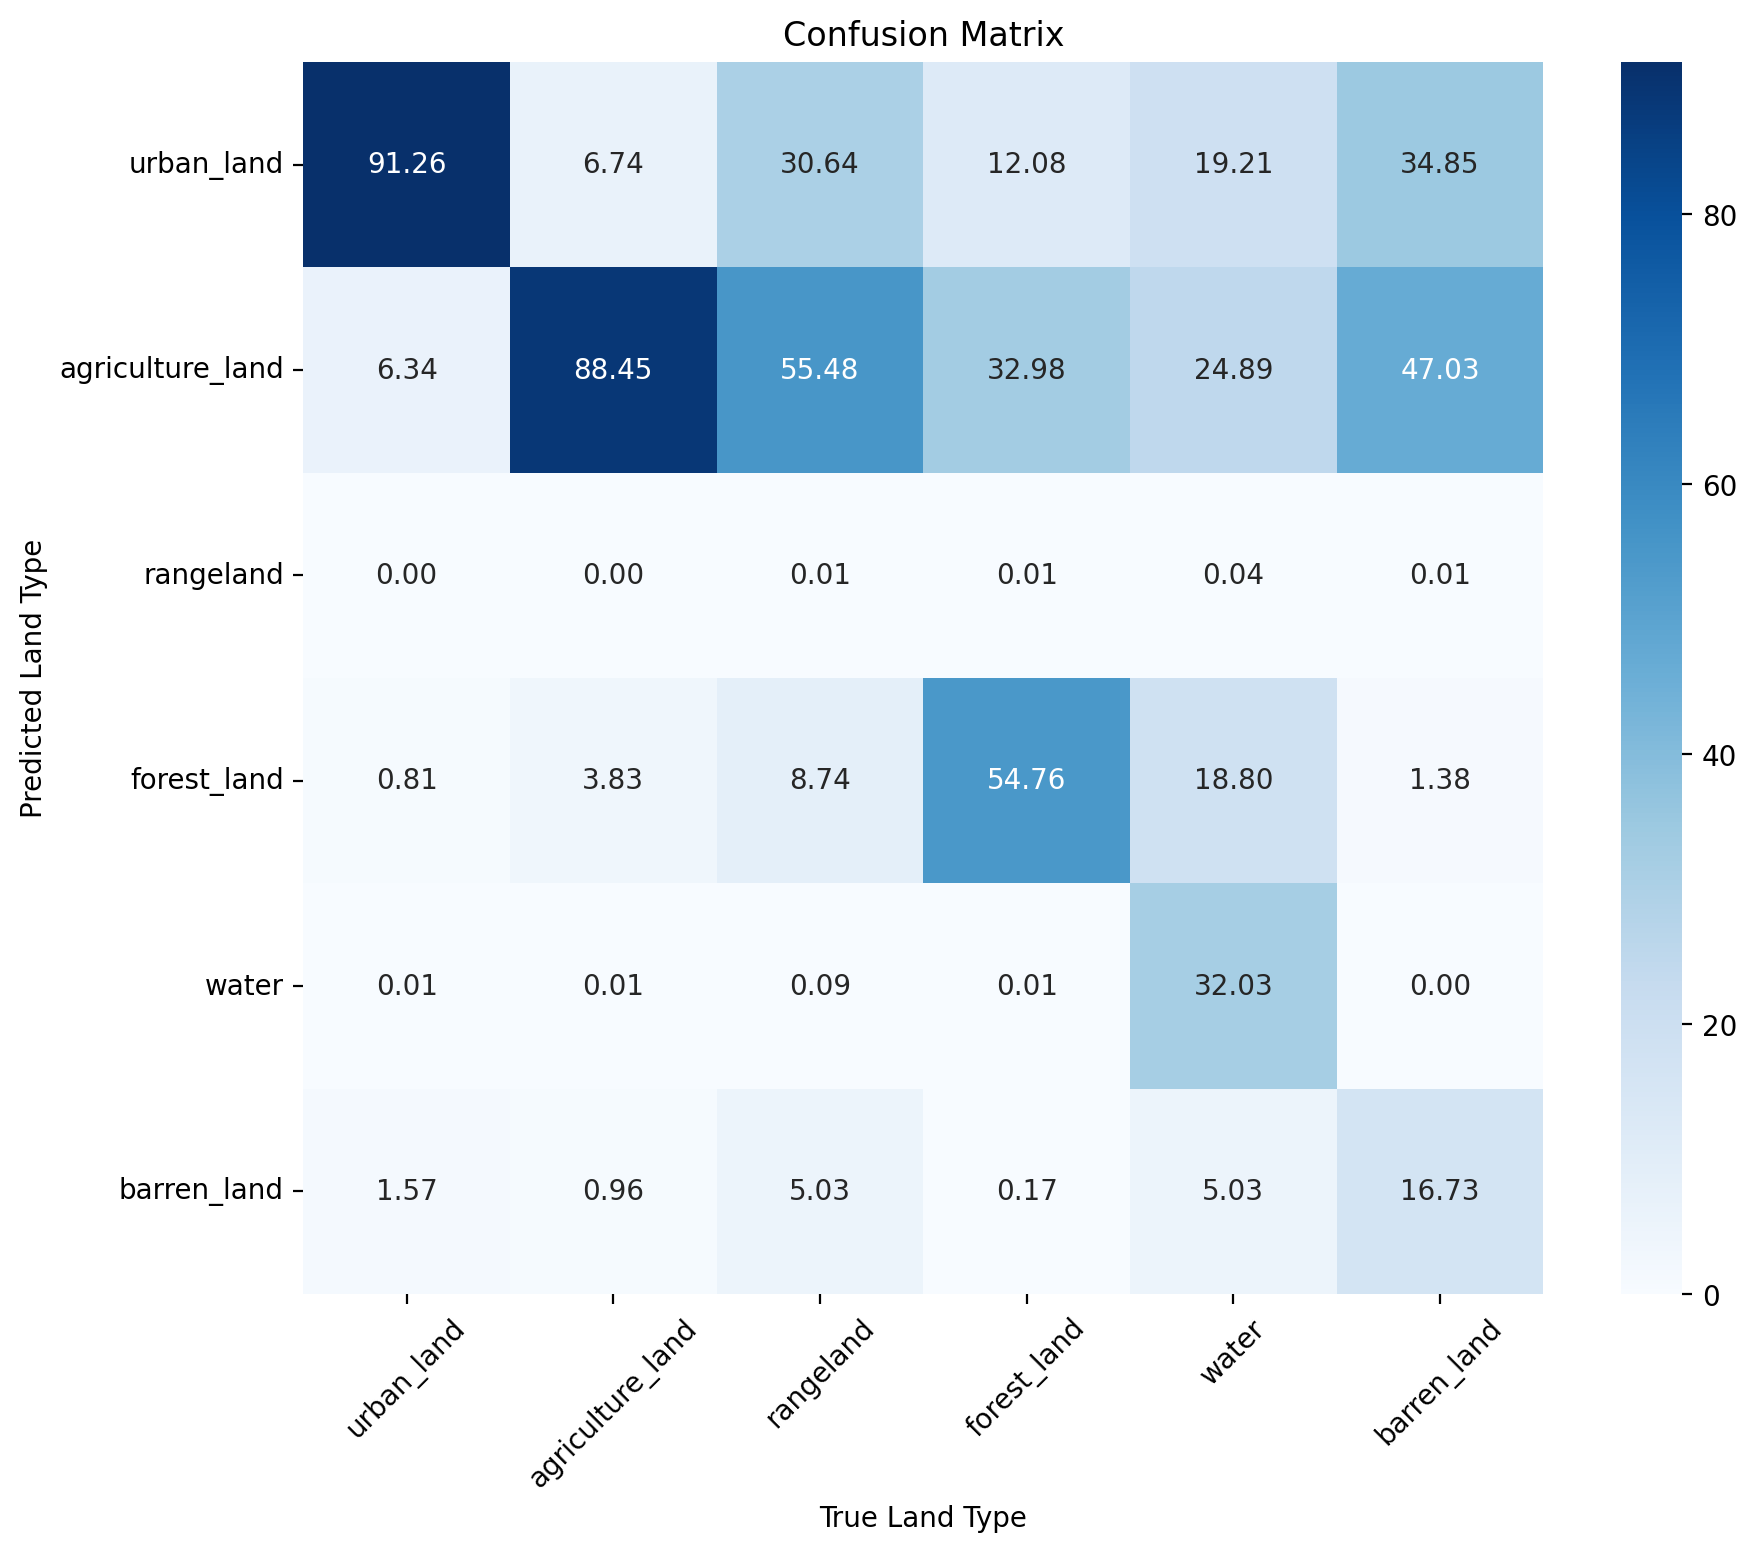

In [91]:
# Define land type names
land_types = {
    0: 'urban_land',
    1: 'agriculture_land',
    2: 'rangeland',
    3: 'forest_land',
    4: 'water',
    5: 'barren_land',
}

# List to store confusion matrices for models 1 to 5
all_conf_matrices = []

# Iterate over predictions for each model (models 1 to 5)
for model_idx in range(1, 4):
    # Reshape the pixel_labels and pixel_predictions to flat arrays
    pixel_labels_flat = pixel_labels.flatten()
    pixel_predictions_flat = np.argmax(all_pixel_predictions[model_idx - 1], axis=-1).flatten()

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(pixel_labels_flat, pixel_predictions_flat)

    # Normalize the confusion matrix to percentages
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]* 100

    # Remove the 7th class from the confusion matrix since we are not considering 'unknown'
    conf_matrix_norm = np.delete(conf_matrix_norm, 6, axis=0)
    conf_matrix_norm = np.delete(conf_matrix_norm, 6, axis=1)

    # Transpose the confusion matrix for plotting with true land type labels on x-axis
    conf_matrix_norm_transpose = np.transpose(conf_matrix_norm)

    # Append the confusion matrix for this model to the list
    all_conf_matrices.append(conf_matrix_norm_transpose)

# Function to plot the confusion matrix for a given model index
def plot_confusion_matrix(model_idx, conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=[land_types[i] for i in range(6)],
                yticklabels=[land_types[i] for i in range(6)])
    plt.title(f'Confusion Matrix')
    plt.xlabel('True Land Type')
    plt.ylabel('Predicted Land Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Choose the model index for which you want to plot the confusion matrix (1 for pixel1, 2 for pixel2, etc.)
chosen_model_idx = 3

# Plot the confusion matrix for the chosen model
plot_confusion_matrix(chosen_model_idx, all_conf_matrices[chosen_model_idx - 1])


In [78]:
from sklearn.metrics import classification_report

# Adjust the target names list to exclude the "unknown" class
target_names = [land_types[i] for i in range(6)]

# Remove the "unknown" class from the flat arrays
valid_indices = np.where(pixel_labels_flat != 6)
pixel_labels_flat = pixel_labels_flat[valid_indices]
pixel_predictions_flat = pixel_predictions_flat[valid_indices]

# Generate the classification report
report = classification_report(pixel_labels_flat, pixel_predictions_flat, target_names=target_names, zero_division=1)

# Print the classification report
print(report)



                  precision    recall  f1-score   support

      urban_land       0.51      0.91      0.65    214102
agriculture_land       0.78      0.88      0.83    930632
       rangeland       0.14      0.00      0.00    135473
     forest_land       0.65      0.55      0.59    207719
           water       0.99      0.32      0.48     51519
     barren_land       0.52      0.17      0.25    142999

        accuracy                           0.70   1682444
       macro avg       0.60      0.47      0.47   1682444
    weighted avg       0.66      0.70      0.65   1682444



This classification report gives better detail into the models classifications metrics.

There are notable performance disparities across different land type classes. The model demonstrates high precision and recall for classes like urban land and agriculture land, indicating its effectiveness in accurately identifying these land types. However, it struggles with classes such as rangeland and water, where precision, recall, and F1-scores are comparatively lower.

The impact of class imbalance on model performance is evident, with classes having higher support exhibiting better performance metrics. This suggests that the distribution of samples across classes influences the model's ability to generalise effectively, particularly for less represented land types.

## Comparing the predicted mask to the true mask for a satelitte image:

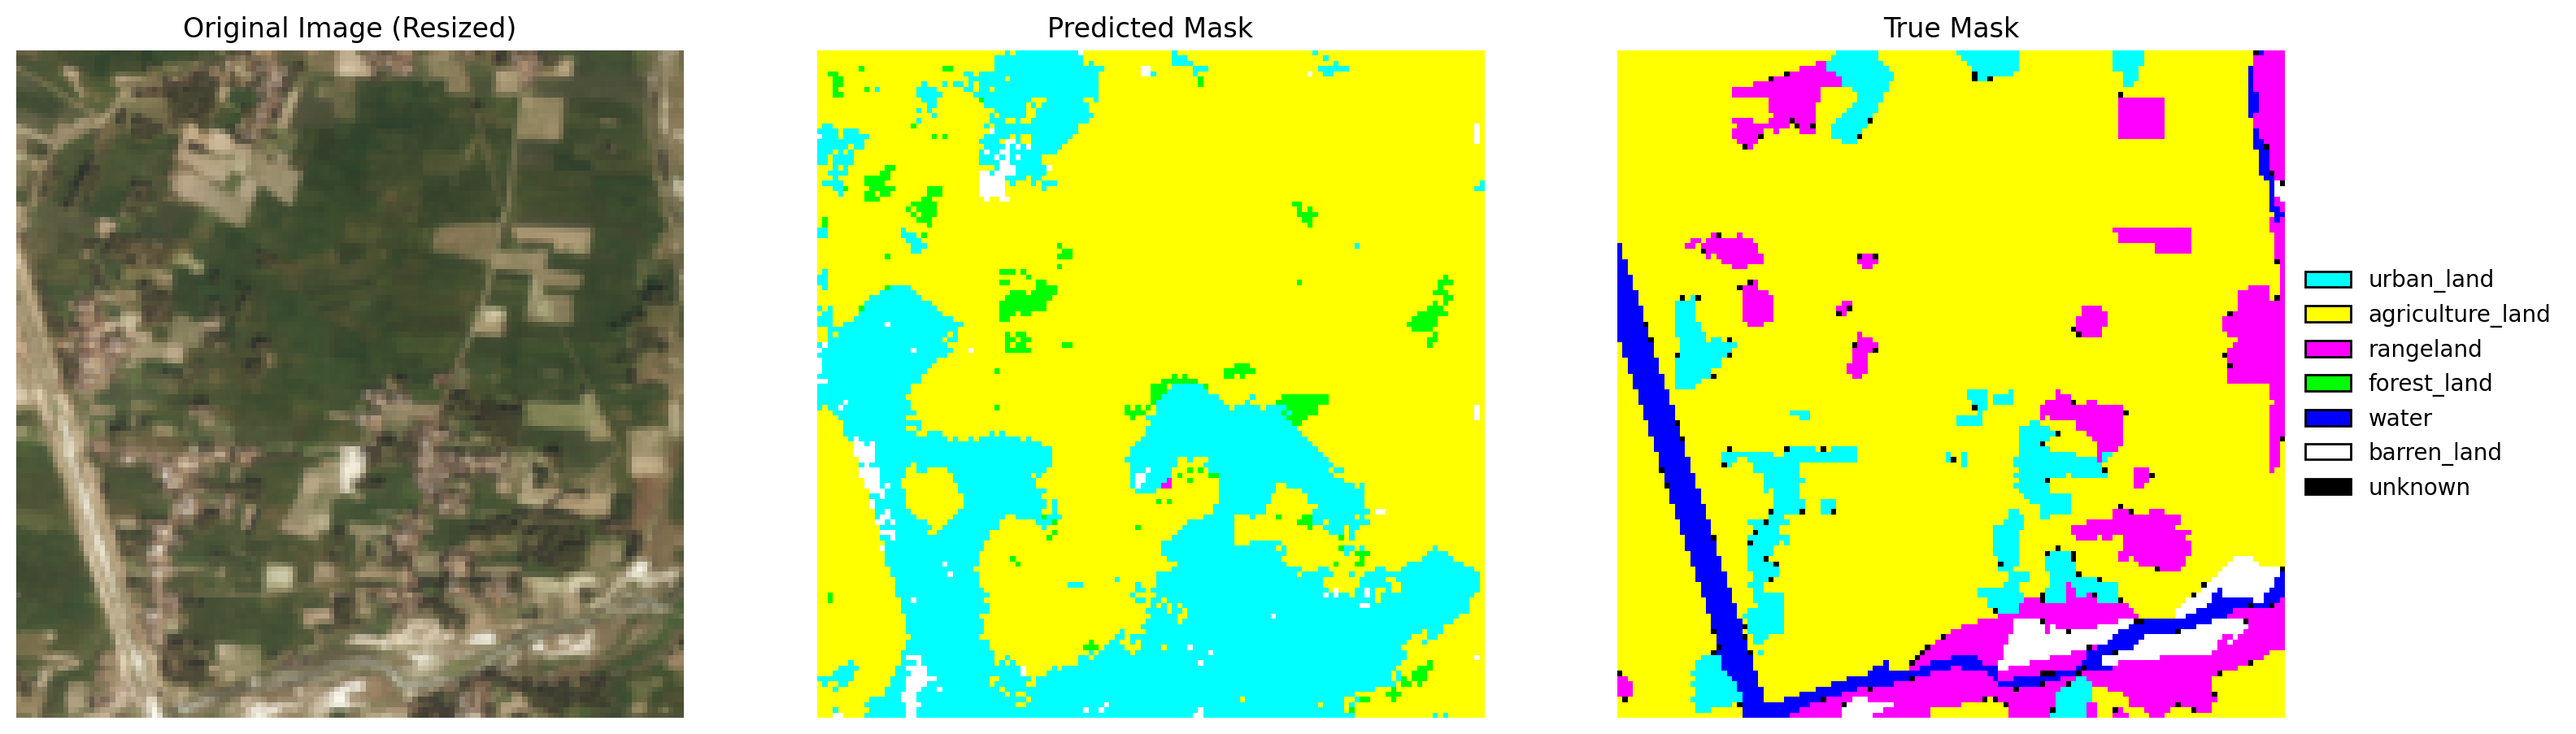

In [ ]:
# Define the colormap corresponding to the integer labels 0-6
colormap = {
    0: (0/255, 255/255, 255/255, 1),      # urban_land
    1: (255/255, 255/255, 0/255, 1),      # agriculture_land
    2: (255/255, 0/255, 255/255, 1),      # rangeland
    3: (0/255, 255/255, 0/255, 1),        # forest_land
    4: (0/255, 0/255, 255/255, 1),        # water
    5: (255/255, 255/255, 255/255, 1),    # barren_land
    6: (0/255, 0/255, 0/255, 1)           # unknown
}

# Define land type names
land_types = {
    0: 'urban_land',
    1: 'agriculture_land',
    2: 'rangeland',
    3: 'forest_land',
    4: 'water',
    5: 'barren_land',
    6: 'unknown'
}

# Choose the model index
model_index = 4  # Choose the model index here (2 corresponds to model 3, for example)

im_num = 72

# Load the original image and mask and resize them
whichImg = 700 + im_num
im = imageio.imread(meta['sat_image_path'][whichImg])  # Read in the sat image
im_resized = resize(im, (128, 128), anti_aliasing=True)

mask = imageio.imread(meta['mask_path'][whichImg])  # Read in the mask
mask_resized = resize(mask, (128, 128), anti_aliasing=False, preserve_range=True).astype(int)

# Assuming you have already loaded the pixel_predictions array and pixel_labels
predicted_labels = np.argmax(all_pixel_predictions[model_index][im_num], axis=-1)
true_labels = pixel_labels[im_num]

# Reshape the predicted and true labels arrays to remove the singleton dimension
predicted_labels_reshaped = predicted_labels.squeeze()
true_labels_reshaped = true_labels.squeeze()

# Convert predicted labels to RGB images
predicted_image = np.zeros((predicted_labels_reshaped.shape[0], predicted_labels_reshaped.shape[1], 4), dtype=np.float32)
for i in range(predicted_labels_reshaped.shape[0]):
    for j in range(predicted_labels_reshaped.shape[1]):
        label = predicted_labels_reshaped[i, j]  # Get the predicted label at position (i, j)
        color = colormap[label]                  # Get the corresponding color for the predicted label
        predicted_image[i, j] = color           # Assign the color to the pixel

# Convert true labels to RGB images
true_image = np.zeros((true_labels_reshaped.shape[0], true_labels_reshaped.shape[1], 4), dtype=np.float32)
for i in range(true_labels_reshaped.shape[0]):
    for j in range(true_labels_reshaped.shape[1]):
        label = true_labels_reshaped[i, j]   # Get the true label at position (i, j)
        color = colormap[label]             # Get the corresponding color for the true label
        true_image[i, j] = color            # Assign the color to the pixel

# Show the original image, predicted mask, and true mask
plt.figure(figsize=(18, 6))

# Plot the resized original image
plt.subplot(1, 3, 1)
plt.imshow(im_resized)
plt.title('Original Image (Resized)')
plt.axis('off')

# Plot the predicted mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_image)
plt.title('Predicted Mask')
plt.axis('off')

# Plot the true mask
plt.subplot(1, 3, 3)
plt.imshow(true_image)
plt.title('True Mask')
plt.axis('off')

# Create a legend with land type names
legend_elements = [Patch(facecolor=color[:3], edgecolor='black', label=land_types[label]) for label, color in colormap.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()



From this we can see that agriculute does indeed get predicted well. Addittionally, we can see that other land types get misclassified as urban land in this image, particuluarly water, rangeland and barren land.